In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/GINECOLOGIA Y OBSTETRICIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 7 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=168.3, y1=110.4
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 453
Page 1, Q1, A: Yellow percentage: 0.0%


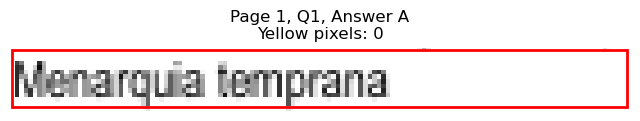

Page 1, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=174.7, y1=123.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 482
Page 1, Q1, B: Yellow percentage: 0.0%


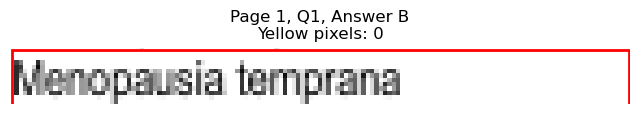

Page 1, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=172.7, y1=135.6
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 430
Page 1, Q1, C: Yellow percentage: 0.0%


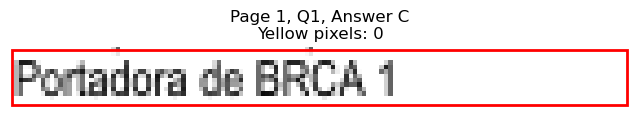

Page 1, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=375.8, y1=110.4
Page 1, Q1, D: Yellow pixels: 929
Page 1, Q1, D: Total non-white pixels: 1288
Page 1, Q1, D: Yellow percentage: 72.1%


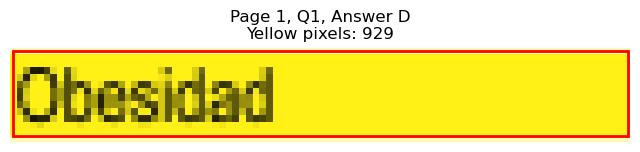

Page 1, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=448.5, y1=123.0
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 742
Page 1, Q1, E: Yellow percentage: 0.0%


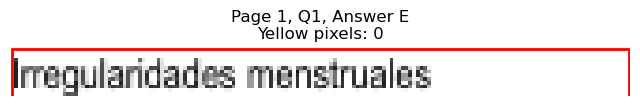


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=128.6, y0=186.0, x1=176.2, y1=198.7
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 450
Page 1, Q2, A: Yellow percentage: 0.0%


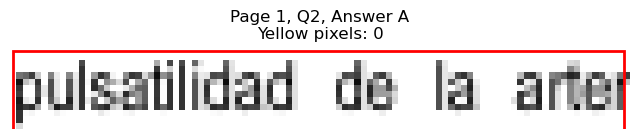

Page 1, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=275.2, y1=224.0
Page 1, Q2, B: Yellow pixels: 1719
Page 1, Q2, B: Total non-white pixels: 2509
Page 1, Q2, B: Yellow percentage: 68.5%


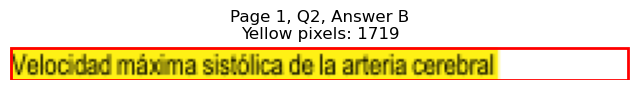

Page 1, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=125.1, y1=249.2
Page 1, Q2, C: Yellow pixels: 94
Page 1, Q2, C: Total non-white pixels: 475
Page 1, Q2, C: Yellow percentage: 19.8%


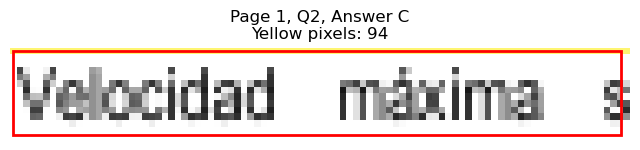

Page 1, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=509.3, y1=198.7
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 926
Page 1, Q2, D: Yellow percentage: 0.0%


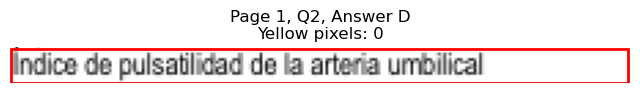

Page 1, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=506.7, y1=211.3
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 845
Page 1, Q2, E: Yellow percentage: 0.0%


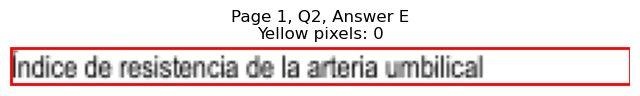


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=167.7, y1=324.9
Page 1, Q3, A: Yellow pixels: 1436
Page 1, Q3, A: Total non-white pixels: 1768
Page 1, Q3, A: Yellow percentage: 81.2%


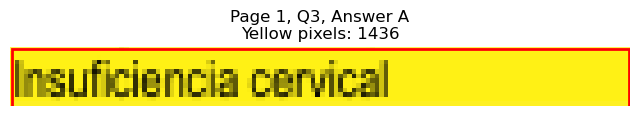

Page 1, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=152.2, y1=337.5
Page 1, Q3, B: Yellow pixels: 121
Page 1, Q3, B: Total non-white pixels: 466
Page 1, Q3, B: Yellow percentage: 26.0%


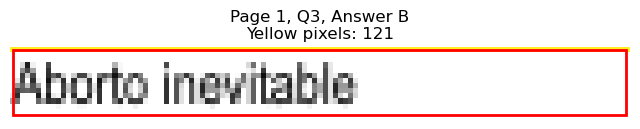

Page 1, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=149.2, y1=350.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 309
Page 1, Q3, C: Yellow percentage: 0.0%


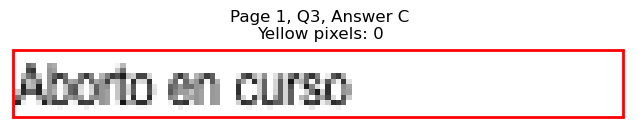

Page 1, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=449.0, y1=324.9
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 544
Page 1, Q3, D: Yellow percentage: 0.0%


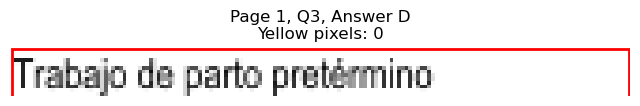

Page 1, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=412.9, y1=337.5
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 403
Page 1, Q3, E: Yellow percentage: 0.0%


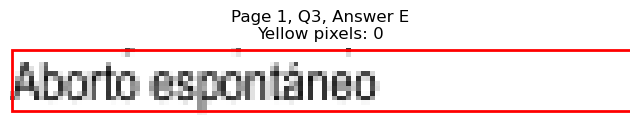


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=425.9, x1=150.1, y1=438.6
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 314
Page 1, Q4, A: Yellow percentage: 0.0%


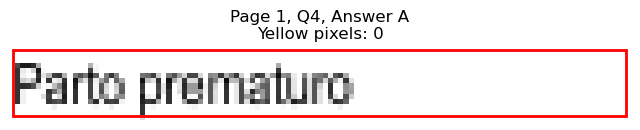

Page 1, Q4 - B: Detected box: x0=82.5, y0=438.5, x1=213.9, y1=451.2
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 668
Page 1, Q4, B: Yellow percentage: 0.0%


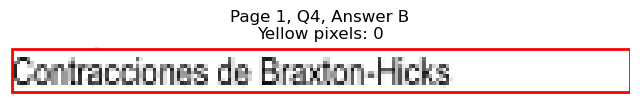

Page 1, Q4 - C: Detected box: x0=82.9, y0=451.1, x1=159.6, y1=463.8
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 409
Page 1, Q4, C: Yellow percentage: 0.0%


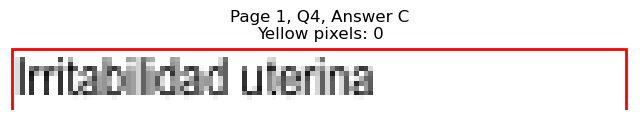

Page 1, Q4 - D: Detected box: x0=334.6, y0=425.9, x1=408.3, y1=438.6
Page 1, Q4, D: Yellow pixels: 125
Page 1, Q4, D: Total non-white pixels: 483
Page 1, Q4, D: Yellow percentage: 25.9%


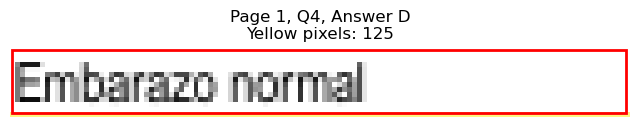

Page 1, Q4 - E: Detected box: x0=334.1, y0=438.5, x1=456.1, y1=451.2
Page 1, Q4, E: Yellow pixels: 1809
Page 1, Q4, E: Total non-white pixels: 2422
Page 1, Q4, E: Yellow percentage: 74.7%


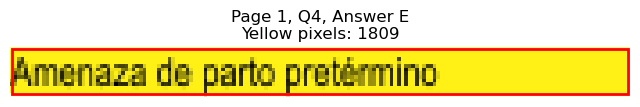


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=526.9, x1=105.0, y1=539.5
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 100
Page 1, Q5, A: Yellow percentage: 0.0%


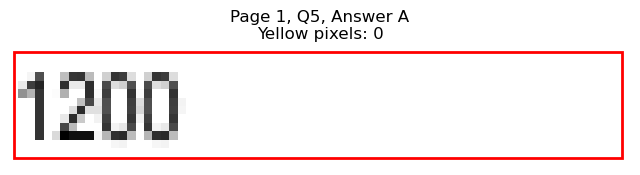

Page 1, Q5 - B: Detected box: x0=82.5, y0=539.5, x1=105.0, y1=552.1
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 102
Page 1, Q5, B: Yellow percentage: 0.0%


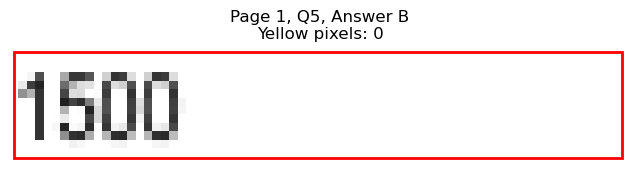

Page 1, Q5 - C: Detected box: x0=82.9, y0=552.2, x1=105.5, y1=564.8
Page 1, Q5, C: Yellow pixels: 854
Page 1, Q5, C: Total non-white pixels: 962
Page 1, Q5, C: Yellow percentage: 88.8%


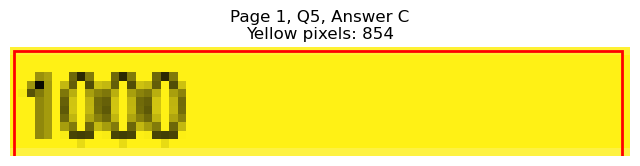

Page 1, Q5 - D: Detected box: x0=334.6, y0=526.9, x1=352.1, y1=539.5
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 96
Page 1, Q5, D: Yellow percentage: 0.0%


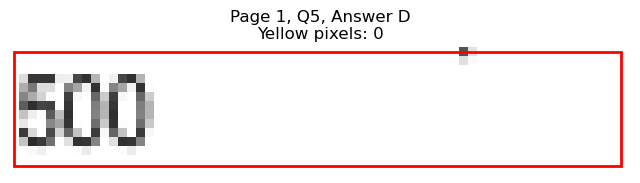

Page 1, Q5 - E: Detected box: x0=334.1, y0=539.5, x1=351.7, y1=552.1
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 93
Page 1, Q5, E: Yellow percentage: 0.0%


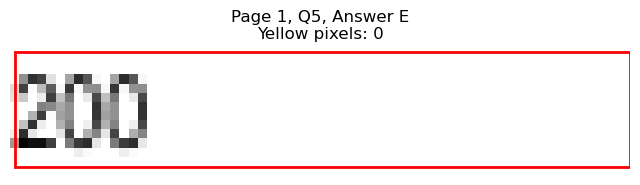


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=590.0, x1=146.2, y1=602.6
Page 1, Q6, A: Yellow pixels: 115
Page 1, Q6, A: Total non-white pixels: 453
Page 1, Q6, A: Yellow percentage: 25.4%


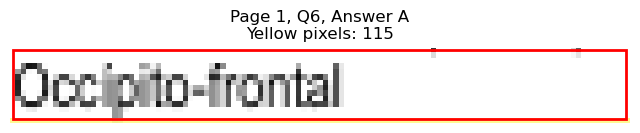

Page 1, Q6 - B: Detected box: x0=82.5, y0=602.6, x1=173.8, y1=615.2
Page 1, Q6, B: Yellow pixels: 1493
Page 1, Q6, B: Total non-white pixels: 1988
Page 1, Q6, B: Yellow percentage: 75.1%


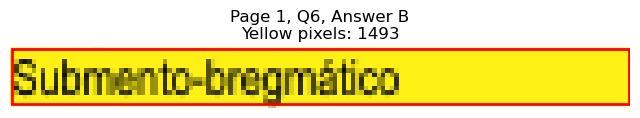

Page 1, Q6 - C: Detected box: x0=82.9, y0=615.2, x1=180.3, y1=627.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 664
Page 1, Q6, C: Yellow percentage: 0.0%


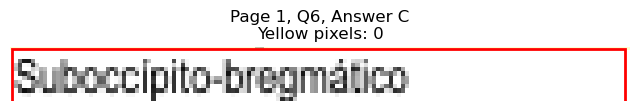

Page 1, Q6 - D: Detected box: x0=334.6, y0=590.0, x1=442.5, y1=602.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 552
Page 1, Q6, D: Yellow percentage: 0.0%


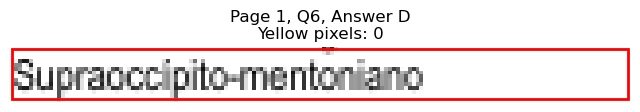

Page 1, Q6 - E: Detected box: x0=334.1, y0=602.6, x1=394.4, y1=615.2
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 305
Page 1, Q6, E: Yellow percentage: 0.0%


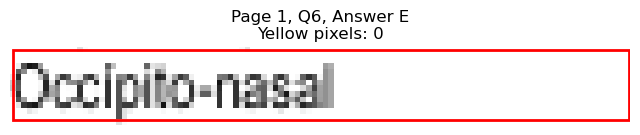


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=691.1, x1=182.8, y1=703.7
Page 1, Q7, A: Yellow pixels: 2
Page 1, Q7, A: Total non-white pixels: 670
Page 1, Q7, A: Yellow percentage: 0.3%


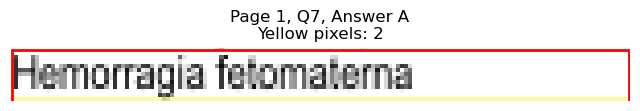

Page 1, Q7 - B: Detected box: x0=82.5, y0=703.7, x1=158.7, y1=716.3
Page 1, Q7, B: Yellow pixels: 1222
Page 1, Q7, B: Total non-white pixels: 1778
Page 1, Q7, B: Yellow percentage: 68.7%


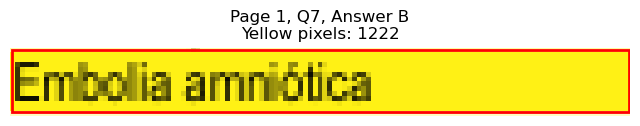

Page 1, Q7 - C: Detected box: x0=82.9, y0=716.3, x1=246.4, y1=728.9
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 1039
Page 1, Q7, C: Yellow percentage: 0.0%


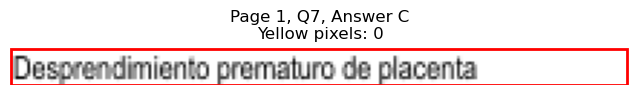

Page 1, Q7 - D: Detected box: x0=334.6, y0=691.1, x1=384.8, y1=703.7
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 242
Page 1, Q7, D: Yellow percentage: 0.0%


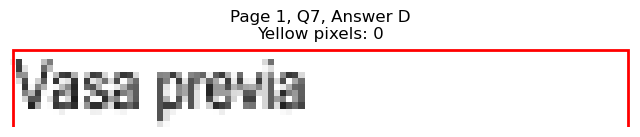

Page 1, Q7 - E: Detected box: x0=334.1, y0=703.7, x1=414.5, y1=716.3
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 433
Page 1, Q7, E: Yellow percentage: 0.0%


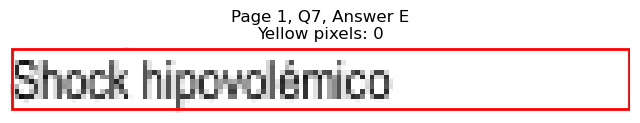


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=177.7, y1=135.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 524
Page 2, Q1, A: Yellow percentage: 0.0%


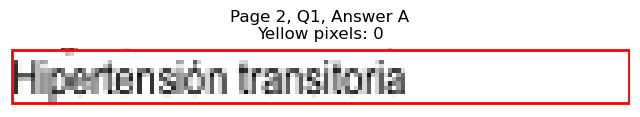

Page 2, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=139.7, y1=148.2
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 526
Page 2, Q1, B: Yellow percentage: 0.0%


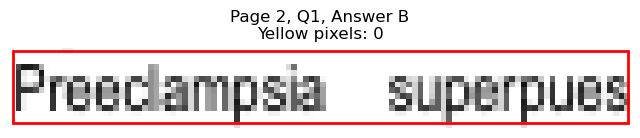

Page 2, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=169.7, y1=173.5
Page 2, Q1, C: Yellow pixels: 1443
Page 2, Q1, C: Total non-white pixels: 1932
Page 2, Q1, C: Yellow percentage: 74.7%


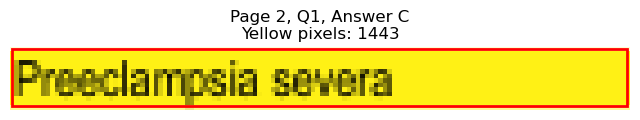

Page 2, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=410.8, y1=135.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 412
Page 2, Q1, D: Yellow percentage: 0.0%


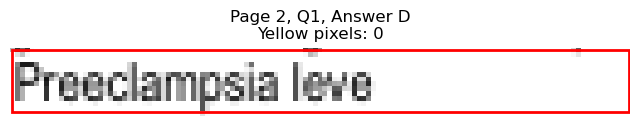

Page 2, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=475.5, y1=148.2
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 708
Page 2, Q1, E: Yellow percentage: 0.0%


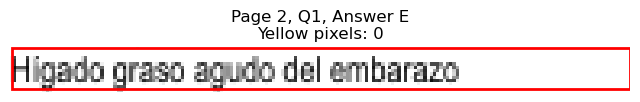


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=182.3, y1=236.6
Page 2, Q2, A: Yellow pixels: 1582
Page 2, Q2, A: Total non-white pixels: 2114
Page 2, Q2, A: Yellow percentage: 74.8%


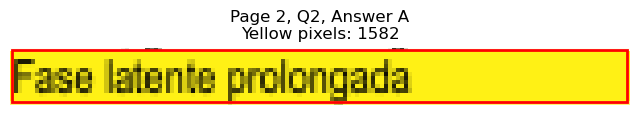

Page 2, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=172.7, y1=249.2
Page 2, Q2, B: Yellow pixels: 139
Page 2, Q2, B: Total non-white pixels: 590
Page 2, Q2, B: Yellow percentage: 23.6%


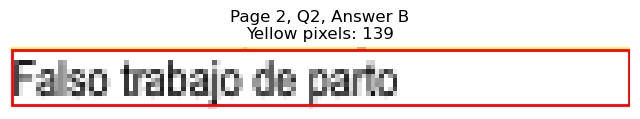

Page 2, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=193.8, y1=261.8
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 564
Page 2, Q2, C: Yellow percentage: 0.0%


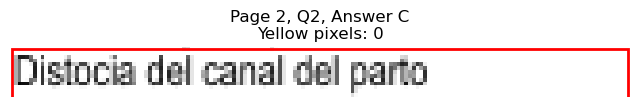

Page 2, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=435.9, y1=236.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 515
Page 2, Q2, D: Yellow percentage: 0.0%


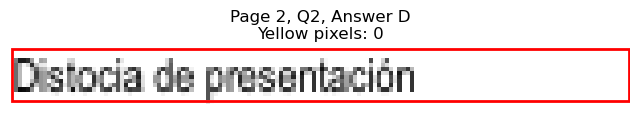

Page 2, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=430.5, y1=249.2
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 491
Page 2, Q2, E: Yellow percentage: 0.0%


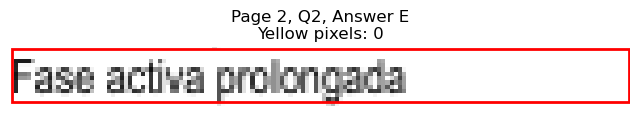


Page 2, Q2 - Selected Answer: A (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=312.3, x1=134.1, y1=324.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 264
Page 2, Q3, A: Yellow percentage: 0.0%


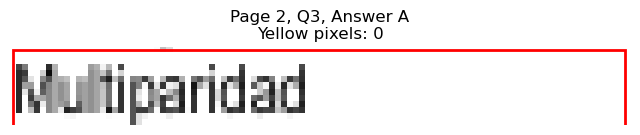

Page 2, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=206.3, y1=337.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 622
Page 2, Q3, B: Yellow percentage: 0.0%


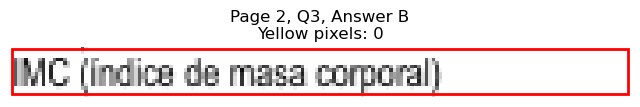

Page 2, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=184.2, y1=350.1
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 542
Page 2, Q3, C: Yellow percentage: 0.0%


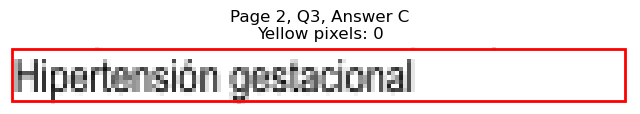

Page 2, Q3 - D: Detected box: x0=334.6, y0=312.3, x1=406.4, y1=324.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 502
Page 2, Q3, D: Yellow percentage: 0.0%


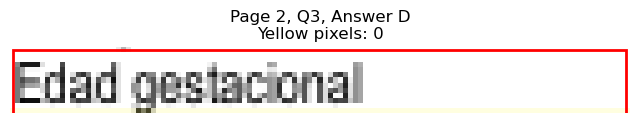

Page 2, Q3 - E: Detected box: x0=334.1, y0=324.9, x1=402.8, y1=337.5
Page 2, Q3, E: Yellow pixels: 1297
Page 2, Q3, E: Total non-white pixels: 1666
Page 2, Q3, E: Yellow percentage: 77.9%


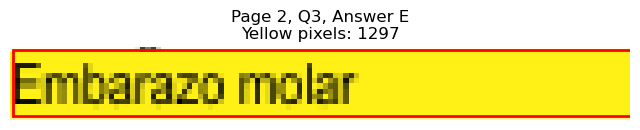


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=152.2, y1=413.3
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 349
Page 2, Q4, A: Yellow percentage: 0.0%


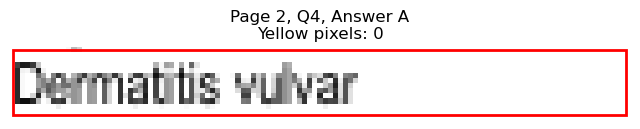

Page 2, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=168.3, y1=426.0
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 429
Page 2, Q4, B: Yellow percentage: 0.0%


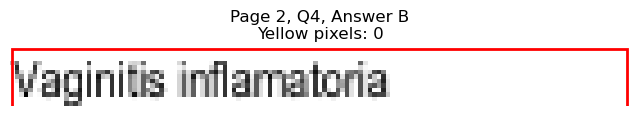

Page 2, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=151.7, y1=438.6
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 377
Page 2, Q4, C: Yellow percentage: 0.0%


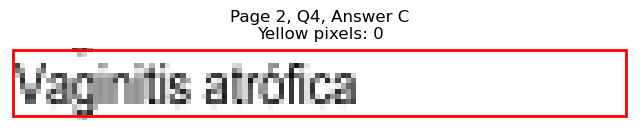

Page 2, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=407.8, y1=413.3
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 357
Page 2, Q4, D: Yellow percentage: 0.0%


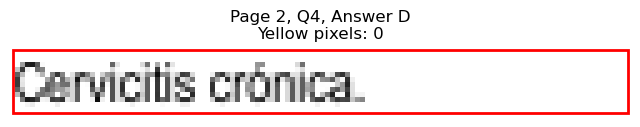

Page 2, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=458.0, y1=426.0
Page 2, Q4, E: Yellow pixels: 1775
Page 2, Q4, E: Total non-white pixels: 2262
Page 2, Q4, E: Yellow percentage: 78.5%


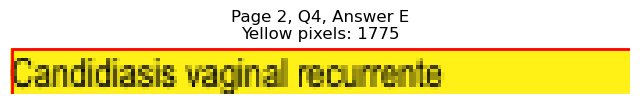


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=489.1, x1=143.2, y1=501.7
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 327
Page 2, Q5, A: Yellow percentage: 0.0%


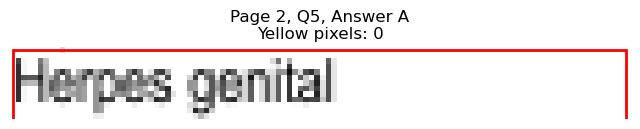

Page 2, Q5 - B: Detected box: x0=82.5, y0=501.7, x1=163.2, y1=514.3
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 382
Page 2, Q5, B: Yellow percentage: 0.0%


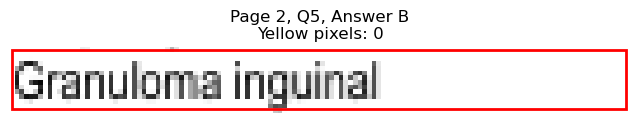

Page 2, Q5 - C: Detected box: x0=82.9, y0=514.3, x1=197.8, y1=526.9
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 575
Page 2, Q5, C: Yellow percentage: 0.0%


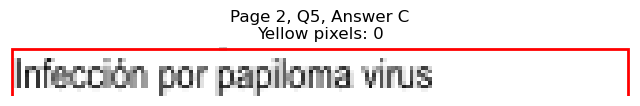

Page 2, Q5 - D: Detected box: x0=334.6, y0=489.1, x1=405.3, y1=501.7
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 501
Page 2, Q5, D: Yellow percentage: 0.0%


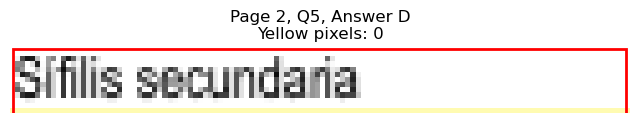

Page 2, Q5 - E: Detected box: x0=334.1, y0=501.7, x1=400.4, y1=514.3
Page 2, Q5, E: Yellow pixels: 1160
Page 2, Q5, E: Total non-white pixels: 1638
Page 2, Q5, E: Yellow percentage: 70.8%


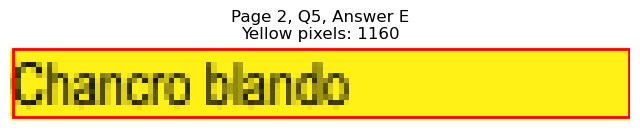


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=145.2, y1=564.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 330
Page 2, Q6, A: Yellow percentage: 0.0%


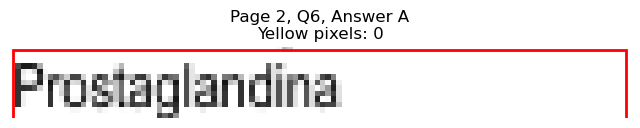

Page 2, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=116.1, y1=577.4
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 164
Page 2, Q6, B: Yellow percentage: 0.0%


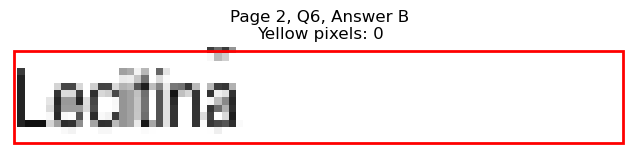

Page 2, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=138.1, y1=590.0
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 273
Page 2, Q6, C: Yellow percentage: 0.0%


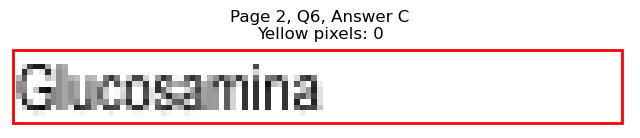

Page 2, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=386.8, y1=564.8
Page 2, Q6, D: Yellow pixels: 1116
Page 2, Q6, D: Total non-white pixels: 1339
Page 2, Q6, D: Yellow percentage: 83.3%


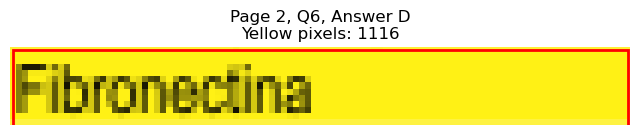

Page 2, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=366.3, y1=577.4
Page 2, Q6, E: Yellow pixels: 83
Page 2, Q6, E: Total non-white pixels: 244
Page 2, Q6, E: Yellow percentage: 34.0%


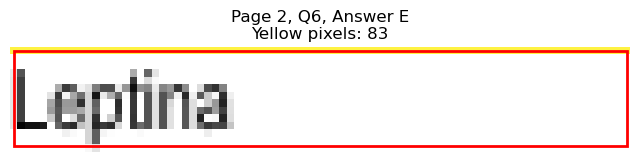


Page 2, Q6 - Selected Answer: D (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=640.5, x1=128.1, y1=653.2
Page 2, Q7, A: Yellow pixels: 97
Page 2, Q7, A: Total non-white pixels: 315
Page 2, Q7, A: Yellow percentage: 30.8%


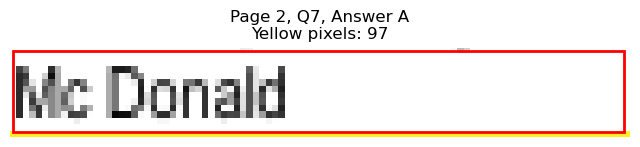

Page 2, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=131.1, y1=665.8
Page 2, Q7, B: Yellow pixels: 1102
Page 2, Q7, B: Total non-white pixels: 1300
Page 2, Q7, B: Yellow percentage: 84.8%


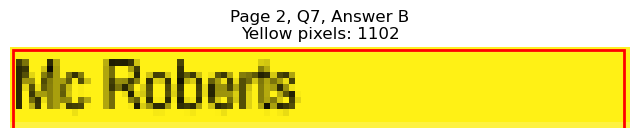

Page 2, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=121.6, y1=678.4
Page 2, Q7, C: Yellow pixels: 90
Page 2, Q7, C: Total non-white pixels: 294
Page 2, Q7, C: Yellow percentage: 30.6%


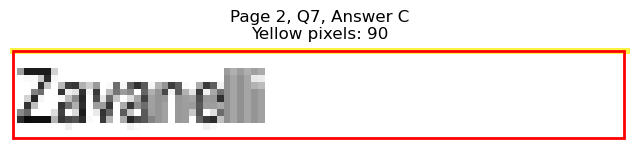

Page 2, Q7 - D: Detected box: x0=334.6, y0=640.5, x1=379.3, y1=653.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 235
Page 2, Q7, D: Yellow percentage: 0.0%


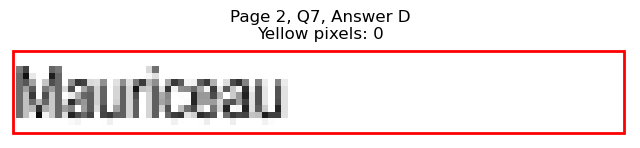

Page 2, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=362.7, y1=665.8
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 155
Page 2, Q7, E: Yellow percentage: 0.0%


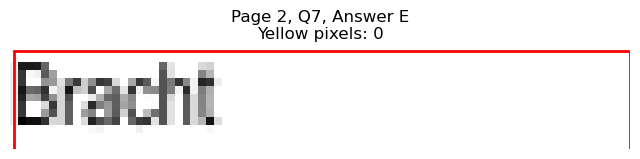


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=716.3, x1=298.1, y1=728.9
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 1096
Page 2, Q8, A: Yellow percentage: 0.0%


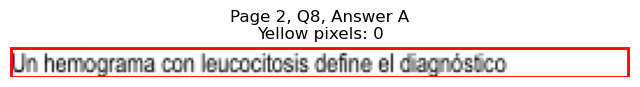

Page 2, Q8 - B: Detected box: x0=82.5, y0=728.9, x1=305.1, y1=741.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 1127
Page 2, Q8, B: Yellow percentage: 0.0%


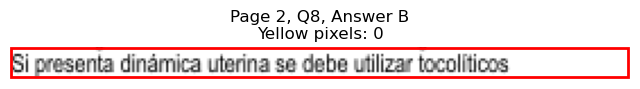

Page 2, Q8 - C: Detected box: x0=82.9, y0=741.4, x1=204.3, y1=754.1
Page 2, Q8, C: Yellow pixels: 173
Page 2, Q8, C: Total non-white pixels: 756
Page 2, Q8, C: Yellow percentage: 22.9%


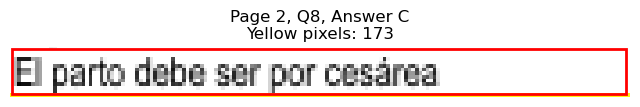

Page 2, Q8 - D: Detected box: x0=82.9, y0=754.0, x1=362.5, y1=766.7
Page 2, Q8, D: Yellow pixels: 3207
Page 2, Q8, D: Total non-white pixels: 4303
Page 2, Q8, D: Yellow percentage: 74.5%


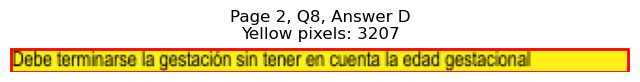

Page 2, Q8 - E: Detected box: x0=82.5, y0=766.8, x1=329.8, y1=779.4
Page 2, Q8, E: Yellow pixels: 295
Page 2, Q8, E: Total non-white pixels: 1505
Page 2, Q8, E: Yellow percentage: 19.6%


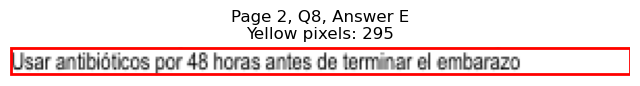


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=135.5, x1=160.7, y1=148.2
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 418
Page 3, Q1, A: Yellow percentage: 0.0%


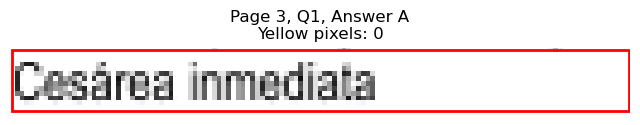

Page 3, Q1 - B: Detected box: x0=82.5, y0=148.2, x1=161.2, y1=160.9
Page 3, Q1, B: Yellow pixels: 1374
Page 3, Q1, B: Total non-white pixels: 1690
Page 3, Q1, B: Yellow percentage: 81.3%


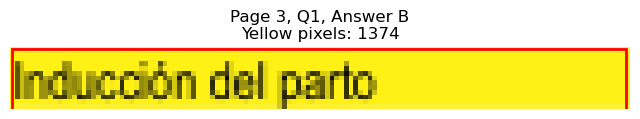

Page 3, Q1 - C: Detected box: x0=82.9, y0=160.8, x1=120.5, y1=173.5
Page 3, Q1, C: Yellow pixels: 88
Page 3, Q1, C: Total non-white pixels: 285
Page 3, Q1, C: Yellow percentage: 30.9%


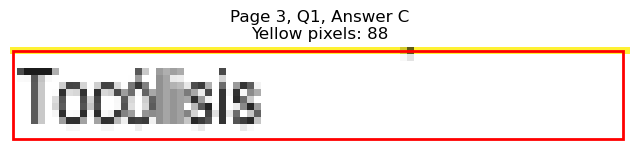

Page 3, Q1 - D: Detected box: x0=334.6, y0=135.5, x1=424.4, y1=148.2
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 448
Page 3, Q1, D: Yellow percentage: 0.0%


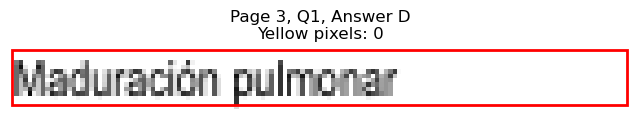

Page 3, Q1 - E: Detected box: x0=334.1, y0=148.2, x1=387.3, y1=160.9
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 275
Page 3, Q1, E: Yellow percentage: 0.0%


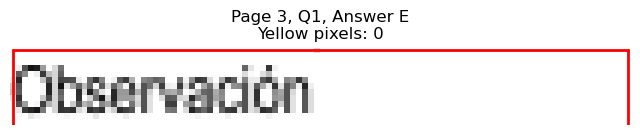


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=153.1, y1=224.0
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 328
Page 3, Q2, A: Yellow percentage: 0.0%


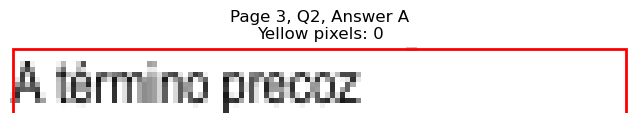

Page 3, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=123.6, y1=236.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 195
Page 3, Q2, B: Yellow percentage: 0.0%


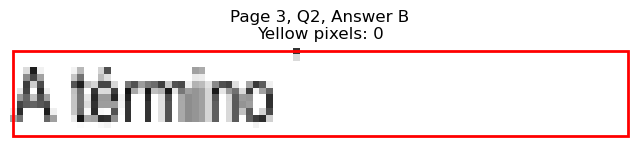

Page 3, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=136.1, y1=249.2
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 252
Page 3, Q2, C: Yellow percentage: 0.0%


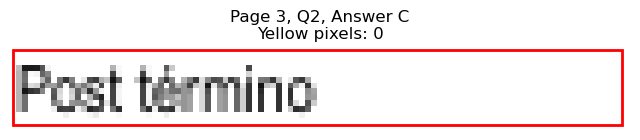

Page 3, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=388.3, y1=224.0
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 369
Page 3, Q2, D: Yellow percentage: 0.0%


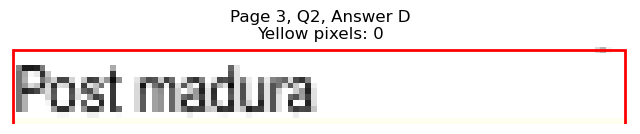

Page 3, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=400.9, y1=236.6
Page 3, Q2, E: Yellow pixels: 1284
Page 3, Q2, E: Total non-white pixels: 1638
Page 3, Q2, E: Yellow percentage: 78.4%


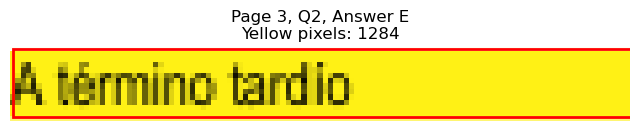


Page 3, Q2 - Selected Answer: E (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=243.1, y1=312.3
Page 3, Q3, A: Yellow pixels: 1843
Page 3, Q3, A: Total non-white pixels: 2702
Page 3, Q3, A: Yellow percentage: 68.2%


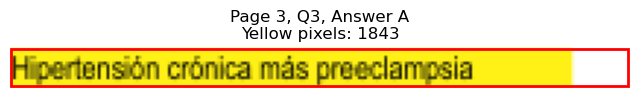

Page 3, Q3 - B: Detected box: x0=82.5, y0=324.9, x1=183.7, y1=337.5
Page 3, Q3, B: Yellow pixels: 144
Page 3, Q3, B: Total non-white pixels: 697
Page 3, Q3, B: Yellow percentage: 20.7%


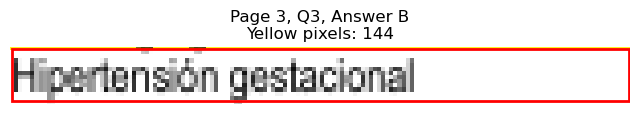

Page 3, Q3 - C: Detected box: x0=82.9, y0=337.5, x1=159.1, y1=350.1
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 388
Page 3, Q3, C: Yellow percentage: 0.0%


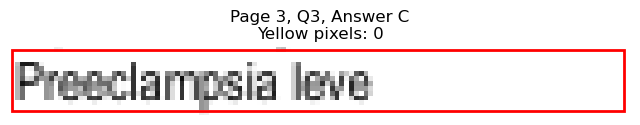

Page 3, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=421.4, y1=312.3
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 449
Page 3, Q3, D: Yellow percentage: 0.0%


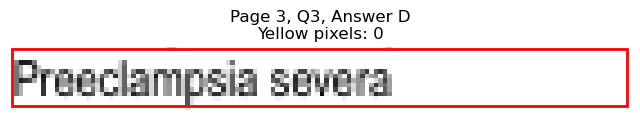

Page 3, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=418.9, y1=324.9
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 449
Page 3, Q3, E: Yellow percentage: 0.0%


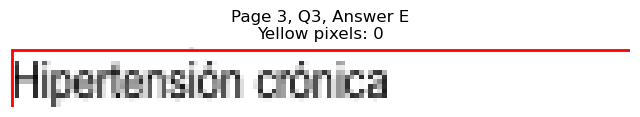


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=413.3, x1=150.1, y1=426.0
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 347
Page 3, Q4, A: Yellow percentage: 0.0%


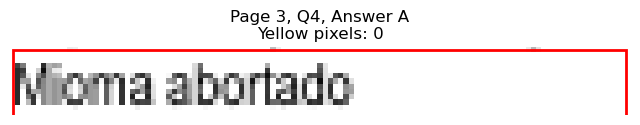

Page 3, Q4 - B: Detected box: x0=82.5, y0=425.9, x1=142.1, y1=438.6
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 285
Page 3, Q4, B: Yellow percentage: 0.0%


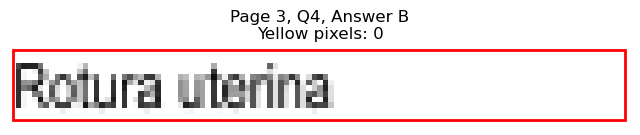

Page 3, Q4 - C: Detected box: x0=82.9, y0=438.5, x1=152.2, y1=451.2
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 366
Page 3, Q4, C: Yellow percentage: 0.0%


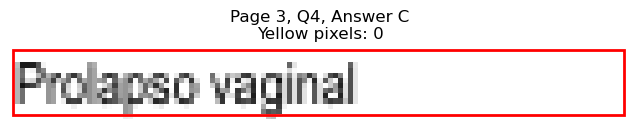

Page 3, Q4 - D: Detected box: x0=334.6, y0=413.3, x1=403.9, y1=426.0
Page 3, Q4, D: Yellow pixels: 1284
Page 3, Q4, D: Total non-white pixels: 1560
Page 3, Q4, D: Yellow percentage: 82.3%


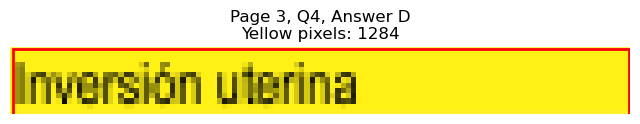

Page 3, Q4 - E: Detected box: x0=334.1, y0=425.9, x1=428.0, y1=438.6
Page 3, Q4, E: Yellow pixels: 144
Page 3, Q4, E: Total non-white pixels: 626
Page 3, Q4, E: Yellow percentage: 23.0%


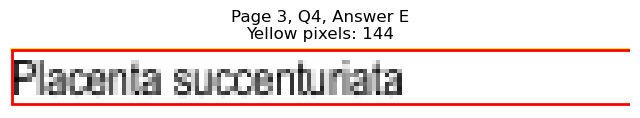


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=489.1, x1=165.3, y1=501.7
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 429
Page 3, Q5, A: Yellow percentage: 0.0%


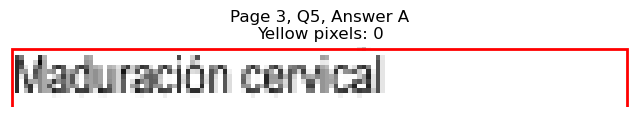

Page 3, Q5 - B: Detected box: x0=82.5, y0=148.2, x1=161.2, y1=160.9
Page 3, Q5, B: Yellow pixels: 1374
Page 3, Q5, B: Total non-white pixels: 1690
Page 3, Q5, B: Yellow percentage: 81.3%


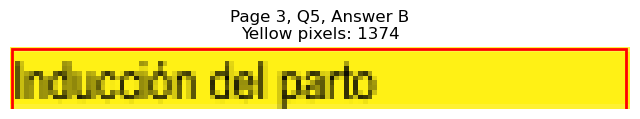

Page 3, Q5 - C: Detected box: x0=82.9, y0=514.3, x1=181.7, y1=526.9
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 461
Page 3, Q5, C: Yellow percentage: 0.0%


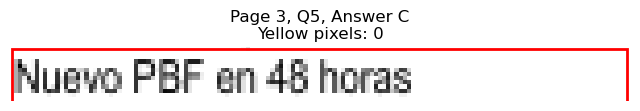

Page 3, Q5 - D: Detected box: x0=334.6, y0=489.1, x1=423.9, y1=501.7
Page 3, Q5, D: Yellow pixels: 1487
Page 3, Q5, D: Total non-white pixels: 1820
Page 3, Q5, D: Yellow percentage: 81.7%


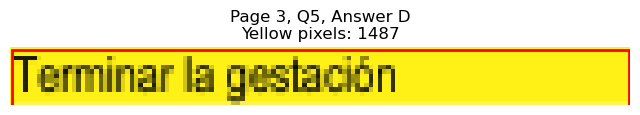

Page 3, Q5 - E: Detected box: x0=334.1, y0=501.7, x1=467.0, y1=514.3
Page 3, Q5, E: Yellow pixels: 182
Page 3, Q5, E: Total non-white pixels: 852
Page 3, Q5, E: Yellow percentage: 21.4%


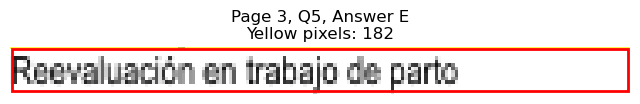


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=242.0, y1=590.0
Page 3, Q6, A: Yellow pixels: 192
Page 3, Q6, A: Total non-white pixels: 1137
Page 3, Q6, A: Yellow percentage: 16.9%


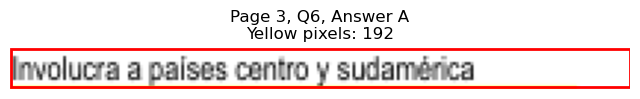

Page 3, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=247.0, y1=602.6
Page 3, Q6, B: Yellow pixels: 1935
Page 3, Q6, B: Total non-white pixels: 2701
Page 3, Q6, B: Yellow percentage: 71.6%


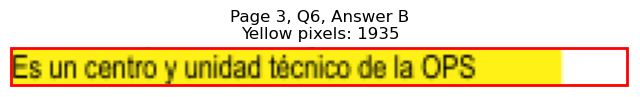

Page 3, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=237.5, y1=615.2
Page 3, Q6, C: Yellow pixels: 191
Page 3, Q6, C: Total non-white pixels: 977
Page 3, Q6, C: Yellow percentage: 19.5%


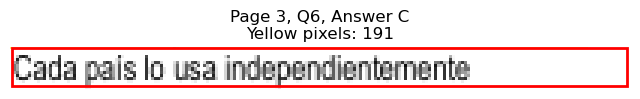

Page 3, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=516.7, y1=590.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 880
Page 3, Q6, D: Yellow percentage: 0.0%


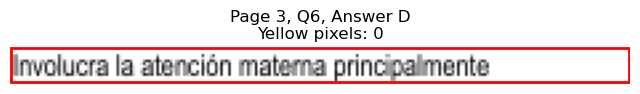

Page 3, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=480.7, y1=602.6
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 734
Page 3, Q6, E: Yellow percentage: 0.0%


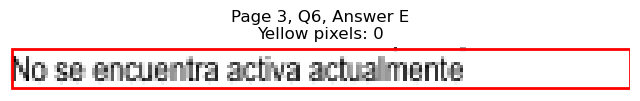


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=210.9, y1=665.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 651
Page 3, Q7, A: Yellow percentage: 0.0%


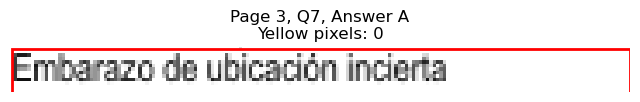

Page 3, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=189.7, y1=678.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 547
Page 3, Q7, B: Yellow percentage: 0.0%


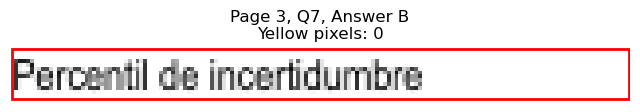

Page 3, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=165.1, y1=691.0
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 422
Page 3, Q7, C: Yellow percentage: 0.0%


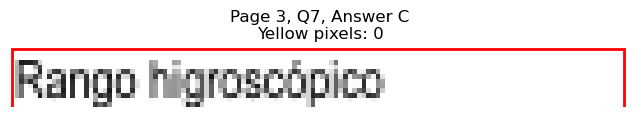

Page 3, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=405.9, y1=665.8
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 477
Page 3, Q7, D: Yellow percentage: 0.0%


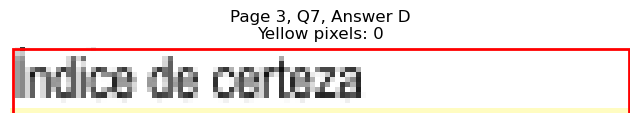

Page 3, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=429.4, y1=678.4
Page 3, Q7, E: Yellow pixels: 1381
Page 3, Q7, E: Total non-white pixels: 2044
Page 3, Q7, E: Yellow percentage: 67.6%


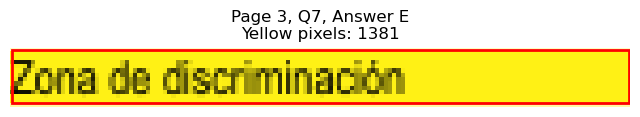


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=137.7, y1=754.1
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 266
Page 3, Q8, A: Yellow percentage: 0.0%


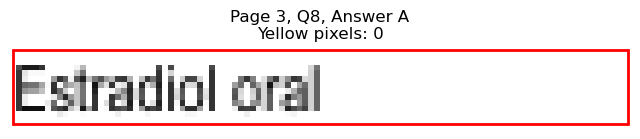

Page 3, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=261.0, y1=766.7
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 952
Page 3, Q8, B: Yellow percentage: 0.0%


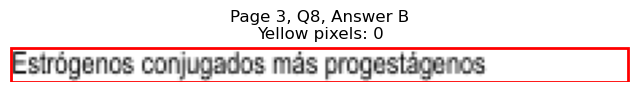

Page 3, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=199.4, y1=779.4
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 628
Page 3, Q8, C: Yellow percentage: 0.0%


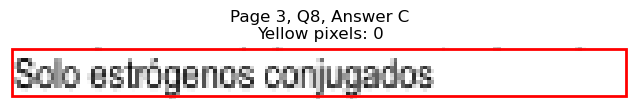

Page 3, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=389.3, y1=754.1
Page 3, Q8, D: Yellow pixels: 106
Page 3, Q8, D: Total non-white pixels: 369
Page 3, Q8, D: Yellow percentage: 28.7%


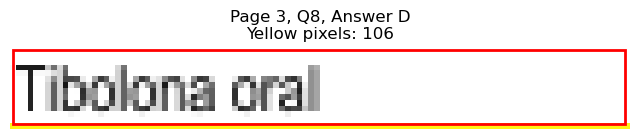

Page 3, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=409.4, y1=766.7
Page 3, Q8, E: Yellow pixels: 1317
Page 3, Q8, E: Total non-white pixels: 1638
Page 3, Q8, E: Yellow percentage: 80.4%


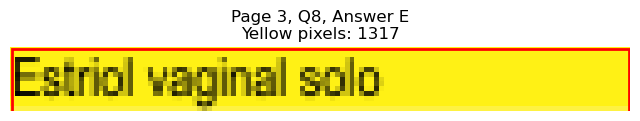


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=70.8, y0=97.7, x1=79.3, y1=110.4
Page 4, Q1, A: Yellow pixels: 668
Page 4, Q1, A: Total non-white pixels: 840
Page 4, Q1, A: Yellow percentage: 79.5%


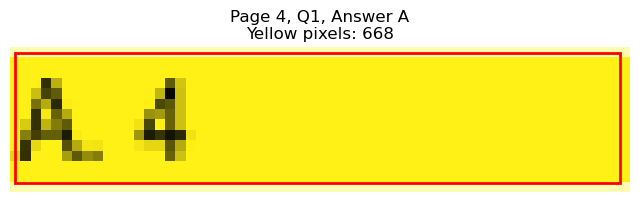

Page 4, Q1 - B: Detected box: x0=70.8, y0=110.3, x1=79.3, y1=123.0
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 128
Page 4, Q1, B: Yellow percentage: 0.0%


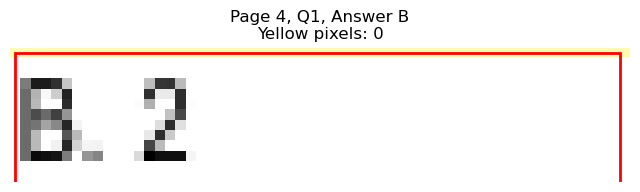

Page 4, Q1 - C: Detected box: x0=70.8, y0=122.9, x1=79.8, y1=135.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 66
Page 4, Q1, C: Yellow percentage: 0.0%


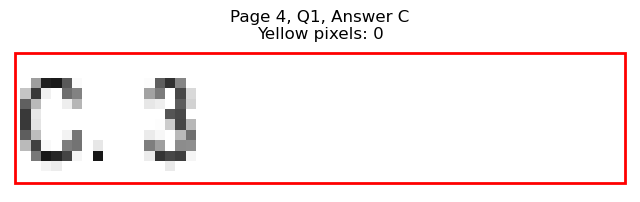

Page 4, Q1 - D: Detected box: x0=322.5, y0=97.7, x1=331.5, y1=110.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 74
Page 4, Q1, D: Yellow percentage: 0.0%


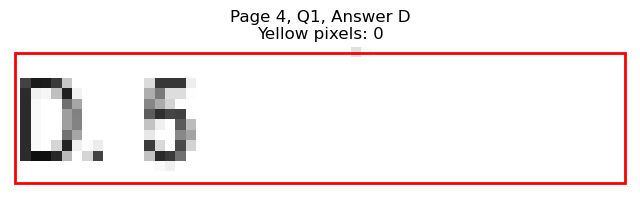

Page 4, Q1 - E: Detected box: x0=322.5, y0=110.3, x1=331.0, y1=123.0
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 72
Page 4, Q1, E: Yellow percentage: 0.0%


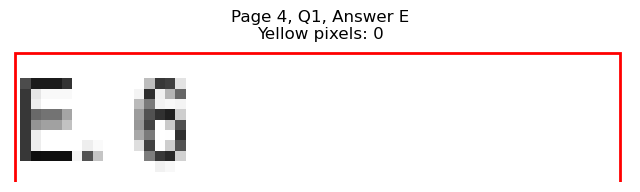


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=192.3, y1=198.7
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 579
Page 4, Q2, A: Yellow percentage: 0.0%


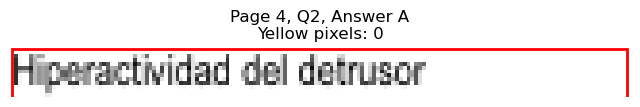

Page 4, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=156.1, y1=211.3
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 395
Page 4, Q2, B: Yellow percentage: 0.0%


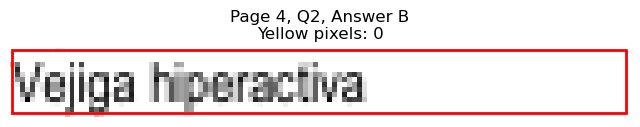

Page 4, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=177.3, y1=224.0
Page 4, Q2, C: Yellow pixels: 1557
Page 4, Q2, C: Total non-white pixels: 1898
Page 4, Q2, C: Yellow percentage: 82.0%


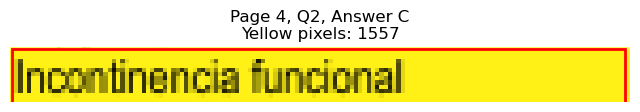

Page 4, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=491.6, y1=198.7
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 809
Page 4, Q2, D: Yellow percentage: 0.0%


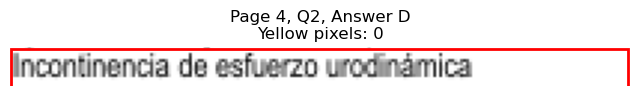

Page 4, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=439.5, y1=211.3
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 506
Page 4, Q2, E: Yellow percentage: 0.0%


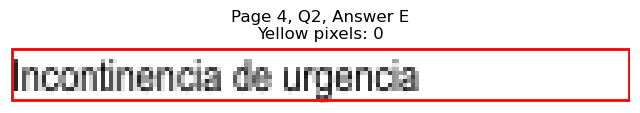


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=163.7, y1=287.1
Page 4, Q3, A: Yellow pixels: 1379
Page 4, Q3, A: Total non-white pixels: 1848
Page 4, Q3, A: Yellow percentage: 74.6%


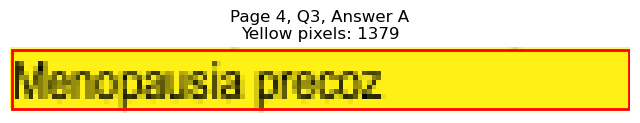

Page 4, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=125.5, y1=299.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 320
Page 4, Q3, B: Yellow percentage: 0.0%


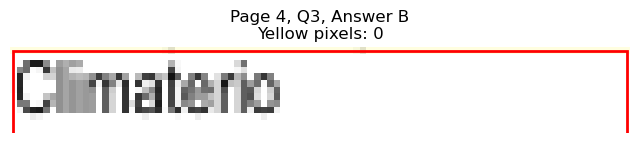

Page 4, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=134.7, y1=312.3
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 261
Page 4, Q3, C: Yellow percentage: 0.0%


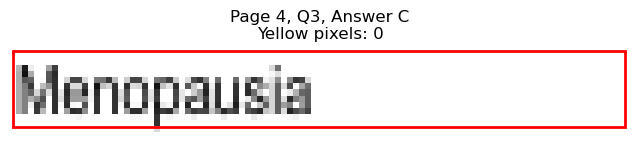

Page 4, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=400.4, y1=287.1
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 338
Page 4, Q3, D: Yellow percentage: 0.0%


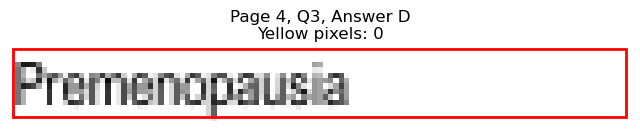

Page 4, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=393.8, y1=299.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 291
Page 4, Q3, E: Yellow percentage: 0.0%


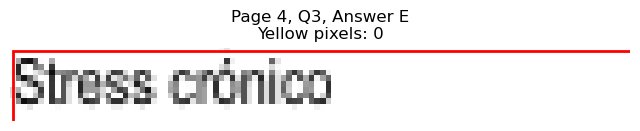


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=227.9, y1=375.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 738
Page 4, Q4, A: Yellow percentage: 0.0%


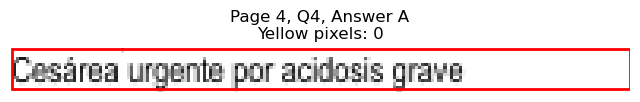

Page 4, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=305.7, y1=388.1
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 1086
Page 4, Q4, B: Yellow percentage: 0.0%


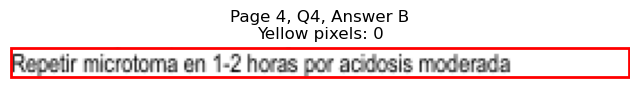

Page 4, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=318.6, y1=400.7
Page 4, Q4, C: Yellow pixels: 3
Page 4, Q4, C: Total non-white pixels: 1405
Page 4, Q4, C: Yellow percentage: 0.2%


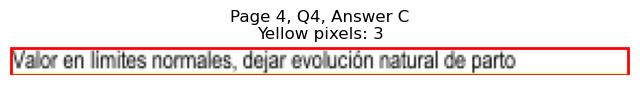

Page 4, Q4 - D: Detected box: x0=82.9, y0=400.6, x1=325.6, y1=413.3
Page 4, Q4, D: Yellow pixels: 2615
Page 4, Q4, D: Total non-white pixels: 4116
Page 4, Q4, D: Yellow percentage: 63.5%


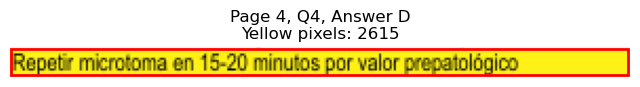

Page 4, Q4 - E: Detected box: x0=82.5, y0=413.3, x1=337.3, y1=426.0
Page 4, Q4, E: Yellow pixels: 1
Page 4, Q4, E: Total non-white pixels: 1521
Page 4, Q4, E: Yellow percentage: 0.1%


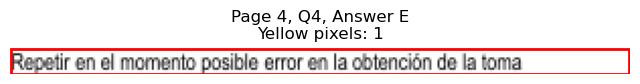


Page 4, Q4 - Selected Answer: D (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=106.3, y0=451.1, x1=162.9, y1=463.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 489
Page 4, Q5, A: Yellow percentage: 0.0%


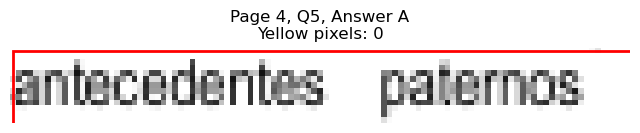

Page 4, Q5 - B: Detected box: x0=82.5, y0=476.3, x1=233.0, y1=489.0
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 717
Page 4, Q5, B: Yellow percentage: 0.0%


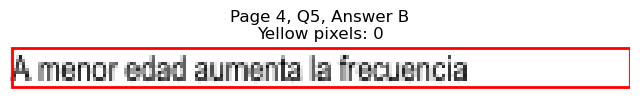

Page 4, Q5 - C: Detected box: x0=82.9, y0=489.1, x1=275.2, y1=501.7
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 947
Page 4, Q5, C: Yellow percentage: 0.0%


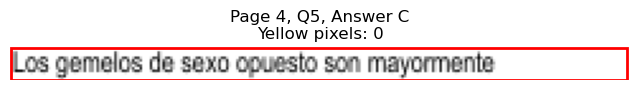

Page 4, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=521.1, y1=463.8
Page 4, Q5, D: Yellow pixels: 4
Page 4, Q5, D: Total non-white pixels: 1144
Page 4, Q5, D: Yellow percentage: 0.3%


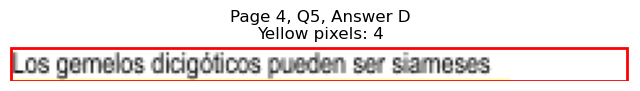

Page 4, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=494.1, y1=476.4
Page 4, Q5, E: Yellow pixels: 1705
Page 4, Q5, E: Total non-white pixels: 2688
Page 4, Q5, E: Yellow percentage: 63.4%


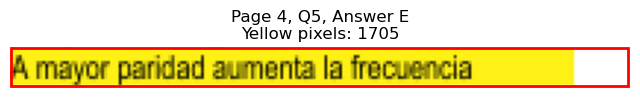


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=192.9, y1=564.8
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 574
Page 4, Q6, A: Yellow percentage: 0.0%


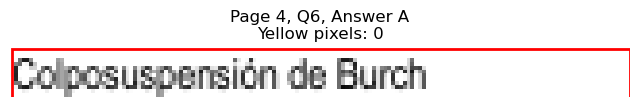

Page 4, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=229.5, y1=577.4
Page 4, Q6, B: Yellow pixels: 192
Page 4, Q6, B: Total non-white pixels: 944
Page 4, Q6, B: Yellow percentage: 20.3%


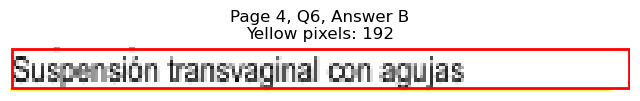

Page 4, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=213.8, y1=590.0
Page 4, Q6, C: Yellow pixels: 1814
Page 4, Q6, C: Total non-white pixels: 2366
Page 4, Q6, C: Yellow percentage: 76.7%


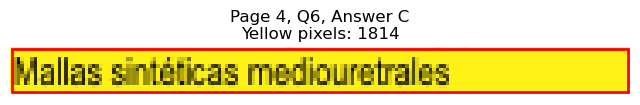

Page 4, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=431.5, y1=564.8
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 484
Page 4, Q6, D: Yellow percentage: 0.0%


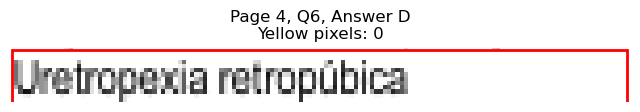

Page 4, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=474.1, y1=577.4
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 737
Page 4, Q6, E: Yellow percentage: 0.0%


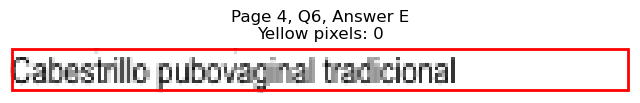


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=640.5, x1=210.9, y1=653.2
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 660
Page 4, Q7, A: Yellow percentage: 0.0%


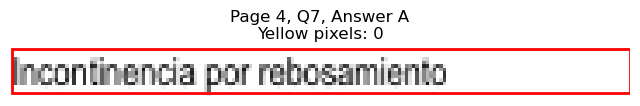

Page 4, Q7 - B: Detected box: x0=82.5, y0=653.1, x1=155.7, y1=665.8
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 384
Page 4, Q7, B: Yellow percentage: 0.0%


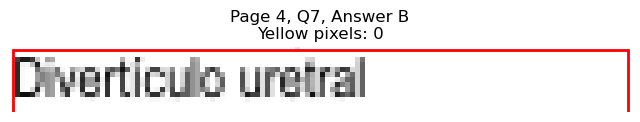

Page 4, Q7 - C: Detected box: x0=82.9, y0=665.7, x1=166.2, y1=678.4
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 436
Page 4, Q7, C: Yellow percentage: 0.0%


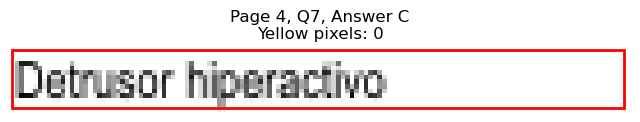

Page 4, Q7 - D: Detected box: x0=334.6, y0=640.5, x1=470.1, y1=653.2
Page 4, Q7, D: Yellow pixels: 187
Page 4, Q7, D: Total non-white pixels: 894
Page 4, Q7, D: Yellow percentage: 20.9%


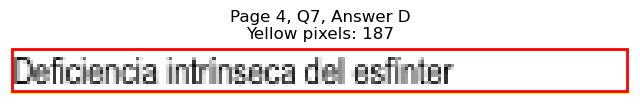

Page 4, Q7 - E: Detected box: x0=334.1, y0=653.1, x1=407.8, y1=665.8
Page 4, Q7, E: Yellow pixels: 1318
Page 4, Q7, E: Total non-white pixels: 1612
Page 4, Q7, E: Yellow percentage: 81.8%


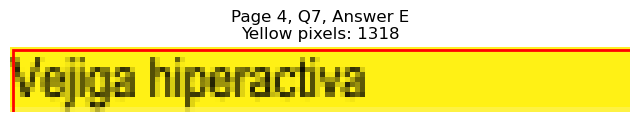


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=728.9, x1=185.8, y1=741.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 511
Page 4, Q8, A: Yellow percentage: 0.0%


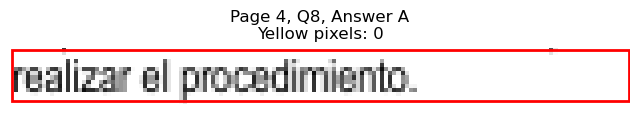

Page 4, Q8 - B: Detected box: x0=82.5, y0=741.4, x1=191.3, y1=754.1
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 545
Page 4, Q8, B: Yellow percentage: 0.0%


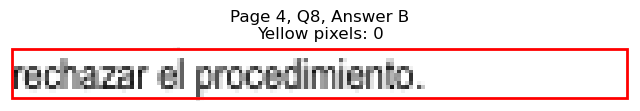

Page 4, Q8 - C: Detected box: x0=82.9, y0=754.0, x1=250.5, y1=766.7
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 803
Page 4, Q8, C: Yellow percentage: 0.0%


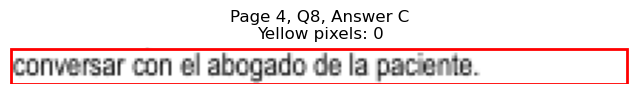

Page 4, Q8 - D: Detected box: x0=334.6, y0=728.9, x1=484.1, y1=741.5
Page 4, Q8, D: Yellow pixels: 192
Page 4, Q8, D: Total non-white pixels: 917
Page 4, Q8, D: Yellow percentage: 20.9%


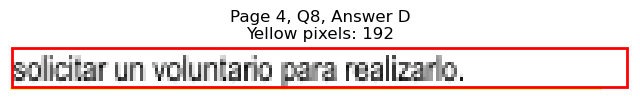

Page 4, Q8 - E: Detected box: x0=334.1, y0=741.4, x1=454.5, y1=754.1
Page 4, Q8, E: Yellow pixels: 1806
Page 4, Q8, E: Total non-white pixels: 2394
Page 4, Q8, E: Yellow percentage: 75.4%


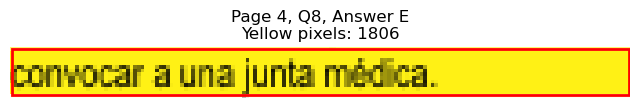


Page 4, Q8 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=156.1, y1=135.6
Page 5, Q1, A: Yellow pixels: 125
Page 5, Q1, A: Total non-white pixels: 507
Page 5, Q1, A: Yellow percentage: 24.7%


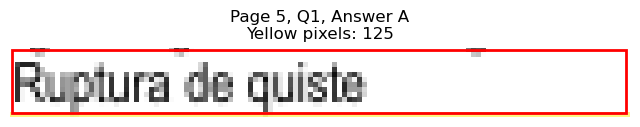

Page 5, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=185.3, y1=148.2
Page 5, Q1, B: Yellow pixels: 1634
Page 5, Q1, B: Total non-white pixels: 2156
Page 5, Q1, B: Yellow percentage: 75.8%


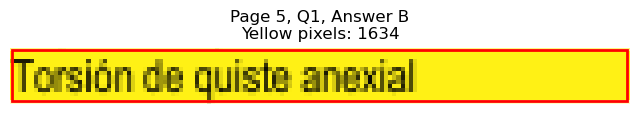

Page 5, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=214.4, y1=160.9
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 878
Page 5, Q1, C: Yellow percentage: 0.0%


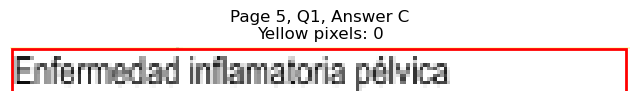

Page 5, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=414.4, y1=135.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 410
Page 5, Q1, D: Yellow percentage: 0.0%


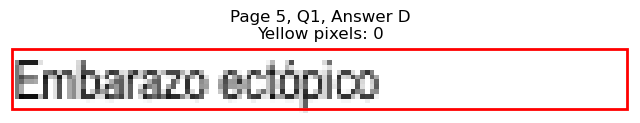

Page 5, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=388.3, y1=148.2
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 279
Page 5, Q1, E: Yellow percentage: 0.0%


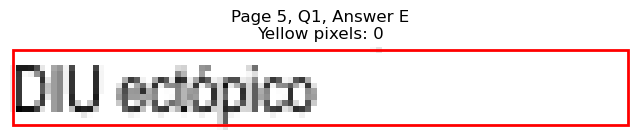


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=153.1, y1=198.7
Page 5, Q2, A: Yellow pixels: 1
Page 5, Q2, A: Total non-white pixels: 492
Page 5, Q2, A: Yellow percentage: 0.2%


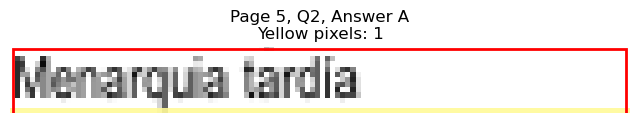

Page 5, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=214.5, y1=211.3
Page 5, Q2, B: Yellow pixels: 1706
Page 5, Q2, B: Total non-white pixels: 2562
Page 5, Q2, B: Yellow percentage: 66.6%


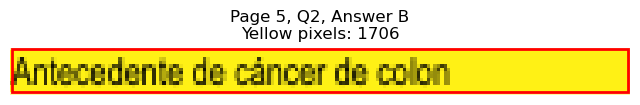

Page 5, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=159.7, y1=224.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 501
Page 5, Q2, C: Yellow percentage: 0.0%


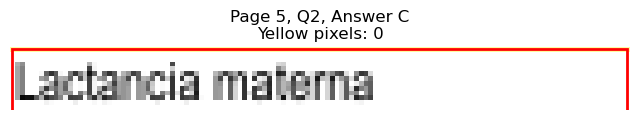

Page 5, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=489.7, y1=198.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 786
Page 5, Q2, D: Yellow percentage: 0.0%


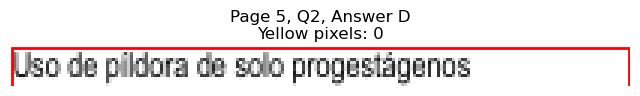

Page 5, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=415.4, y1=211.3
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 432
Page 5, Q2, E: Yellow percentage: 0.0%


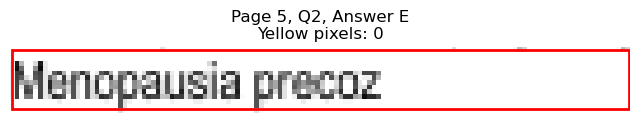


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=177.3, y1=274.4
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 512
Page 5, Q3, A: Yellow percentage: 0.0%


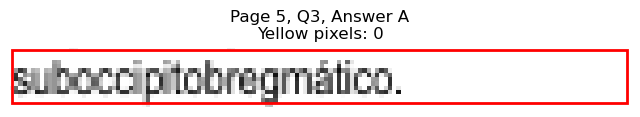

Page 5, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=165.3, y1=287.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 410
Page 5, Q3, B: Yellow percentage: 0.0%


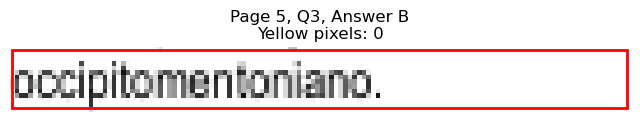

Page 5, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=172.2, y1=299.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 447
Page 5, Q3, C: Yellow percentage: 0.0%


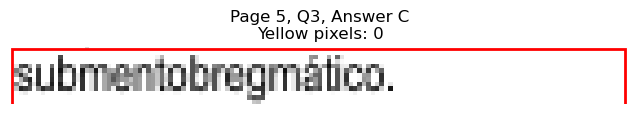

Page 5, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=391.9, y1=274.4
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 299
Page 5, Q3, D: Yellow percentage: 0.0%


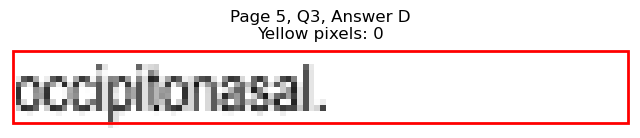

Page 5, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=394.9, y1=287.1
Page 5, Q3, E: Yellow pixels: 1199
Page 5, Q3, E: Total non-white pixels: 1554
Page 5, Q3, E: Yellow percentage: 77.2%


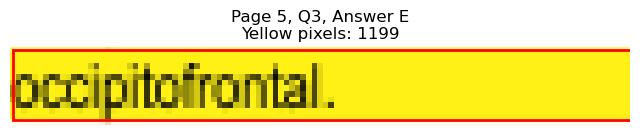


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=115.1, y1=350.1
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 144
Page 5, Q4, A: Yellow percentage: 0.0%


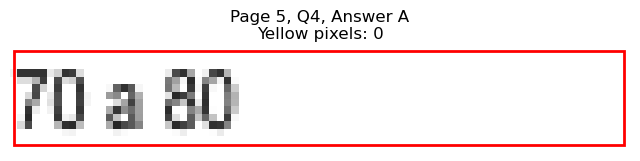

Page 5, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=115.1, y1=362.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 146
Page 5, Q4, B: Yellow percentage: 0.0%


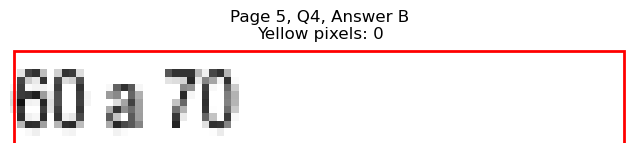

Page 5, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=115.6, y1=375.5
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 154
Page 5, Q4, C: Yellow percentage: 0.0%


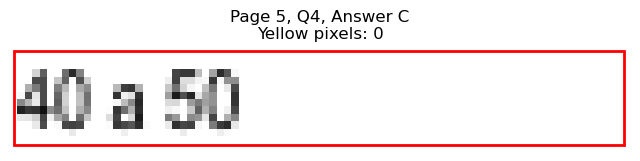

Page 5, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=367.3, y1=350.1
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 153
Page 5, Q4, D: Yellow percentage: 0.0%


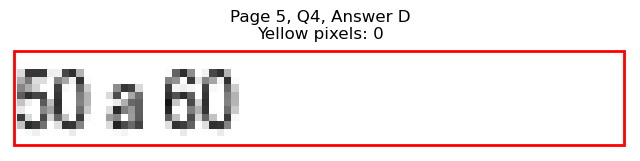

Page 5, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=371.8, y1=362.9
Page 5, Q4, E: Yellow pixels: 1013
Page 5, Q4, E: Total non-white pixels: 1144
Page 5, Q4, E: Yellow percentage: 88.5%


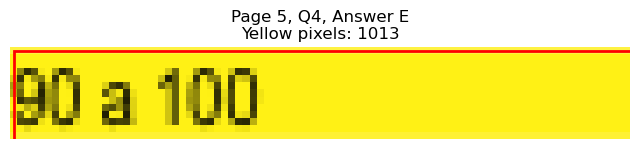


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=162.1, y1=426.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 409
Page 5, Q5, A: Yellow percentage: 0.0%


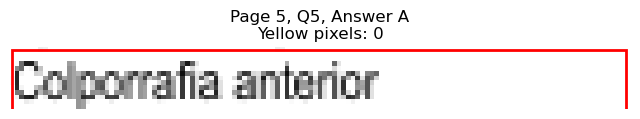

Page 5, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=230.4, y1=438.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 774
Page 5, Q5, B: Yellow percentage: 0.0%


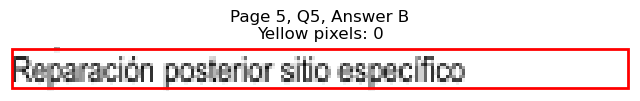

Page 5, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=180.7, y1=451.2
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 527
Page 5, Q5, C: Yellow percentage: 0.0%


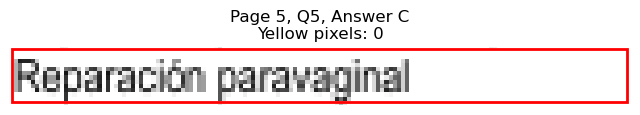

Page 5, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=418.9, y1=426.0
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 569
Page 5, Q5, D: Yellow percentage: 0.0%


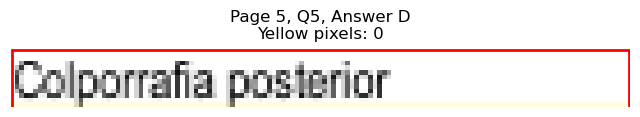

Page 5, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=479.6, y1=438.6
Page 5, Q5, E: Yellow pixels: 1931
Page 5, Q5, E: Total non-white pixels: 2688
Page 5, Q5, E: Yellow percentage: 71.8%


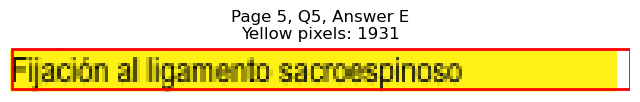


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=476.3, x1=199.4, y1=489.0
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 566
Page 5, Q6, A: Yellow percentage: 0.0%


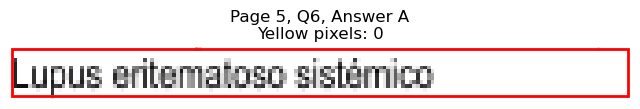

Page 5, Q6 - B: Detected box: x0=82.5, y0=489.1, x1=168.7, y1=501.7
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 467
Page 5, Q6, B: Yellow percentage: 0.0%


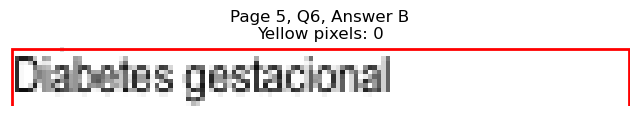

Page 5, Q6 - C: Detected box: x0=82.9, y0=501.7, x1=190.8, y1=514.3
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 544
Page 5, Q6, C: Yellow percentage: 0.0%


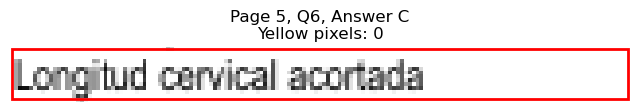

Page 5, Q6 - D: Detected box: x0=334.6, y0=476.3, x1=468.0, y1=489.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 693
Page 5, Q6, D: Yellow percentage: 0.0%


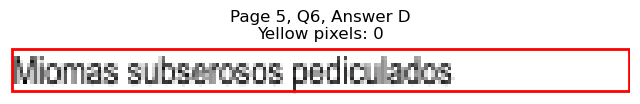

Page 5, Q6 - E: Detected box: x0=334.1, y0=489.1, x1=496.7, y1=501.7
Page 5, Q6, E: Yellow pixels: 1879
Page 5, Q6, E: Total non-white pixels: 2496
Page 5, Q6, E: Yellow percentage: 75.3%


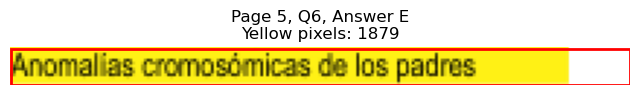


Page 5, Q6 - Selected Answer: E (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=210.9, y1=590.0
Page 5, Q7, A: Yellow pixels: 179
Page 5, Q7, A: Total non-white pixels: 1016
Page 5, Q7, A: Yellow percentage: 17.6%


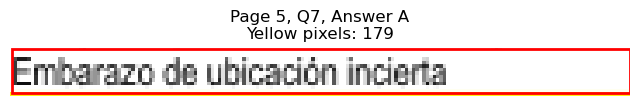

Page 5, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=150.6, y1=602.6
Page 5, Q7, B: Yellow pixels: 1292
Page 5, Q7, B: Total non-white pixels: 1666
Page 5, Q7, B: Yellow percentage: 77.6%


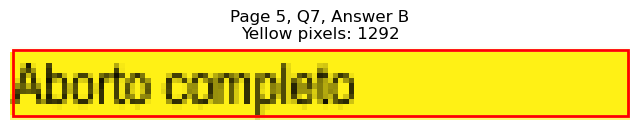

Page 5, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=162.7, y1=615.2
Page 5, Q7, C: Yellow pixels: 131
Page 5, Q7, C: Total non-white pixels: 514
Page 5, Q7, C: Yellow percentage: 25.5%


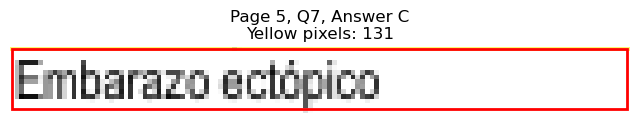

Page 5, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=409.9, y1=590.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 384
Page 5, Q7, D: Yellow percentage: 0.0%


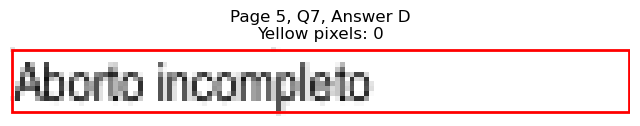

Page 5, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=395.3, y1=602.6
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 311
Page 5, Q7, E: Yellow percentage: 0.0%


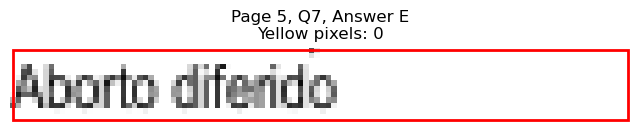


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=123.1, y1=665.8
Page 5, Q8, A: Yellow pixels: 1055
Page 5, Q8, A: Total non-white pixels: 1196
Page 5, Q8, A: Yellow percentage: 88.2%


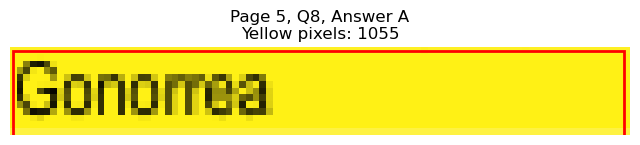

Page 5, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=145.7, y1=678.4
Page 5, Q8, B: Yellow pixels: 114
Page 5, Q8, B: Total non-white pixels: 430
Page 5, Q8, B: Yellow percentage: 26.5%


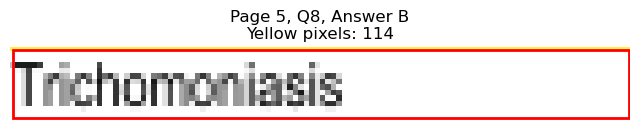

Page 5, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=143.1, y1=691.0
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 299
Page 5, Q8, C: Yellow percentage: 0.0%


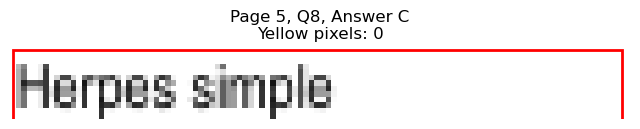

Page 5, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=420.9, y1=665.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 441
Page 5, Q8, D: Yellow percentage: 0.0%


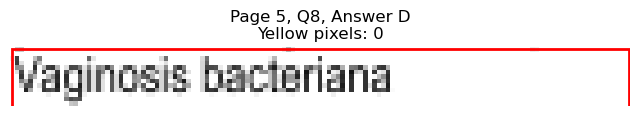

Page 5, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=383.3, y1=678.4
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 274
Page 5, Q8, E: Yellow percentage: 0.0%


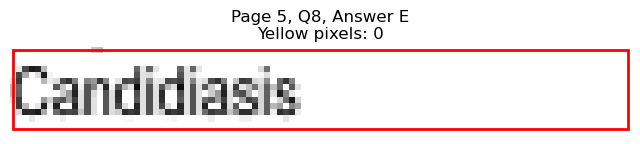


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.5, y0=728.9, x1=141.6, y1=741.5
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 294
Page 5, Q9, A: Yellow percentage: 0.0%


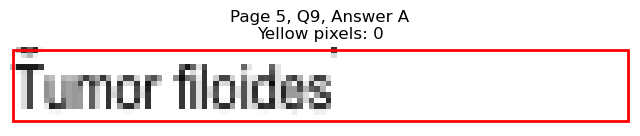

Page 5, Q9 - B: Detected box: x0=82.5, y0=741.4, x1=145.1, y1=754.1
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 326
Page 5, Q9, B: Yellow percentage: 0.0%


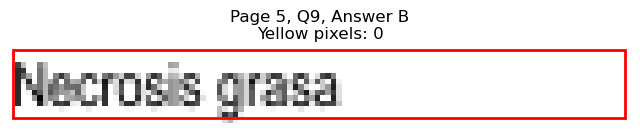

Page 5, Q9 - C: Detected box: x0=82.9, y0=754.0, x1=173.2, y1=766.7
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 470
Page 5, Q9, C: Yellow percentage: 0.0%


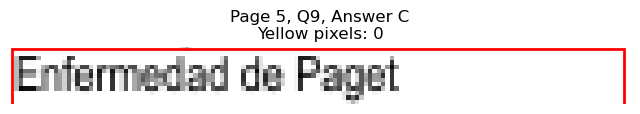

Page 5, Q9 - D: Detected box: x0=334.6, y0=728.9, x1=424.9, y1=741.5
Page 5, Q9, D: Yellow pixels: 1497
Page 5, Q9, D: Total non-white pixels: 1974
Page 5, Q9, D: Yellow percentage: 75.8%


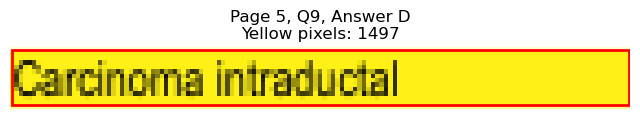

Page 5, Q9 - E: Detected box: x0=334.1, y0=741.4, x1=397.4, y1=754.1
Page 5, Q9, E: Yellow pixels: 114
Page 5, Q9, E: Total non-white pixels: 414
Page 5, Q9, E: Yellow percentage: 27.5%


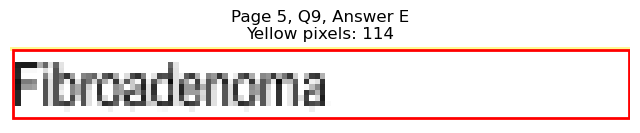


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=143.7, y1=135.6
Page 6, Q1, A: Yellow pixels: 1217
Page 6, Q1, A: Total non-white pixels: 1568
Page 6, Q1, A: Yellow percentage: 77.6%


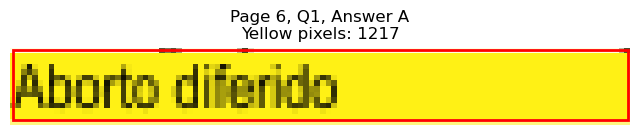

Page 6, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=166.2, y1=148.2
Page 6, Q1, B: Yellow pixels: 135
Page 6, Q1, B: Total non-white pixels: 577
Page 6, Q1, B: Yellow percentage: 23.4%


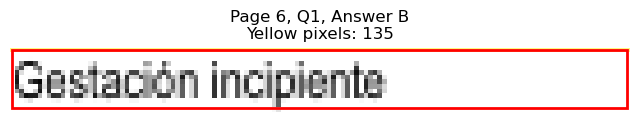

Page 6, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=152.7, y1=160.9
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 377
Page 6, Q1, C: Yellow percentage: 0.0%


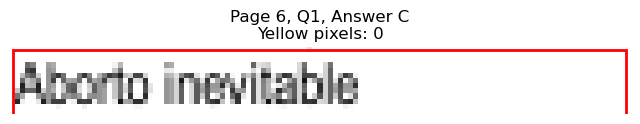

Page 6, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=410.8, y1=135.6
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 376
Page 6, Q1, D: Yellow percentage: 0.0%


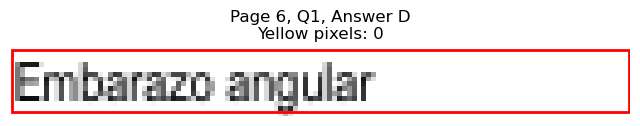

Page 6, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=415.4, y1=148.2
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 385
Page 6, Q1, E: Yellow percentage: 0.0%


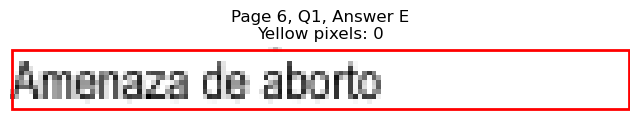


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=230.9, y1=198.7
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 747
Page 6, Q2, A: Yellow percentage: 0.0%


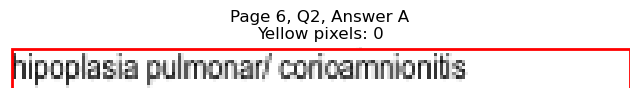

Page 6, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=213.4, y1=211.3
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 652
Page 6, Q2, B: Yellow percentage: 0.0%


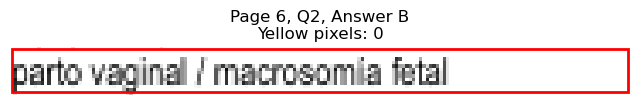

Page 6, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=202.4, y1=224.0
Page 6, Q2, C: Yellow pixels: 1775
Page 6, Q2, C: Total non-white pixels: 2223
Page 6, Q2, C: Yellow percentage: 79.8%


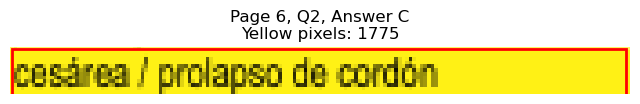

Page 6, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=457.5, y1=198.7
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 612
Page 6, Q2, D: Yellow percentage: 0.0%


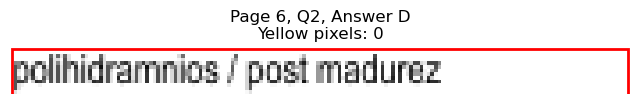

Page 6, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=483.6, y1=211.3
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 758
Page 6, Q2, E: Yellow percentage: 0.0%


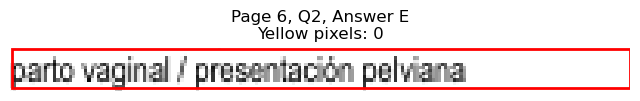


Page 6, Q2 - Selected Answer: C (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=128.5, y1=287.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 225
Page 6, Q3, A: Yellow percentage: 0.0%


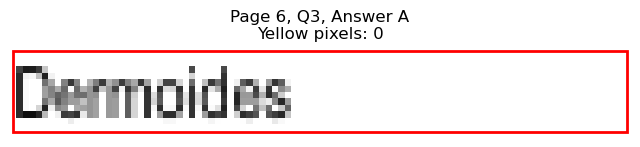

Page 6, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=128.1, y1=299.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 221
Page 6, Q3, B: Yellow percentage: 0.0%


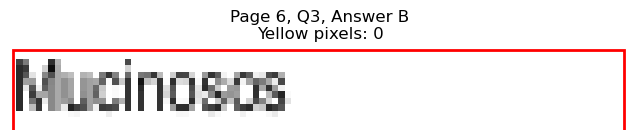

Page 6, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=148.1, y1=312.3
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 357
Page 6, Q3, C: Yellow percentage: 0.0%


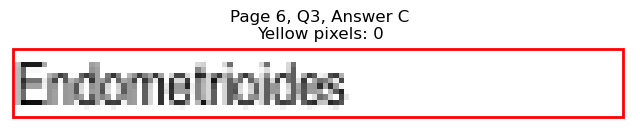

Page 6, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=378.3, y1=287.1
Page 6, Q3, D: Yellow pixels: 95
Page 6, Q3, D: Total non-white pixels: 349
Page 6, Q3, D: Yellow percentage: 27.2%


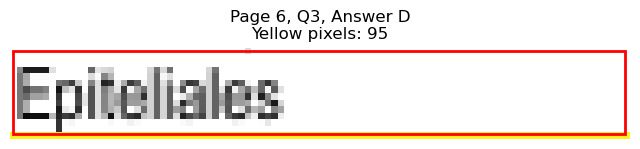

Page 6, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=397.4, y1=299.7
Page 6, Q3, E: Yellow pixels: 1248
Page 6, Q3, E: Total non-white pixels: 1482
Page 6, Q3, E: Yellow percentage: 84.2%


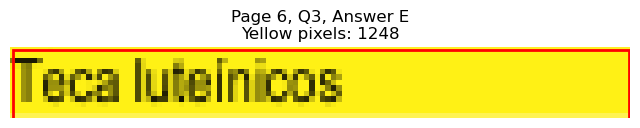


Page 6, Q3 - Selected Answer: E (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=70.8, y0=362.8, x1=79.3, y1=375.5
Page 6, Q4, A: Yellow pixels: 732
Page 6, Q4, A: Total non-white pixels: 840
Page 6, Q4, A: Yellow percentage: 87.1%


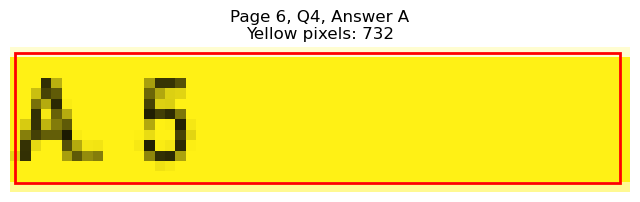

Page 6, Q4 - B: Detected box: x0=70.8, y0=375.4, x1=79.3, y1=388.1
Page 6, Q4, B: Yellow pixels: 60
Page 6, Q4, B: Total non-white pixels: 131
Page 6, Q4, B: Yellow percentage: 45.8%


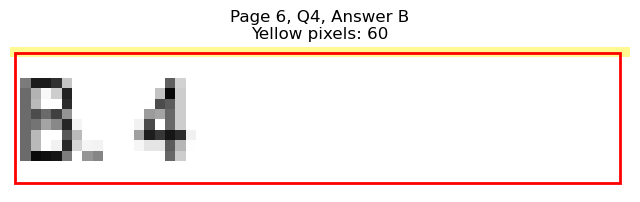

Page 6, Q4 - C: Detected box: x0=70.8, y0=388.0, x1=79.8, y1=400.7
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 66
Page 6, Q4, C: Yellow percentage: 0.0%


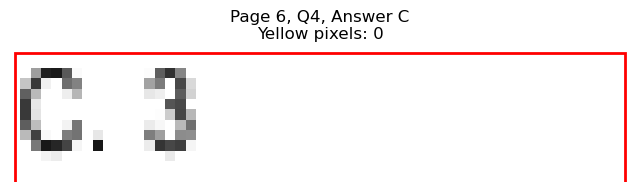

Page 6, Q4 - D: Detected box: x0=322.5, y0=362.8, x1=331.5, y1=375.5
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 66
Page 6, Q4, D: Yellow percentage: 0.0%


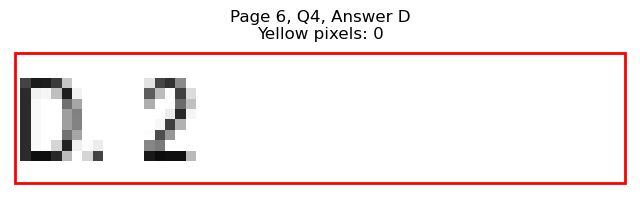

Page 6, Q4 - E: Detected box: x0=322.5, y0=375.4, x1=331.0, y1=388.1
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 54
Page 6, Q4, E: Yellow percentage: 0.0%


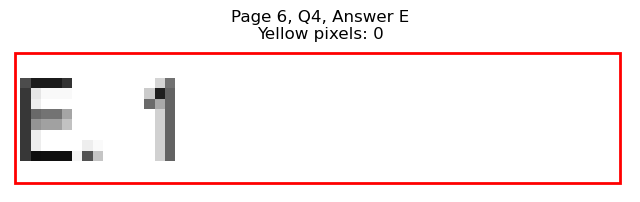


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=93.5, y1=463.8
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 45
Page 6, Q5, A: Yellow percentage: 0.0%


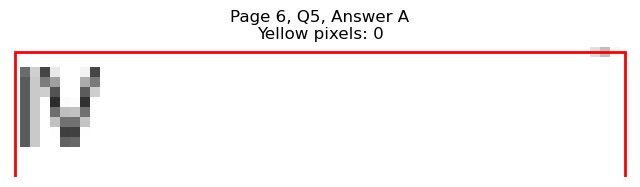

Page 6, Q5 - B: Detected box: x0=70.8, y0=463.7, x1=79.3, y1=476.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 73
Page 6, Q5, B: Yellow percentage: 0.0%


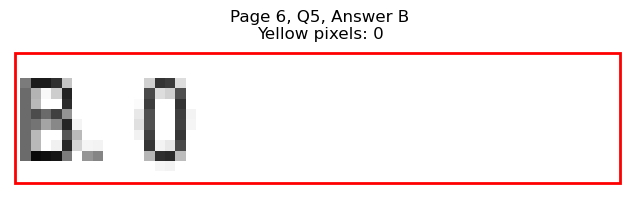

Page 6, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=93.0, y1=489.0
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 48
Page 6, Q5, C: Yellow percentage: 0.0%


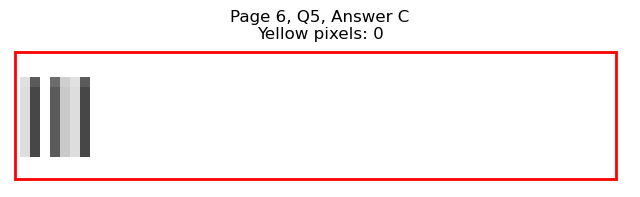

Page 6, Q5 - D: Detected box: x0=322.5, y0=451.1, x1=331.5, y1=463.8
Page 6, Q5, D: Yellow pixels: 726
Page 6, Q5, D: Total non-white pixels: 780
Page 6, Q5, D: Yellow percentage: 93.1%


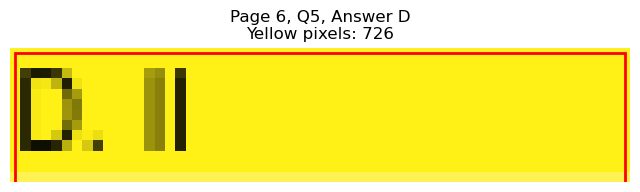

Page 6, Q5 - E: Detected box: x0=322.5, y0=463.7, x1=331.0, y1=476.4
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 44
Page 6, Q5, E: Yellow percentage: 0.0%


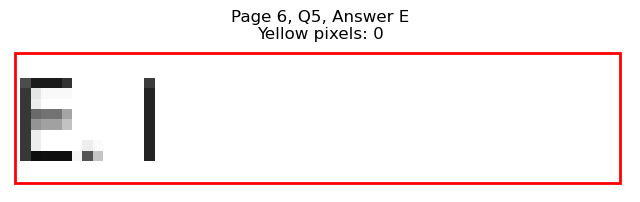


Page 6, Q5 - Selected Answer: D (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=123.1, y1=552.1
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 211
Page 6, Q6, A: Yellow percentage: 0.0%


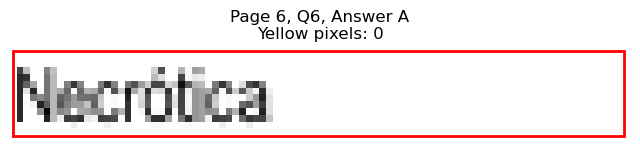

Page 6, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=103.6, y1=564.8
Page 6, Q6, B: Yellow pixels: 846
Page 6, Q6, B: Total non-white pixels: 936
Page 6, Q6, B: Yellow percentage: 90.4%


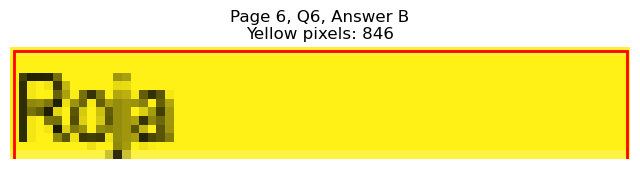

Page 6, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=113.1, y1=577.4
Page 6, Q6, C: Yellow pixels: 79
Page 6, Q6, C: Total non-white pixels: 212
Page 6, Q6, C: Yellow percentage: 37.3%


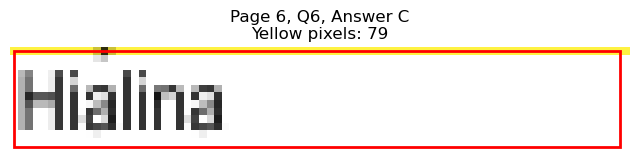

Page 6, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=385.7, y1=552.1
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 258
Page 6, Q6, D: Yellow percentage: 0.0%


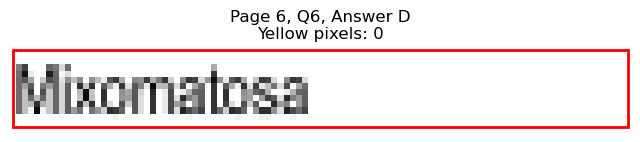

Page 6, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=389.8, y1=564.8
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 277
Page 6, Q6, E: Yellow percentage: 0.0%


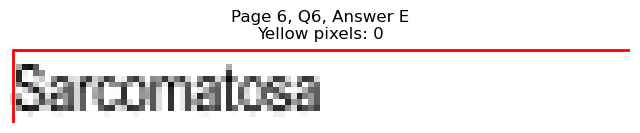


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=181.7, y0=615.2, x1=249.0, y1=627.8
Page 6, Q7, A: Yellow pixels: 878
Page 6, Q7, A: Total non-white pixels: 1225
Page 6, Q7, A: Yellow percentage: 71.7%


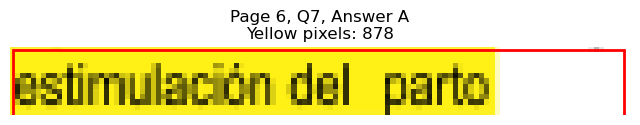

Page 6, Q7 - B: Detected box: x0=82.5, y0=640.5, x1=269.6, y1=653.2
Page 6, Q7, B: Yellow pixels: 190
Page 6, Q7, B: Total non-white pixels: 1107
Page 6, Q7, B: Yellow percentage: 17.2%


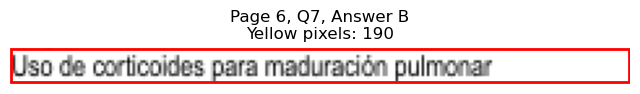

Page 6, Q7 - C: Detected box: x0=82.9, y0=653.1, x1=156.6, y1=665.8
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 364
Page 6, Q7, C: Yellow percentage: 0.0%


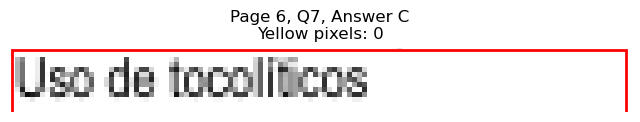

Page 6, Q7 - D: Detected box: x0=387.7, y0=615.2, x1=457.0, y1=627.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 573
Page 6, Q7, D: Yellow percentage: 0.0%


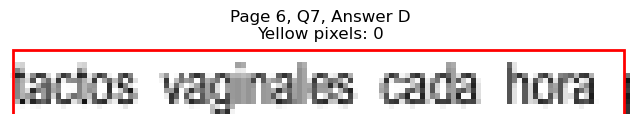

Page 6, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=448.0, y1=653.2
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 577
Page 6, Q7, E: Yellow percentage: 0.0%


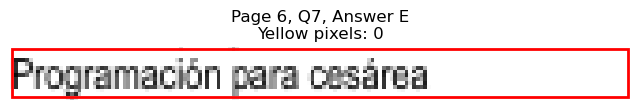


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=190.2, y1=716.3
Page 6, Q8, A: Yellow pixels: 159
Page 6, Q8, A: Total non-white pixels: 720
Page 6, Q8, A: Yellow percentage: 22.1%


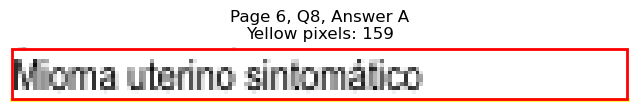

Page 6, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=151.2, y1=728.9
Page 6, Q8, B: Yellow pixels: 1313
Page 6, Q8, B: Total non-white pixels: 1560
Page 6, Q8, B: Yellow percentage: 84.2%


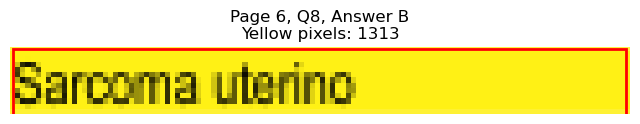

Page 6, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=157.2, y1=741.5
Page 6, Q8, C: Yellow pixels: 126
Page 6, Q8, C: Total non-white pixels: 473
Page 6, Q8, C: Yellow percentage: 26.6%


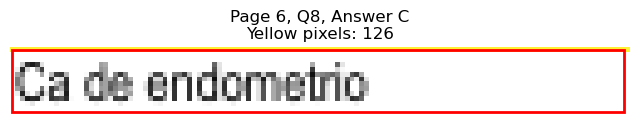

Page 6, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=387.3, y1=716.3
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 242
Page 6, Q8, D: Yellow percentage: 0.0%


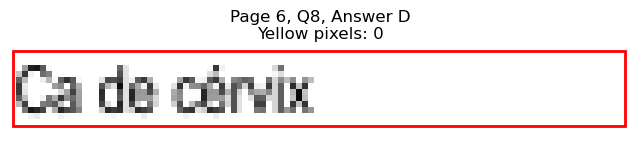

Page 6, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=387.8, y1=728.9
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 238
Page 6, Q8, E: Yellow percentage: 0.0%


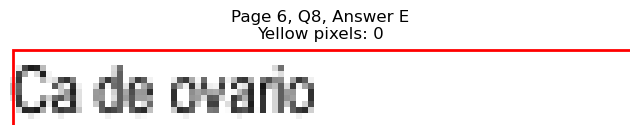


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=245.9, y1=110.4
Page 7, Q1, A: Yellow pixels: 192
Page 7, Q1, A: Total non-white pixels: 1041
Page 7, Q1, A: Yellow percentage: 18.4%


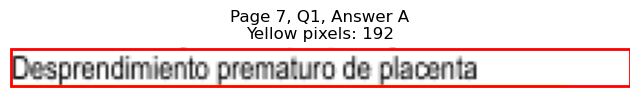

Page 7, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=237.4, y1=123.0
Page 7, Q1, B: Yellow pixels: 1862
Page 7, Q1, B: Total non-white pixels: 2509
Page 7, Q1, B: Yellow percentage: 74.2%


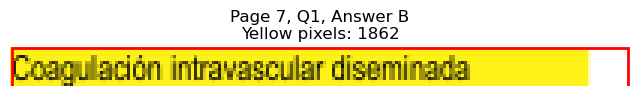

Page 7, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=140.1, y1=135.6
Page 7, Q1, C: Yellow pixels: 105
Page 7, Q1, C: Total non-white pixels: 403
Page 7, Q1, C: Yellow percentage: 26.1%


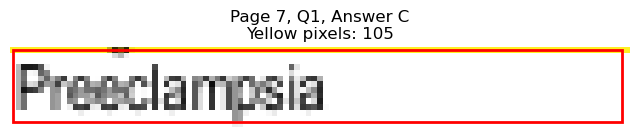

Page 7, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=409.9, y1=110.4
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 370
Page 7, Q1, D: Yellow percentage: 0.0%


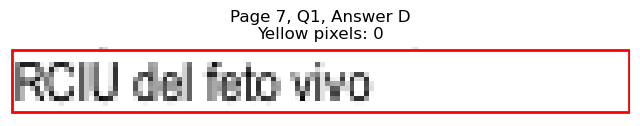

Page 7, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=434.5, y1=123.0
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 517
Page 7, Q1, E: Yellow percentage: 0.0%


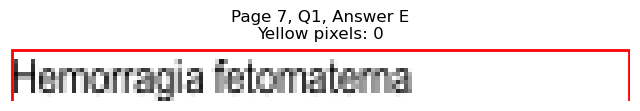


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=139.6, y1=173.5
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 306
Page 7, Q2, A: Yellow percentage: 0.0%


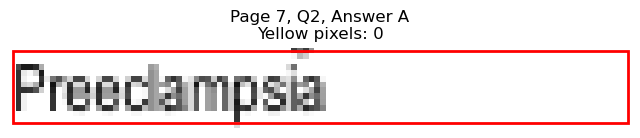

Page 7, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=142.1, y1=186.1
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 286
Page 7, Q2, B: Yellow percentage: 0.0%


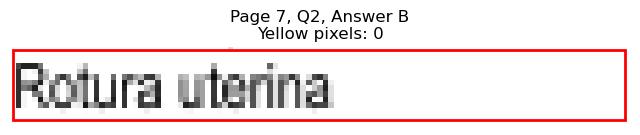

Page 7, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=130.1, y1=198.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 224
Page 7, Q2, C: Yellow percentage: 0.0%


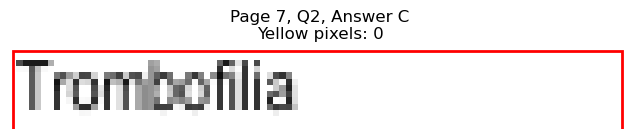

Page 7, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=427.4, y1=173.5
Page 7, Q2, D: Yellow pixels: 1472
Page 7, Q2, D: Total non-white pixels: 2016
Page 7, Q2, D: Yellow percentage: 73.0%


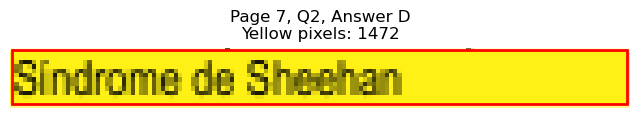

Page 7, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=410.3, y1=186.1
Page 7, Q2, E: Yellow pixels: 127
Page 7, Q2, E: Total non-white pixels: 527
Page 7, Q2, E: Yellow percentage: 24.1%


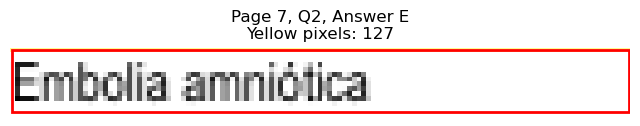


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=277.5, y1=249.2
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 947
Page 7, Q3, A: Yellow percentage: 0.0%


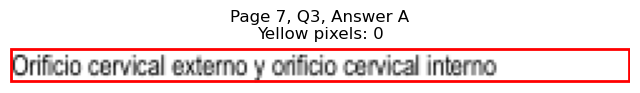

Page 7, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=283.6, y1=261.8
Page 7, Q3, B: Yellow pixels: 1
Page 7, Q3, B: Total non-white pixels: 1226
Page 7, Q3, B: Yellow percentage: 0.1%


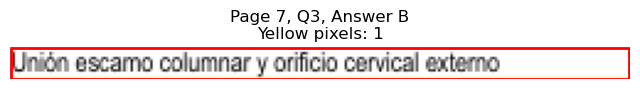

Page 7, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=325.7, y1=274.4
Page 7, Q3, C: Yellow pixels: 2899
Page 7, Q3, C: Total non-white pixels: 4116
Page 7, Q3, C: Yellow percentage: 70.4%


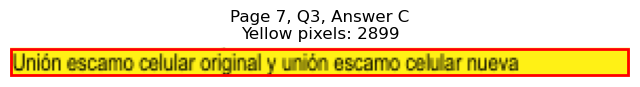

Page 7, Q3 - D: Detected box: x0=82.9, y0=274.5, x1=307.6, y1=287.1
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 1072
Page 7, Q3, D: Yellow percentage: 0.0%


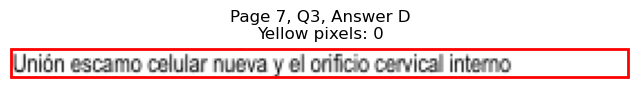

Page 7, Q3 - E: Detected box: x0=82.5, y0=287.1, x1=300.6, y1=299.7
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 1037
Page 7, Q3, E: Yellow percentage: 0.0%


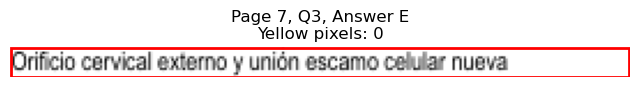


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=116.9, y0=337.5, x1=165.4, y1=350.1
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 434
Page 7, Q4, A: Yellow percentage: 0.0%


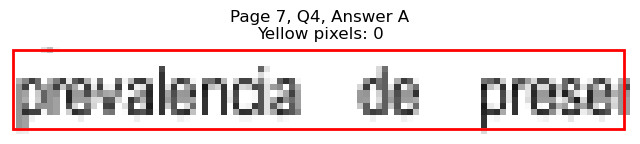

Page 7, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=238.5, y1=375.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 777
Page 7, Q4, B: Yellow percentage: 0.0%


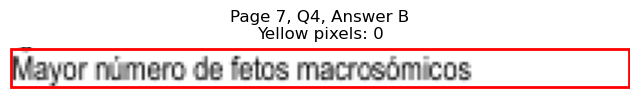

Page 7, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=241.5, y1=388.1
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 830
Page 7, Q4, C: Yellow percentage: 0.0%


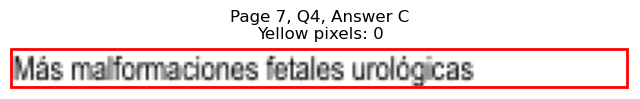

Page 7, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=446.9, y1=350.1
Page 7, Q4, D: Yellow pixels: 1689
Page 7, Q4, D: Total non-white pixels: 2282
Page 7, Q4, D: Yellow percentage: 74.0%


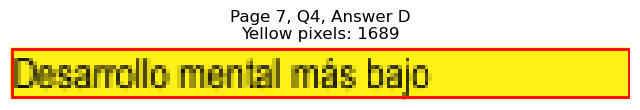

Page 7, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=471.1, y1=362.9
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 880
Page 7, Q4, E: Yellow percentage: 0.0%


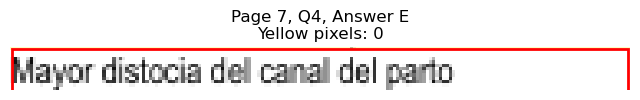


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=121.1, y1=438.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 164
Page 7, Q5, A: Yellow percentage: 0.0%


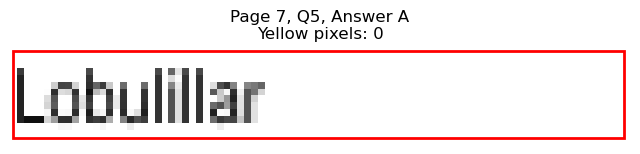

Page 7, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=115.6, y1=451.2
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 168
Page 7, Q5, B: Yellow percentage: 0.0%


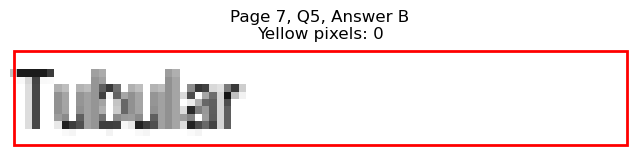

Page 7, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=124.1, y1=463.8
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 204
Page 7, Q5, C: Yellow percentage: 0.0%


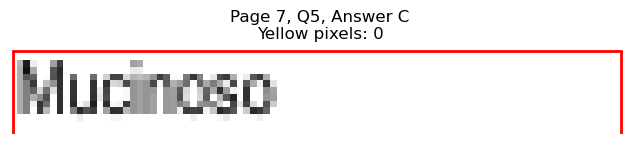

Page 7, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=362.7, y1=438.6
Page 7, Q5, D: Yellow pixels: 902
Page 7, Q5, D: Total non-white pixels: 1106
Page 7, Q5, D: Yellow percentage: 81.6%


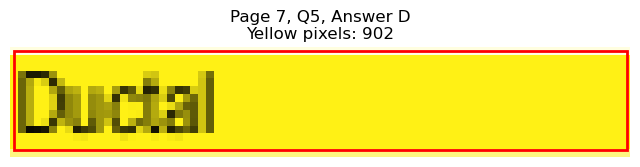

Page 7, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=369.3, y1=451.2
Page 7, Q5, E: Yellow pixels: 86
Page 7, Q5, E: Total non-white pixels: 283
Page 7, Q5, E: Yellow percentage: 30.4%


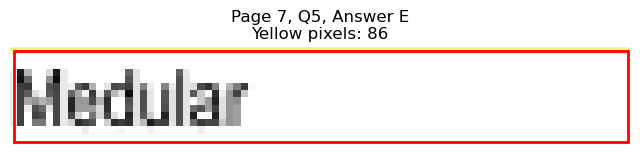


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=514.3, x1=130.1, y1=526.9
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 261
Page 7, Q6, A: Yellow percentage: 0.0%


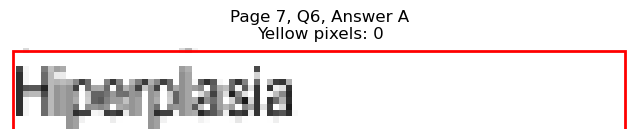

Page 7, Q6 - B: Detected box: x0=82.5, y0=526.9, x1=121.6, y1=539.5
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 217
Page 7, Q6, B: Yellow percentage: 0.0%


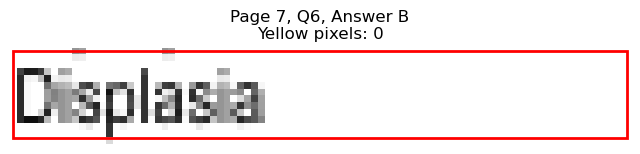

Page 7, Q6 - C: Detected box: x0=82.9, y0=539.5, x1=114.5, y1=552.1
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 146
Page 7, Q6, C: Yellow percentage: 0.0%


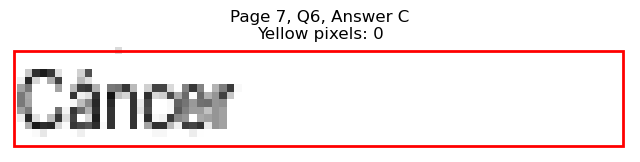

Page 7, Q6 - D: Detected box: x0=334.6, y0=514.3, x1=362.2, y1=526.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 223
Page 7, Q6, D: Yellow percentage: 0.0%


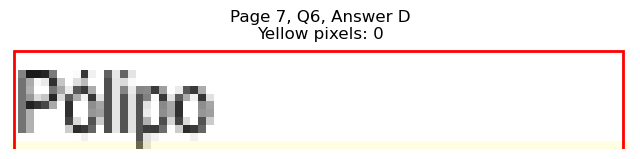

Page 7, Q6 - E: Detected box: x0=334.1, y0=526.9, x1=362.7, y1=539.5
Page 7, Q6, E: Yellow pixels: 910
Page 7, Q6, E: Total non-white pixels: 1106
Page 7, Q6, E: Yellow percentage: 82.3%


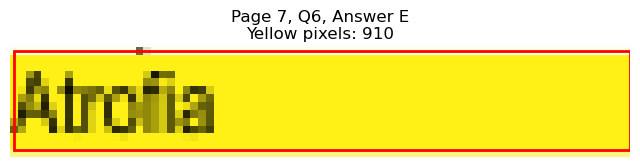


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=257.0, y1=615.2
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 878
Page 7, Q7, A: Yellow percentage: 0.0%


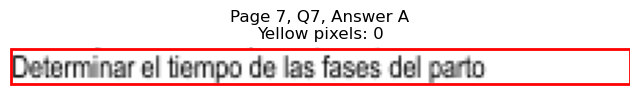

Page 7, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=219.4, y1=627.8
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 664
Page 7, Q7, B: Yellow percentage: 0.0%


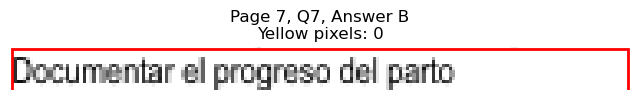

Page 7, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=275.3, y1=640.6
Page 7, Q7, C: Yellow pixels: 1761
Page 7, Q7, C: Total non-white pixels: 2702
Page 7, Q7, C: Yellow percentage: 65.2%


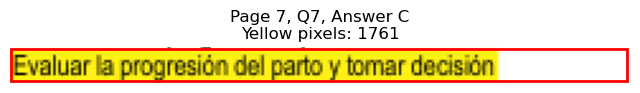

Page 7, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=522.2, y1=615.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 893
Page 7, Q7, D: Yellow percentage: 0.0%


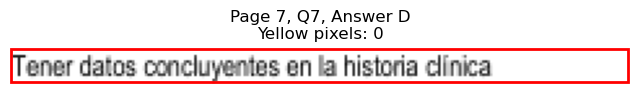

Page 7, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=401.0, y1=627.8
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 595
Page 7, Q7, E: Yellow percentage: 0.0%


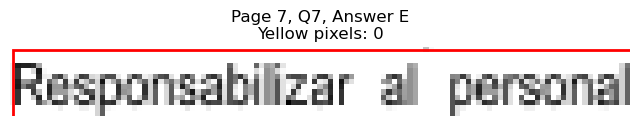


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=161.2, y1=703.7
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 393
Page 7, Q8, A: Yellow percentage: 0.0%


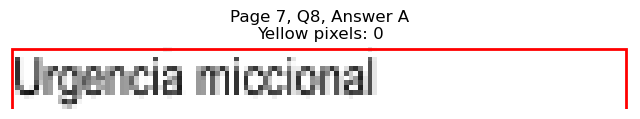

Page 7, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=220.5, y1=716.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 688
Page 7, Q8, B: Yellow percentage: 0.0%


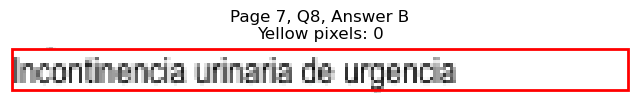

Page 7, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=186.3, y1=728.9
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 536
Page 7, Q8, C: Yellow percentage: 0.0%


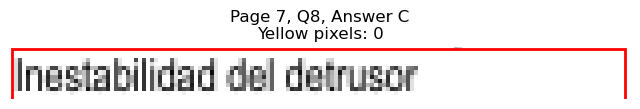

Page 7, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=507.2, y1=703.7
Page 7, Q8, D: Yellow pixels: 2
Page 7, Q8, D: Total non-white pixels: 1023
Page 7, Q8, D: Yellow percentage: 0.2%


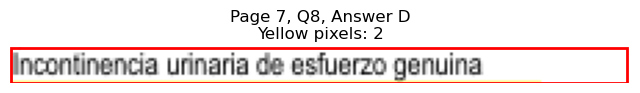

Page 7, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=444.0, y1=716.3
Page 7, Q8, E: Yellow pixels: 1506
Page 7, Q8, E: Total non-white pixels: 2254
Page 7, Q8, E: Yellow percentage: 66.8%


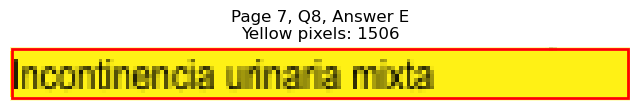


Page 7, Q8 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=184.2, y1=135.6
Page 8, Q1, A: Yellow pixels: 1580
Page 8, Q1, A: Total non-white pixels: 2142
Page 8, Q1, A: Yellow percentage: 73.8%


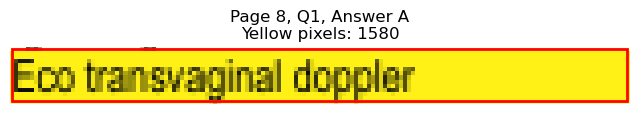

Page 8, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=131.1, y1=148.2
Page 8, Q1, B: Yellow pixels: 99
Page 8, Q1, B: Total non-white pixels: 338
Page 8, Q1, B: Yellow percentage: 29.3%


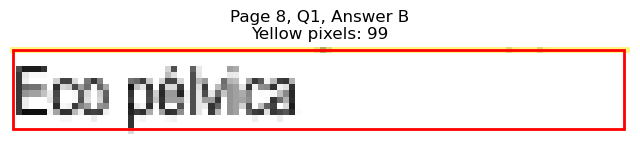

Page 8, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=152.2, y1=160.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 354
Page 8, Q1, C: Yellow percentage: 0.0%


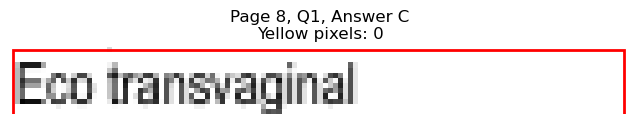

Page 8, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=444.4, y1=135.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 530
Page 8, Q1, D: Yellow percentage: 0.0%


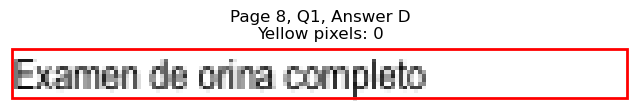

Page 8, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=407.5, y1=148.2
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 377
Page 8, Q1, E: Yellow percentage: 0.0%


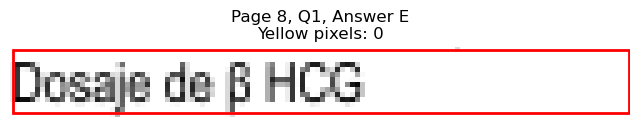


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=251.9, y1=198.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 862
Page 8, Q2, A: Yellow percentage: 0.0%


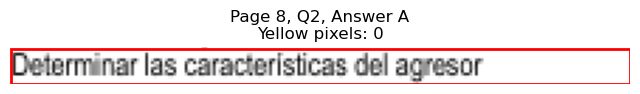

Page 8, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=192.7, y1=211.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 582
Page 8, Q2, B: Yellow percentage: 0.0%


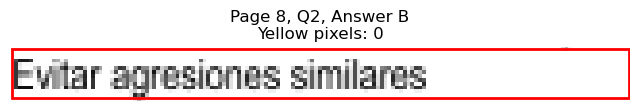

Page 8, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=198.3, y1=224.0
Page 8, Q2, C: Yellow pixels: 1739
Page 8, Q2, C: Total non-white pixels: 2171
Page 8, Q2, C: Yellow percentage: 80.1%


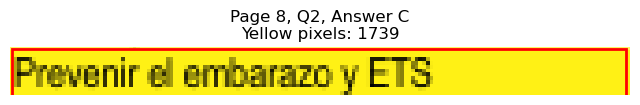

Page 8, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=472.1, y1=198.7
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 699
Page 8, Q2, D: Yellow percentage: 0.0%


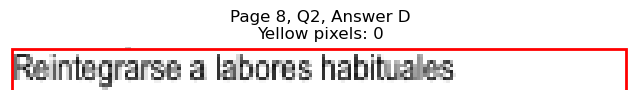

Page 8, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=471.1, y1=211.3
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 679
Page 8, Q2, E: Yellow percentage: 0.0%


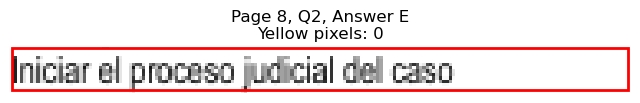


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=150.1, y1=274.4
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 365
Page 8, Q3, A: Yellow percentage: 0.0%


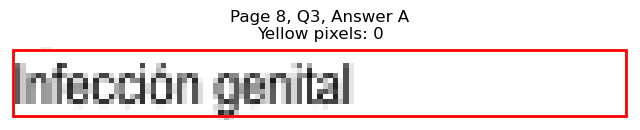

Page 8, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=159.1, y1=287.1
Page 8, Q3, B: Yellow pixels: 1356
Page 8, Q3, B: Total non-white pixels: 1792
Page 8, Q3, B: Yellow percentage: 75.7%


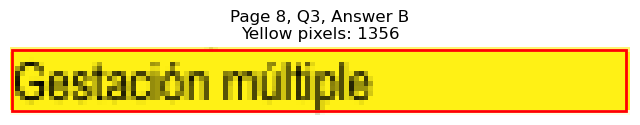

Page 8, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=227.4, y1=299.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 905
Page 8, Q3, C: Yellow percentage: 0.0%


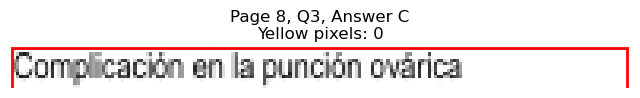

Page 8, Q3 - D: Detected box: x0=334.6, y0=261.7, x1=449.0, y1=274.4
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 552
Page 8, Q3, D: Yellow percentage: 0.0%


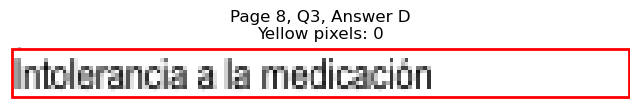

Page 8, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=461.1, y1=287.1
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 616
Page 8, Q3, E: Yellow percentage: 0.0%


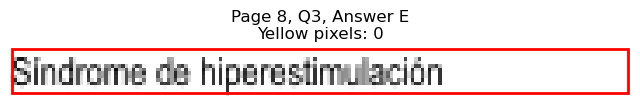


Page 8, Q3 - Selected Answer: B (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=180.7, y1=350.1
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 532
Page 8, Q4, A: Yellow percentage: 0.0%


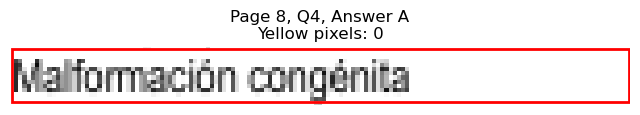

Page 8, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=154.7, y1=362.9
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 375
Page 8, Q4, B: Yellow percentage: 0.0%


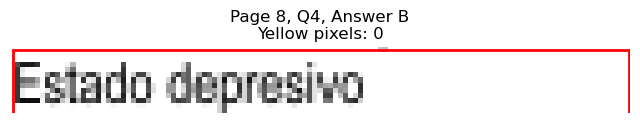

Page 8, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=150.6, y1=375.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 351
Page 8, Q4, C: Yellow percentage: 0.0%


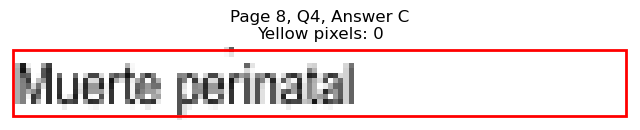

Page 8, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=429.9, y1=350.1
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 493
Page 8, Q4, D: Yellow percentage: 0.0%


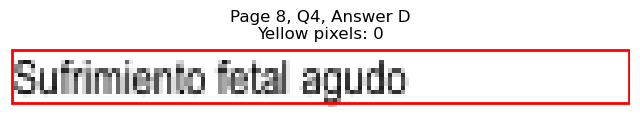

Page 8, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=492.2, y1=362.9
Page 8, Q4, E: Yellow pixels: 1902
Page 8, Q4, E: Total non-white pixels: 2496
Page 8, Q4, E: Yellow percentage: 76.2%


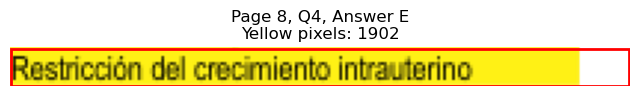


Page 8, Q4 - Selected Answer: E (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=70.8, y0=425.9, x1=79.3, y1=438.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 57
Page 8, Q5, A: Yellow percentage: 0.0%


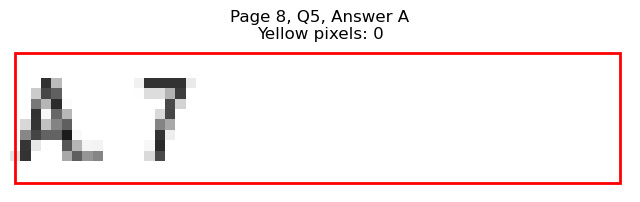

Page 8, Q5 - B: Detected box: x0=70.8, y0=438.5, x1=79.3, y1=451.2
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 75
Page 8, Q5, B: Yellow percentage: 0.0%


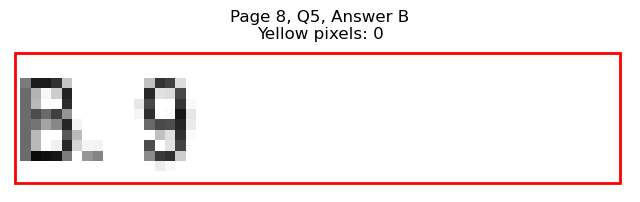

Page 8, Q5 - C: Detected box: x0=70.8, y0=451.1, x1=79.8, y1=463.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 66
Page 8, Q5, C: Yellow percentage: 0.0%


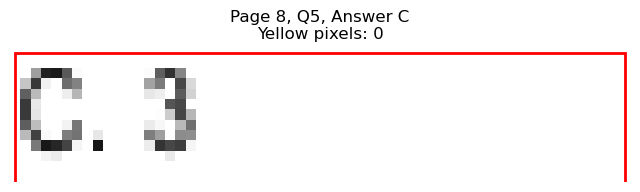

Page 8, Q5 - D: Detected box: x0=322.5, y0=425.9, x1=331.5, y1=438.6
Page 8, Q5, D: Yellow pixels: 60
Page 8, Q5, D: Total non-white pixels: 133
Page 8, Q5, D: Yellow percentage: 45.1%


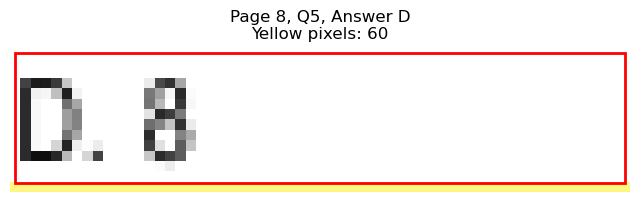

Page 8, Q5 - E: Detected box: x0=322.5, y0=438.5, x1=331.0, y1=451.2
Page 8, Q5, E: Yellow pixels: 727
Page 8, Q5, E: Total non-white pixels: 840
Page 8, Q5, E: Yellow percentage: 86.5%


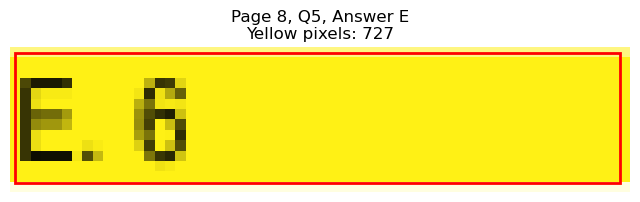


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=129.6, y1=501.7
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 227
Page 8, Q6, A: Yellow percentage: 0.0%


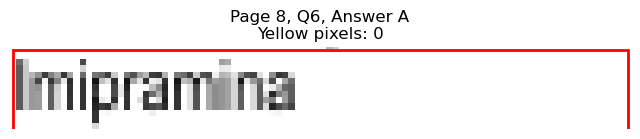

Page 8, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=143.7, y1=514.3
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 324
Page 8, Q6, B: Yellow percentage: 0.0%


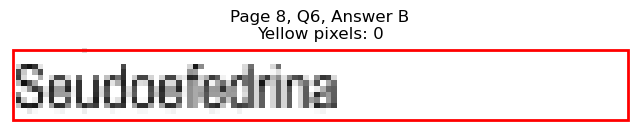

Page 8, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=133.6, y1=526.9
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 278
Page 8, Q6, C: Yellow percentage: 0.0%


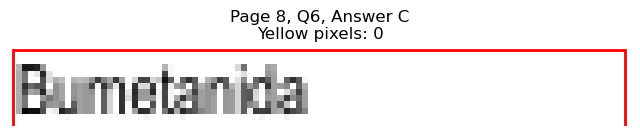

Page 8, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=371.7, y1=501.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 269
Page 8, Q6, D: Yellow percentage: 0.0%


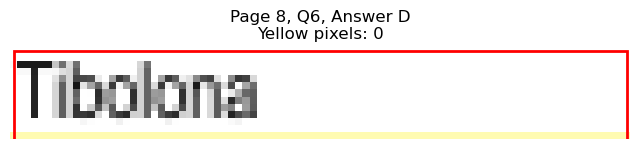

Page 8, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=381.8, y1=514.3
Page 8, Q6, E: Yellow pixels: 979
Page 8, Q6, E: Total non-white pixels: 1372
Page 8, Q6, E: Yellow percentage: 71.4%


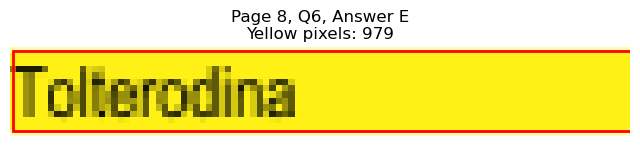


Page 8, Q6 - Selected Answer: E (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=564.8, x1=131.1, y1=577.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 247
Page 8, Q7, A: Yellow percentage: 0.0%


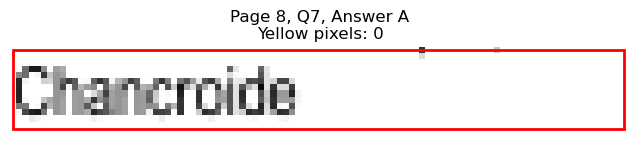

Page 8, Q7 - B: Detected box: x0=82.5, y0=577.4, x1=182.4, y1=590.0
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 487
Page 8, Q7, B: Yellow percentage: 0.0%


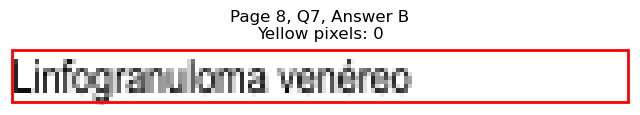

Page 8, Q7 - C: Detected box: x0=82.9, y0=590.0, x1=143.1, y1=602.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 314
Page 8, Q7, C: Yellow percentage: 0.0%


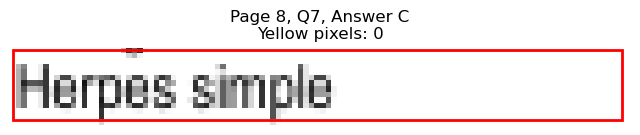

Page 8, Q7 - D: Detected box: x0=334.6, y0=564.8, x1=356.7, y1=577.4
Page 8, Q7, D: Yellow pixels: 799
Page 8, Q7, D: Total non-white pixels: 1022
Page 8, Q7, D: Yellow percentage: 78.2%


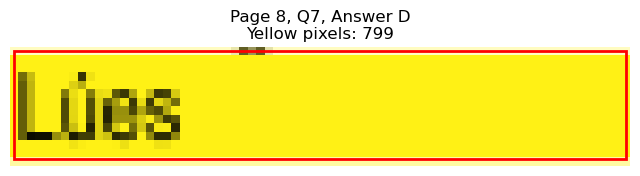

Page 8, Q7 - E: Detected box: x0=334.1, y0=577.4, x1=371.8, y1=590.0
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 305
Page 8, Q7, E: Yellow percentage: 0.0%


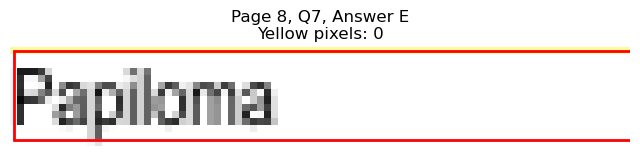


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=665.7, x1=236.9, y1=678.4
Page 8, Q8, A: Yellow pixels: 192
Page 8, Q8, A: Total non-white pixels: 952
Page 8, Q8, A: Yellow percentage: 20.2%


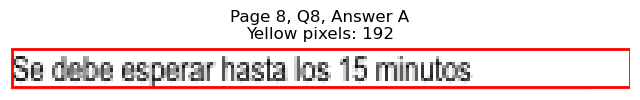

Page 8, Q8 - B: Detected box: x0=82.5, y0=678.3, x1=224.9, y1=691.0
Page 8, Q8, B: Yellow pixels: 1926
Page 8, Q8, B: Total non-white pixels: 2509
Page 8, Q8, B: Yellow percentage: 76.8%


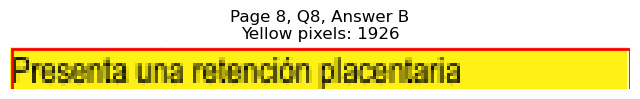

Page 8, Q8 - C: Detected box: x0=82.9, y0=691.1, x1=219.4, y1=703.7
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 848
Page 8, Q8, C: Yellow percentage: 0.0%


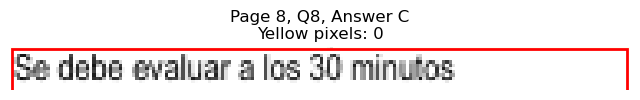

Page 8, Q8 - D: Detected box: x0=422.9, y0=665.7, x1=470.4, y1=678.4
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 441
Page 8, Q8, D: Yellow percentage: 0.0%


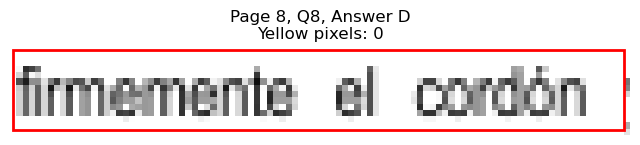

Page 8, Q8 - E: Detected box: x0=334.1, y0=691.1, x1=508.2, y1=703.7
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 842
Page 8, Q8, E: Yellow percentage: 0.0%


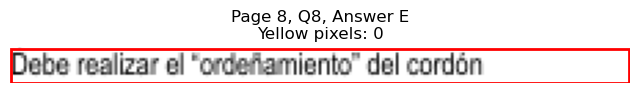


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.5, y0=728.9, x1=175.7, y1=741.5
Page 8, Q9, A: Yellow pixels: 144
Page 8, Q9, A: Total non-white pixels: 644
Page 8, Q9, A: Yellow percentage: 22.4%


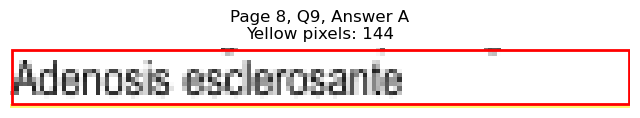

Page 8, Q9 - B: Detected box: x0=82.5, y0=741.4, x1=185.8, y1=754.1
Page 8, Q9, B: Yellow pixels: 1552
Page 8, Q9, B: Total non-white pixels: 2156
Page 8, Q9, B: Yellow percentage: 72.0%


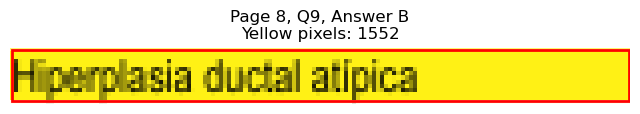

Page 8, Q9 - C: Detected box: x0=82.9, y0=754.0, x1=182.2, y1=766.7
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 639
Page 8, Q9, C: Yellow percentage: 0.0%


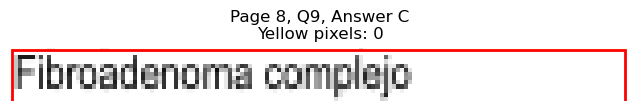

Page 8, Q9 - D: Detected box: x0=334.6, y0=728.9, x1=428.3, y1=741.5
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 489
Page 8, Q9, D: Yellow percentage: 0.0%


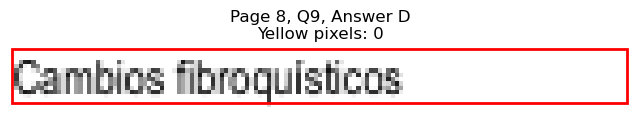

Page 8, Q9 - E: Detected box: x0=334.1, y0=741.4, x1=392.8, y1=754.1
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 312
Page 8, Q9, E: Yellow percentage: 0.0%


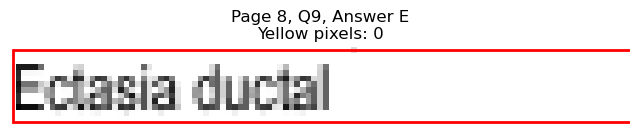


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=70.8, y0=122.9, x1=79.3, y1=135.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 59
Page 9, Q1, A: Yellow percentage: 0.0%


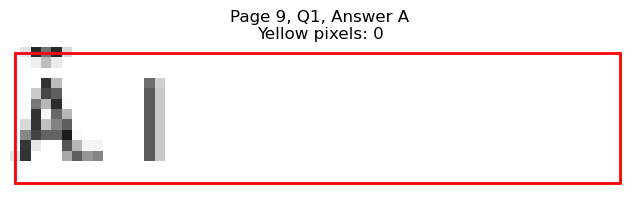

Page 9, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=109.1, y1=148.2
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 127
Page 9, Q1, B: Yellow percentage: 0.0%


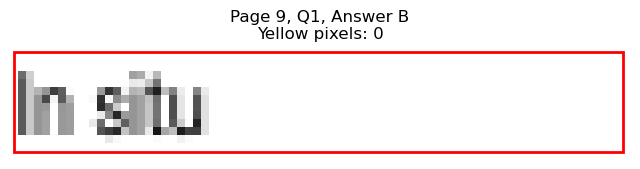

Page 9, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=93.0, y1=160.9
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 48
Page 9, Q1, C: Yellow percentage: 0.0%


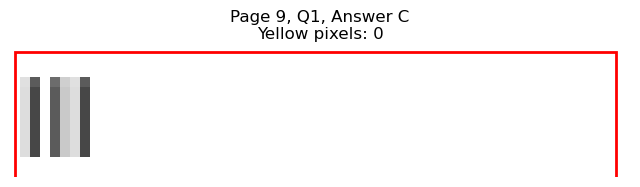

Page 9, Q1 - D: Detected box: x0=322.5, y0=122.9, x1=331.5, y1=135.6
Page 9, Q1, D: Yellow pixels: 726
Page 9, Q1, D: Total non-white pixels: 840
Page 9, Q1, D: Yellow percentage: 86.4%


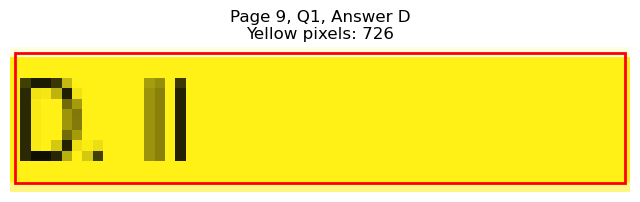

Page 9, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=345.2, y1=148.2
Page 9, Q1, E: Yellow pixels: 62
Page 9, Q1, E: Total non-white pixels: 98
Page 9, Q1, E: Yellow percentage: 63.3%


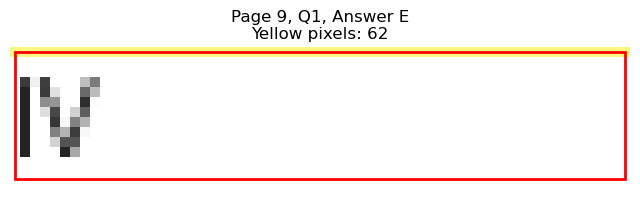


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=275.2, y1=198.7
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 975
Page 9, Q2, A: Yellow percentage: 0.0%


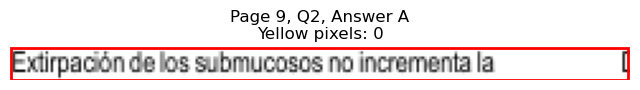

Page 9, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=252.5, y1=224.0
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 870
Page 9, Q2, B: Yellow percentage: 0.0%


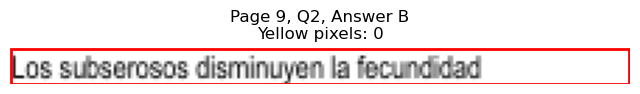

Page 9, Q2 - C: Detected box: x0=174.2, y0=223.9, x1=223.0, y1=236.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 474
Page 9, Q2, C: Yellow percentage: 0.0%


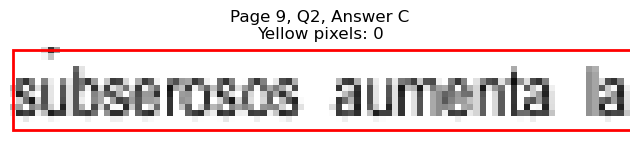

Page 9, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=526.9, y1=198.7
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 944
Page 9, Q2, D: Yellow percentage: 0.0%


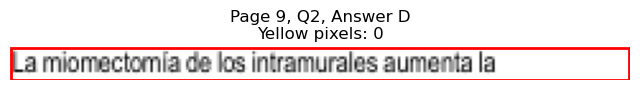

Page 9, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=508.8, y1=224.0
Page 9, Q2, E: Yellow pixels: 1840
Page 9, Q2, E: Total non-white pixels: 2496
Page 9, Q2, E: Yellow percentage: 73.7%


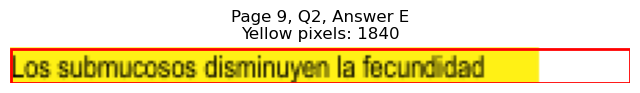


Page 9, Q2 - Selected Answer: E (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=180.2, y0=274.5, x1=220.5, y1=287.1
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 429
Page 9, Q3, A: Yellow percentage: 0.0%


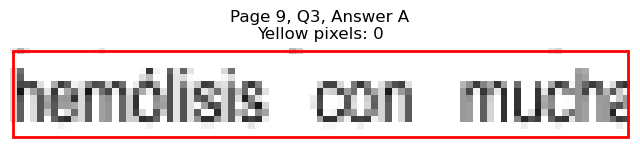

Page 9, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=275.3, y1=312.3
Page 9, Q3, B: Yellow pixels: 5
Page 9, Q3, B: Total non-white pixels: 975
Page 9, Q3, B: Yellow percentage: 0.5%


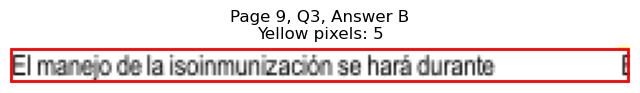

Page 9, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=275.3, y1=337.5
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 856
Page 9, Q3, C: Yellow percentage: 0.0%


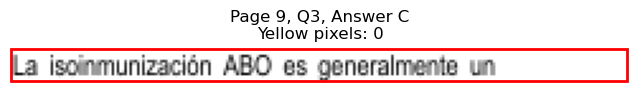

Page 9, Q3 - D: Detected box: x0=452.0, y0=274.5, x1=479.7, y1=287.1
Page 9, Q3, D: Yellow pixels: 792
Page 9, Q3, D: Total non-white pixels: 1050
Page 9, Q3, D: Yellow percentage: 75.4%


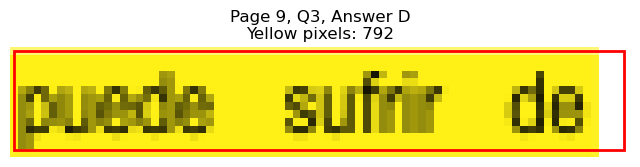

Page 9, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=498.2, y1=312.3
Page 9, Q3, E: Yellow pixels: 192
Page 9, Q3, E: Total non-white pixels: 956
Page 9, Q3, E: Yellow percentage: 20.1%


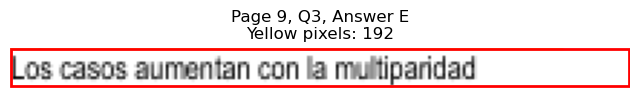


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=388.0, x1=251.1, y1=400.7
Page 9, Q4, A: Yellow pixels: 3
Page 9, Q4, A: Total non-white pixels: 1034
Page 9, Q4, A: Yellow percentage: 0.3%


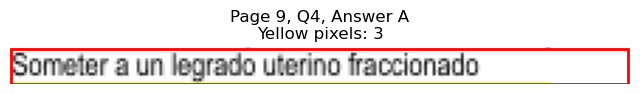

Page 9, Q4 - B: Detected box: x0=82.5, y0=400.6, x1=210.9, y1=413.3
Page 9, Q4, B: Yellow pixels: 1632
Page 9, Q4, B: Total non-white pixels: 2506
Page 9, Q4, B: Yellow percentage: 65.1%


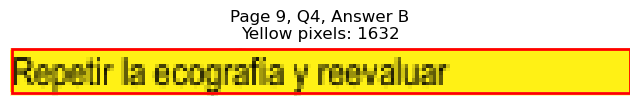

Page 9, Q4 - C: Detected box: x0=82.9, y0=413.3, x1=221.3, y1=426.0
Page 9, Q4, C: Yellow pixels: 1
Page 9, Q4, C: Total non-white pixels: 884
Page 9, Q4, C: Yellow percentage: 0.1%


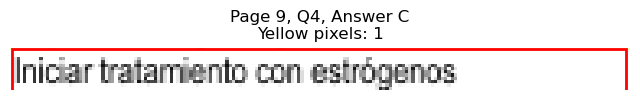

Page 9, Q4 - D: Detected box: x0=334.6, y0=388.0, x1=488.1, y1=400.7
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 810
Page 9, Q4, D: Yellow percentage: 0.0%


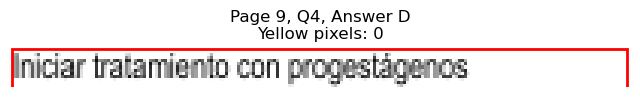

Page 9, Q4 - E: Detected box: x0=334.1, y0=400.6, x1=495.1, y1=413.3
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 784
Page 9, Q4, E: Yellow percentage: 0.0%


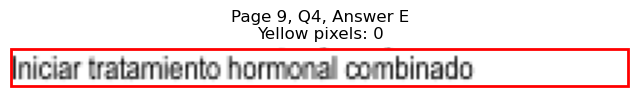


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=463.7, x1=100.6, y1=476.4
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 80
Page 9, Q5, A: Yellow percentage: 0.0%


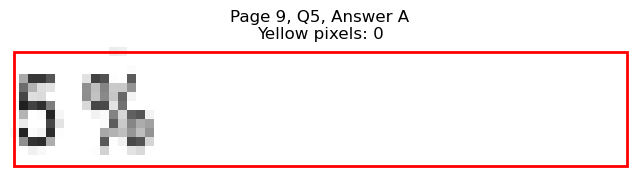

Page 9, Q5 - B: Detected box: x0=82.5, y0=476.3, x1=105.5, y1=489.0
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 107
Page 9, Q5, B: Yellow percentage: 0.0%


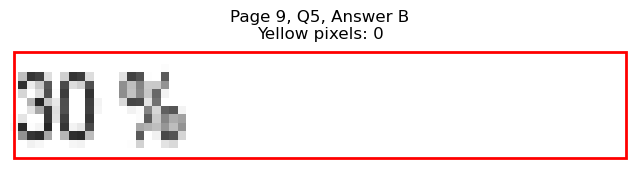

Page 9, Q5 - C: Detected box: x0=82.9, y0=489.1, x1=106.0, y1=501.7
Page 9, Q5, C: Yellow pixels: 877
Page 9, Q5, C: Total non-white pixels: 962
Page 9, Q5, C: Yellow percentage: 91.2%


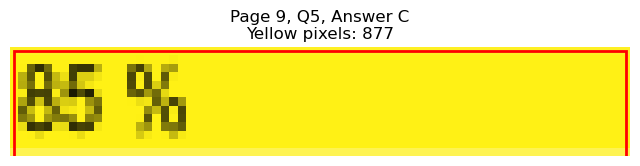

Page 9, Q5 - D: Detected box: x0=334.6, y0=463.7, x1=357.7, y1=476.4
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 111
Page 9, Q5, D: Yellow percentage: 0.0%


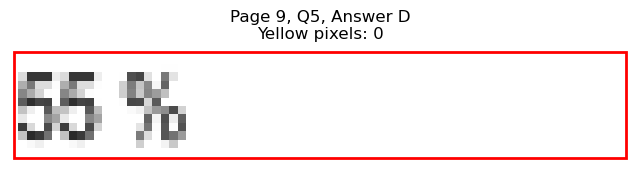

Page 9, Q5 - E: Detected box: x0=334.1, y0=476.3, x1=357.2, y1=489.0
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 95
Page 9, Q5, E: Yellow percentage: 0.0%


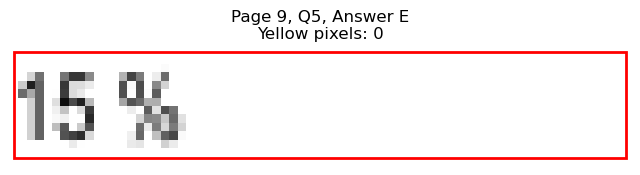


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=220.8, y1=552.1
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 681
Page 9, Q6, A: Yellow percentage: 0.0%


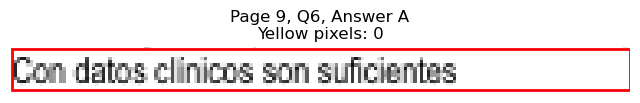

Page 9, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=269.6, y1=564.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 900
Page 9, Q6, B: Yellow percentage: 0.0%


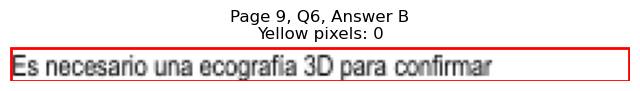

Page 9, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=246.5, y1=577.4
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 832
Page 9, Q6, C: Yellow percentage: 0.0%


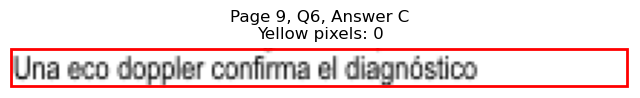

Page 9, Q6 - D: Detected box: x0=350.7, y0=539.5, x1=392.3, y1=552.1
Page 9, Q6, D: Yellow pixels: 910
Page 9, Q6, D: Total non-white pixels: 1302
Page 9, Q6, D: Yellow percentage: 69.9%


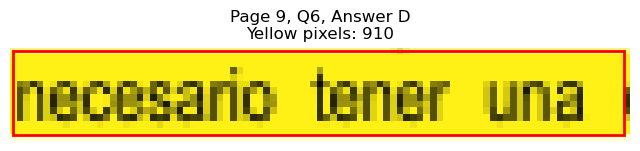

Page 9, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=492.1, y1=577.4
Page 9, Q6, E: Yellow pixels: 192
Page 9, Q6, E: Total non-white pixels: 952
Page 9, Q6, E: Yellow percentage: 20.2%


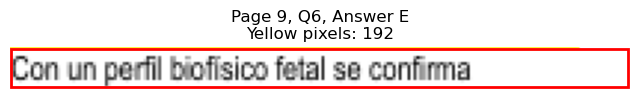


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=627.9, x1=164.7, y1=640.6
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 420
Page 9, Q7, A: Yellow percentage: 0.0%


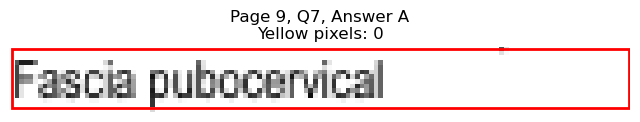

Page 9, Q7 - B: Detected box: x0=82.5, y0=640.5, x1=141.1, y1=653.2
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 278
Page 9, Q7, B: Yellow percentage: 0.0%


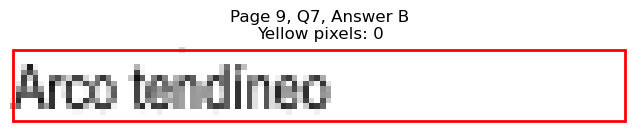

Page 9, Q7 - C: Detected box: x0=82.9, y0=653.1, x1=169.2, y1=665.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 430
Page 9, Q7, C: Yellow percentage: 0.0%


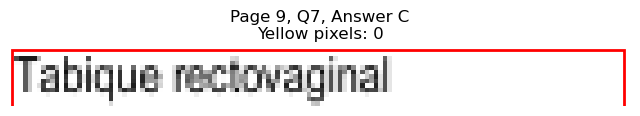

Page 9, Q7 - D: Detected box: x0=334.6, y0=627.9, x1=426.9, y1=640.6
Page 9, Q7, D: Yellow pixels: 1516
Page 9, Q7, D: Total non-white pixels: 2002
Page 9, Q7, D: Yellow percentage: 75.7%


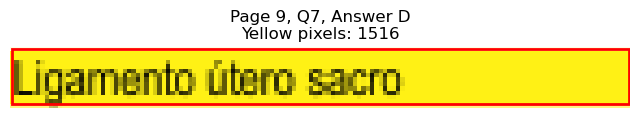

Page 9, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=400.9, y1=653.2
Page 9, Q7, E: Yellow pixels: 115
Page 9, Q7, E: Total non-white pixels: 437
Page 9, Q7, E: Yellow percentage: 26.3%


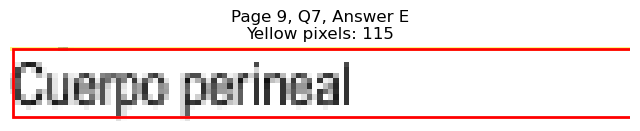


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=146.2, y1=716.3
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 320
Page 9, Q8, A: Yellow percentage: 0.0%


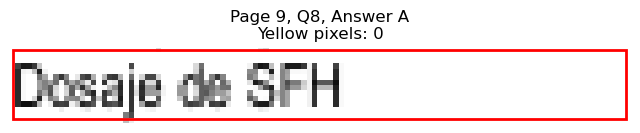

Page 9, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=139.6, y1=728.9
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 269
Page 9, Q8, B: Yellow percentage: 0.0%


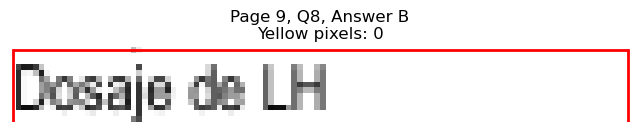

Page 9, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=175.2, y1=741.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 485
Page 9, Q8, C: Yellow percentage: 0.0%


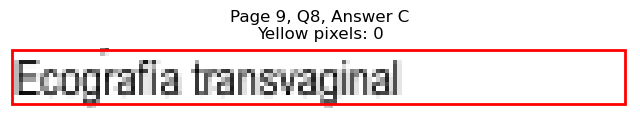

Page 9, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=419.3, y1=716.3
Page 9, Q8, D: Yellow pixels: 136
Page 9, Q8, D: Total non-white pixels: 581
Page 9, Q8, D: Yellow percentage: 23.4%


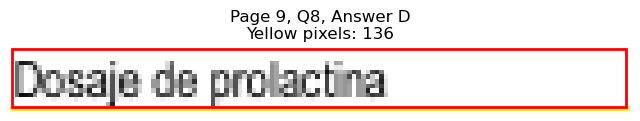

Page 9, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=474.1, y1=728.9
Page 9, Q8, E: Yellow pixels: 1967
Page 9, Q8, E: Total non-white pixels: 2483
Page 9, Q8, E: Yellow percentage: 79.2%


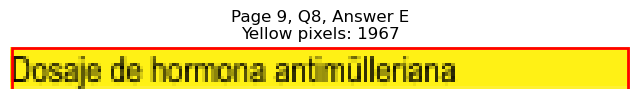


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=95.1, y1=135.6
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 67
Page 10, Q1, A: Yellow percentage: 0.0%


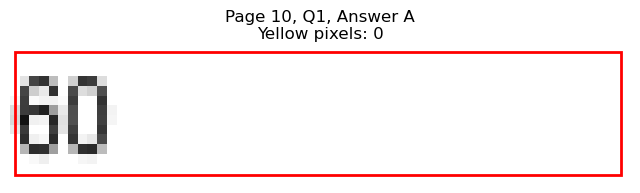

Page 10, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=100.0, y1=148.2
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 87
Page 10, Q1, B: Yellow percentage: 0.0%


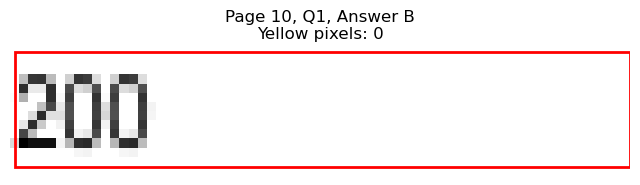

Page 10, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=100.5, y1=160.9
Page 10, Q1, C: Yellow pixels: 826
Page 10, Q1, C: Total non-white pixels: 897
Page 10, Q1, C: Yellow percentage: 92.1%


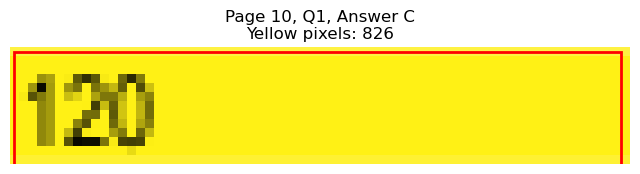

Page 10, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=352.1, y1=135.6
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 90
Page 10, Q1, D: Yellow percentage: 0.0%


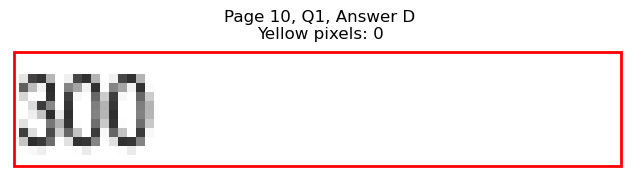

Page 10, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=351.7, y1=148.2
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 85
Page 10, Q1, E: Yellow percentage: 0.0%


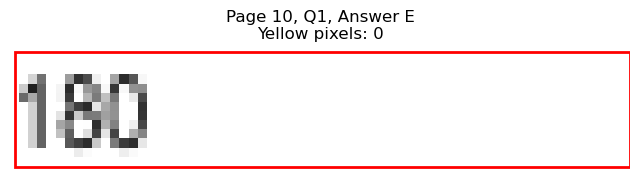


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=141.1, y1=224.0
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 400
Page 10, Q2, A: Yellow percentage: 0.0%


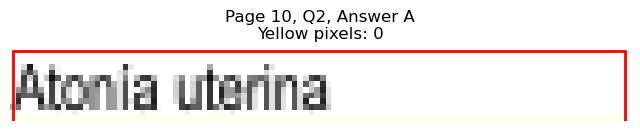

Page 10, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=165.3, y1=236.6
Page 10, Q2, B: Yellow pixels: 1415
Page 10, Q2, B: Total non-white pixels: 1876
Page 10, Q2, B: Yellow percentage: 75.4%


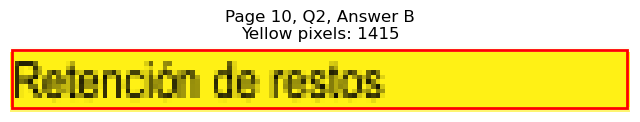

Page 10, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=139.1, y1=249.2
Page 10, Q2, C: Yellow pixels: 108
Page 10, Q2, C: Total non-white pixels: 395
Page 10, Q2, C: Yellow percentage: 27.3%


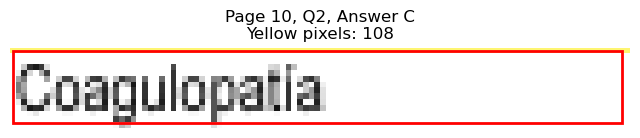

Page 10, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=457.5, y1=224.0
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 578
Page 10, Q2, D: Yellow percentage: 0.0%


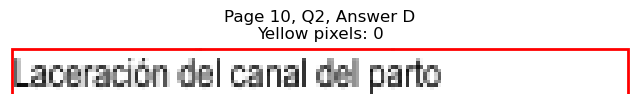

Page 10, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=393.8, y1=236.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 294
Page 10, Q2, E: Yellow percentage: 0.0%


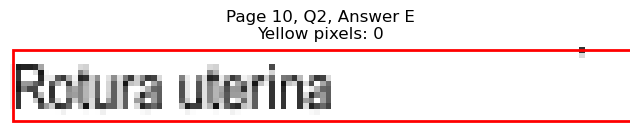


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=287.1, x1=202.8, y1=299.7
Page 10, Q3, A: Yellow pixels: 1758
Page 10, Q3, A: Total non-white pixels: 2223
Page 10, Q3, A: Yellow percentage: 79.1%


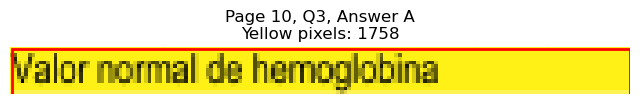

Page 10, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=134.7, y1=312.3
Page 10, Q3, B: Yellow pixels: 102
Page 10, Q3, B: Total non-white pixels: 345
Page 10, Q3, B: Yellow percentage: 29.6%


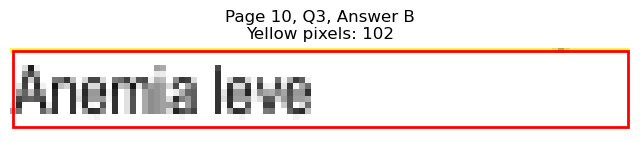

Page 10, Q3 - C: Detected box: x0=82.9, y0=312.3, x1=159.1, y1=324.9
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 370
Page 10, Q3, C: Yellow percentage: 0.0%


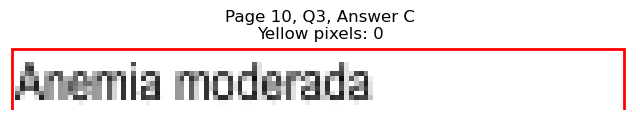

Page 10, Q3 - D: Detected box: x0=334.6, y0=287.1, x1=397.3, y1=299.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 295
Page 10, Q3, D: Yellow percentage: 0.0%


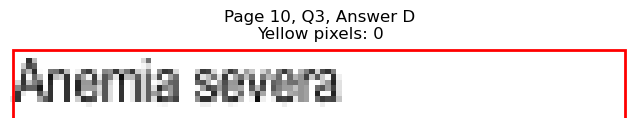

Page 10, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=382.7, y1=312.3
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 282
Page 10, Q3, E: Yellow percentage: 0.0%


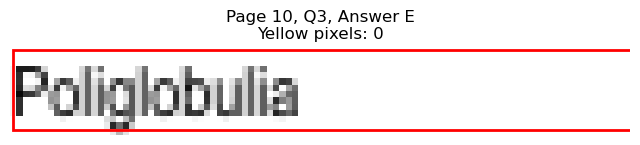


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=167.2, y1=388.1
Page 10, Q4, A: Yellow pixels: 1439
Page 10, Q4, A: Total non-white pixels: 1904
Page 10, Q4, A: Yellow percentage: 75.6%


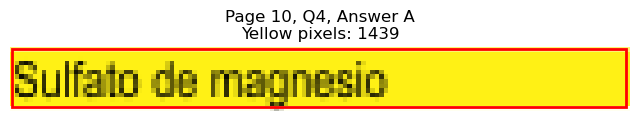

Page 10, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=135.1, y1=400.7
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 390
Page 10, Q4, B: Yellow percentage: 0.0%


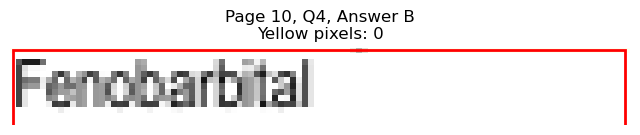

Page 10, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=123.0, y1=413.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 186
Page 10, Q4, C: Yellow percentage: 0.0%


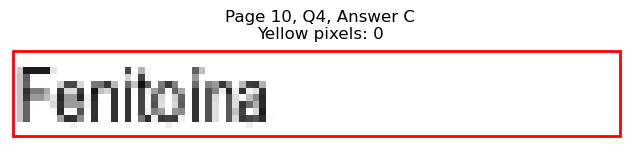

Page 10, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=377.7, y1=388.1
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 224
Page 10, Q4, D: Yellow percentage: 0.0%


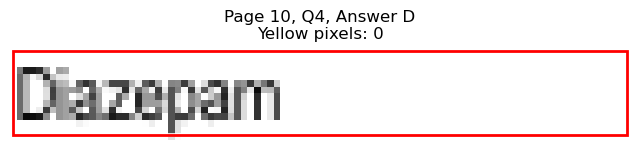

Page 10, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=387.3, y1=400.7
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 275
Page 10, Q4, E: Yellow percentage: 0.0%


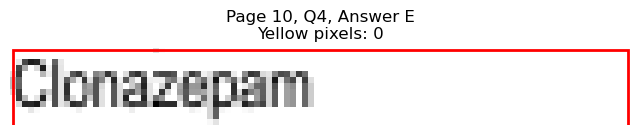


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=138.1, y1=463.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 266
Page 10, Q5, A: Yellow percentage: 0.0%


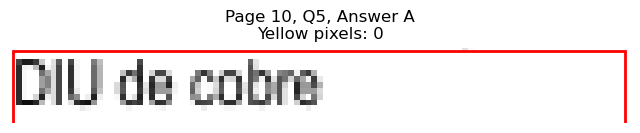

Page 10, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=160.2, y1=476.4
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 405
Page 10, Q5, B: Yellow percentage: 0.0%


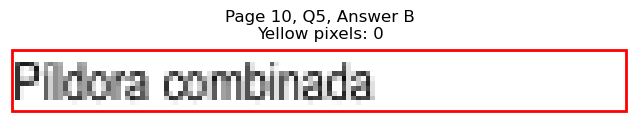

Page 10, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=216.4, y1=489.0
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 685
Page 10, Q5, C: Yellow percentage: 0.0%


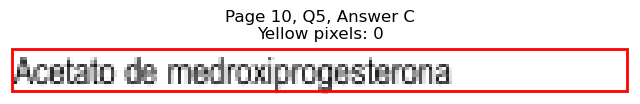

Page 10, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=435.9, y1=463.8
Page 10, Q5, D: Yellow pixels: 4
Page 10, Q5, D: Total non-white pixels: 677
Page 10, Q5, D: Yellow percentage: 0.6%


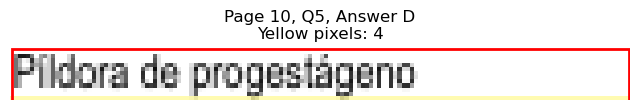

Page 10, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=428.5, y1=476.4
Page 10, Q5, E: Yellow pixels: 1375
Page 10, Q5, E: Total non-white pixels: 2030
Page 10, Q5, E: Yellow percentage: 67.7%


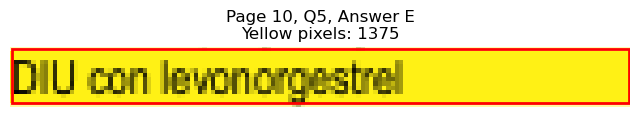


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=100.0, y1=552.1
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 73
Page 10, Q6, A: Yellow percentage: 0.0%


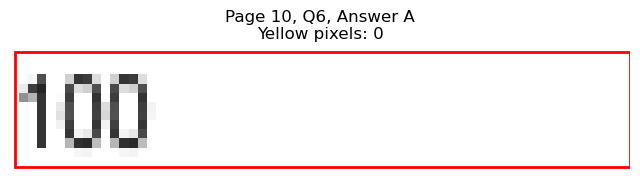

Page 10, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=100.0, y1=564.8
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 157
Page 10, Q6, B: Yellow percentage: 0.0%


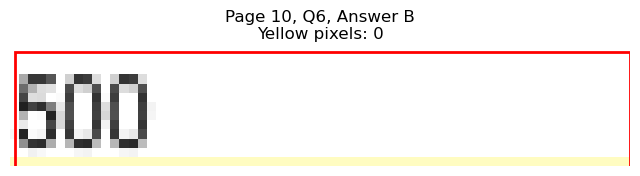

Page 10, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=100.5, y1=577.4
Page 10, Q6, C: Yellow pixels: 746
Page 10, Q6, C: Total non-white pixels: 966
Page 10, Q6, C: Yellow percentage: 77.2%


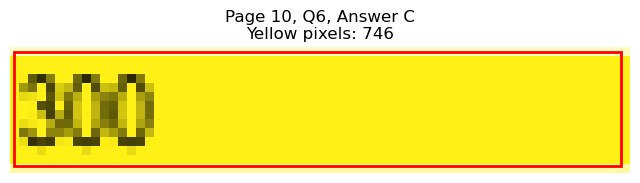

Page 10, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=352.1, y1=552.1
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 93
Page 10, Q6, D: Yellow percentage: 0.0%


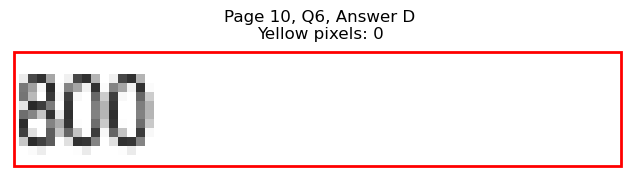

Page 10, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=356.7, y1=564.8
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 117
Page 10, Q6, E: Yellow percentage: 0.0%


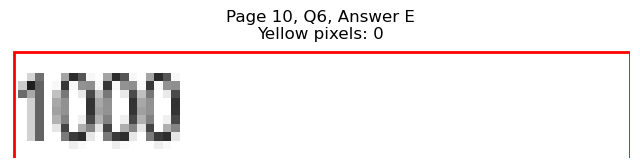


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=220.5, y0=602.6, x1=257.1, y1=615.2
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 239
Page 10, Q7, A: Yellow percentage: 0.0%


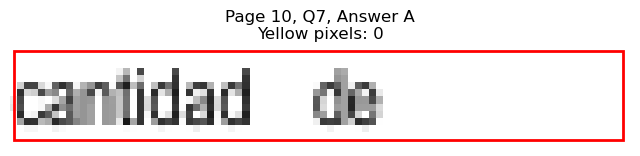

Page 10, Q7 - B: Detected box: x0=82.5, y0=627.9, x1=275.1, y1=640.6
Page 10, Q7, B: Yellow pixels: 1832
Page 10, Q7, B: Total non-white pixels: 2723
Page 10, Q7, B: Yellow percentage: 67.3%


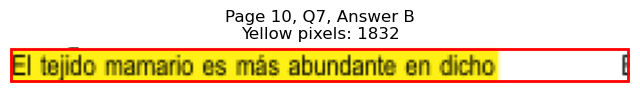

Page 10, Q7 - C: Detected box: x0=211.6, y0=653.1, x1=256.7, y1=665.8
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 289
Page 10, Q7, C: Yellow percentage: 0.0%


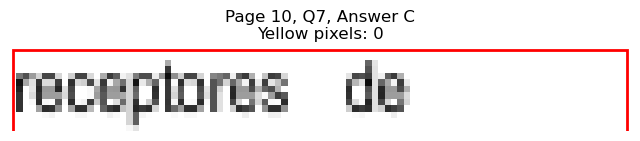

Page 10, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=526.9, y1=615.2
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 945
Page 10, Q7, D: Yellow percentage: 0.0%


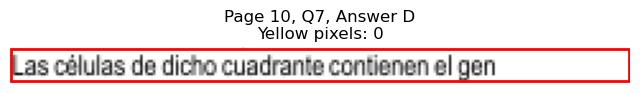

Page 10, Q7 - E: Detected box: x0=447.2, y0=627.9, x1=492.3, y1=640.6
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 378
Page 10, Q7, E: Yellow percentage: 0.0%


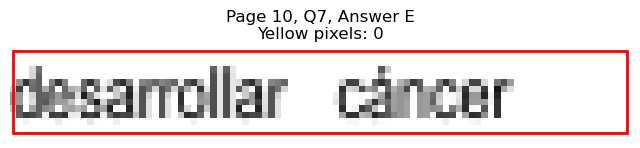


Page 10, Q7 - Selected Answer: B (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.5, y0=728.9, x1=158.2, y1=741.5
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 390
Page 10, Q8, A: Yellow percentage: 0.0%


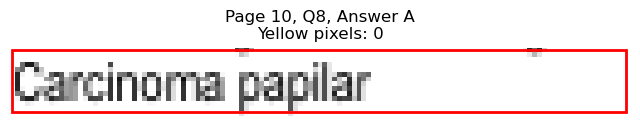

Page 10, Q8 - B: Detected box: x0=82.5, y0=741.4, x1=168.3, y1=754.1
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 423
Page 10, Q8, B: Yellow percentage: 0.0%


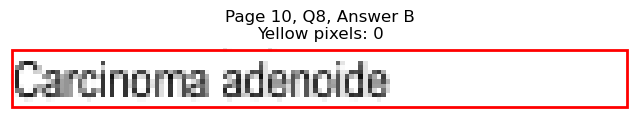

Page 10, Q8 - C: Detected box: x0=82.9, y0=754.0, x1=142.1, y1=766.7
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 291
Page 10, Q8, C: Yellow percentage: 0.0%


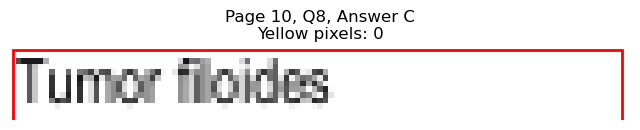

Page 10, Q8 - D: Detected box: x0=334.6, y0=728.9, x1=406.9, y1=741.5
Page 10, Q8, D: Yellow pixels: 123
Page 10, Q8, D: Total non-white pixels: 468
Page 10, Q8, D: Yellow percentage: 26.3%


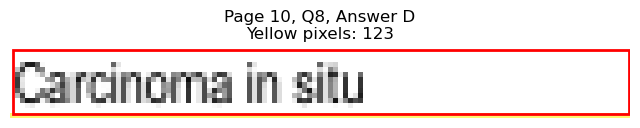

Page 10, Q8 - E: Detected box: x0=334.1, y0=741.4, x1=429.4, y1=754.1
Page 10, Q8, E: Yellow pixels: 1530
Page 10, Q8, E: Total non-white pixels: 2044
Page 10, Q8, E: Yellow percentage: 74.9%


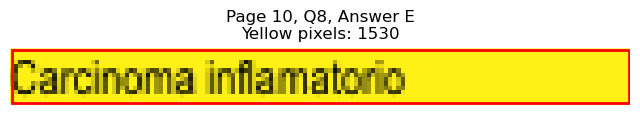


Page 10, Q8 - Selected Answer: E (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=211.8, y1=123.0
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 638
Page 11, Q1, A: Yellow percentage: 0.0%


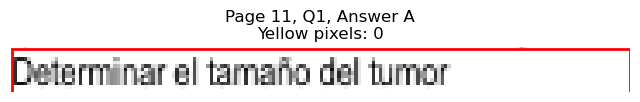

Page 11, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=209.9, y1=135.6
Page 11, Q1, B: Yellow pixels: 178
Page 11, Q1, B: Total non-white pixels: 811
Page 11, Q1, B: Yellow percentage: 21.9%


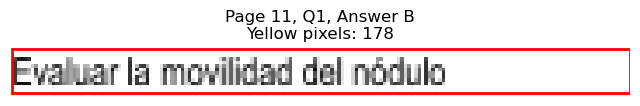

Page 11, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=261.0, y1=148.2
Page 11, Q1, C: Yellow pixels: 1833
Page 11, Q1, C: Total non-white pixels: 2702
Page 11, Q1, C: Yellow percentage: 67.8%


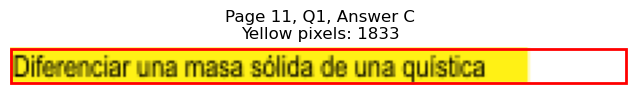

Page 11, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=485.6, y1=123.0
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 780
Page 11, Q1, D: Yellow percentage: 0.0%


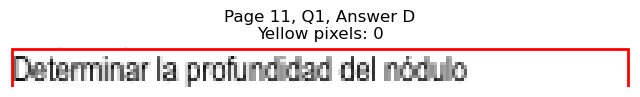

Page 11, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=381.4, y1=135.6
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 396
Page 11, Q1, E: Yellow percentage: 0.0%


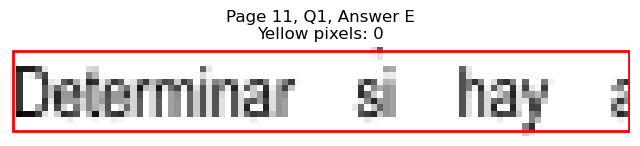


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=147.1, y1=186.1
Page 11, Q2, A: Yellow pixels: 116
Page 11, Q2, A: Total non-white pixels: 421
Page 11, Q2, A: Yellow percentage: 27.6%


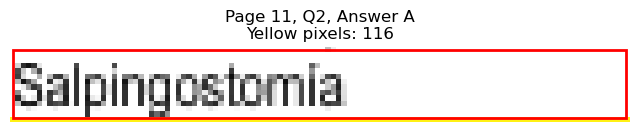

Page 11, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=159.1, y1=198.7
Page 11, Q2, B: Yellow pixels: 1394
Page 11, Q2, B: Total non-white pixels: 1664
Page 11, Q2, B: Yellow percentage: 83.8%


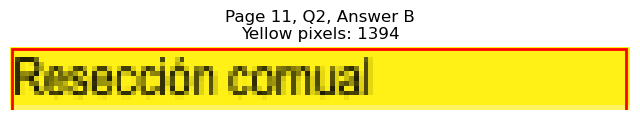

Page 11, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=133.1, y1=211.3
Page 11, Q2, C: Yellow pixels: 102
Page 11, Q2, C: Total non-white pixels: 372
Page 11, Q2, C: Yellow percentage: 27.4%


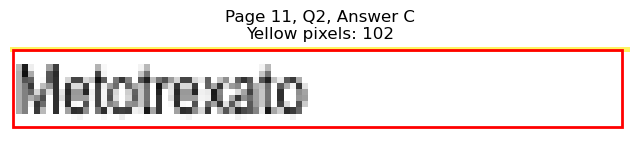

Page 11, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=392.8, y1=186.1
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 319
Page 11, Q2, D: Yellow percentage: 0.0%


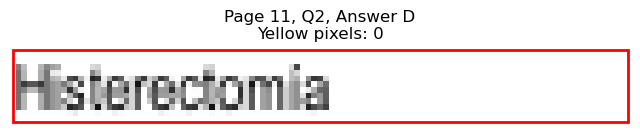

Page 11, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=403.9, y1=198.7
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 394
Page 11, Q2, E: Yellow percentage: 0.0%


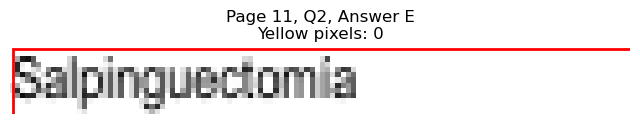


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=261.7, x1=96.0, y1=274.4
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 58
Page 11, Q3, A: Yellow percentage: 0.0%


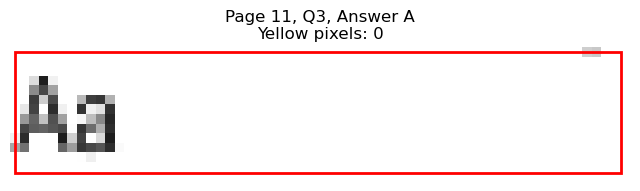

Page 11, Q3 - B: Detected box: x0=82.5, y0=274.5, x1=96.0, y1=287.1
Page 11, Q3, B: Yellow pixels: 797
Page 11, Q3, B: Total non-white pixels: 910
Page 11, Q3, B: Yellow percentage: 87.6%


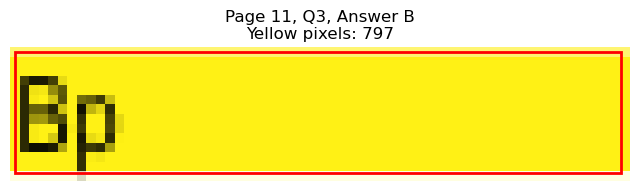

Page 11, Q3 - C: Detected box: x0=82.9, y0=287.1, x1=91.9, y1=299.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 93
Page 11, Q3, C: Yellow percentage: 0.0%


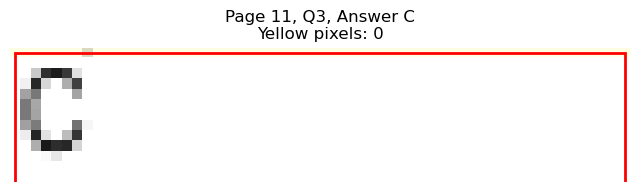

Page 11, Q3 - D: Detected box: x0=322.5, y0=261.7, x1=331.5, y1=274.4
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 77
Page 11, Q3, D: Yellow percentage: 0.0%


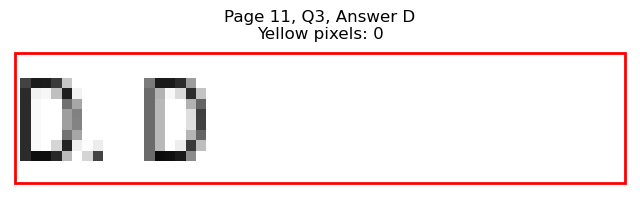

Page 11, Q3 - E: Detected box: x0=334.1, y0=274.5, x1=347.7, y1=287.1
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 69
Page 11, Q3, E: Yellow percentage: 0.0%


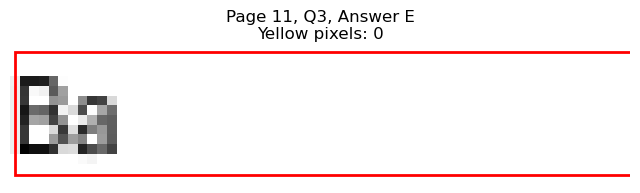


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=160.7, y1=337.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 426
Page 11, Q4, A: Yellow percentage: 0.0%


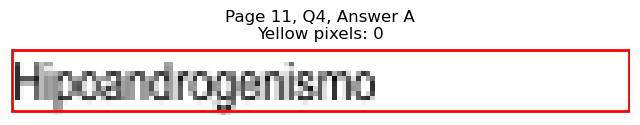

Page 11, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=180.3, y1=350.1
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 531
Page 11, Q4, B: Yellow percentage: 0.0%


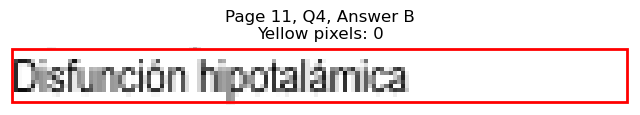

Page 11, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=186.3, y1=362.9
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 525
Page 11, Q4, C: Yellow percentage: 0.0%


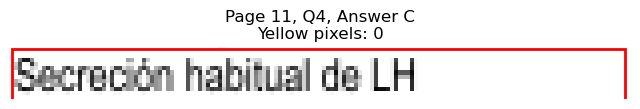

Page 11, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=434.0, y1=337.5
Page 11, Q4, D: Yellow pixels: 150
Page 11, Q4, D: Total non-white pixels: 623
Page 11, Q4, D: Yellow percentage: 24.1%


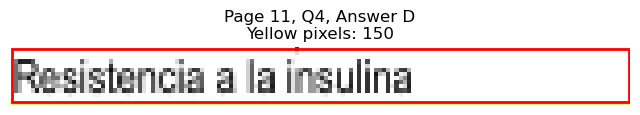

Page 11, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=415.9, y1=350.1
Page 11, Q4, E: Yellow pixels: 1397
Page 11, Q4, E: Total non-white pixels: 1848
Page 11, Q4, E: Yellow percentage: 75.6%


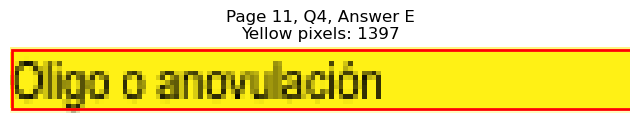


Page 11, Q4 - Selected Answer: E (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=275.2, y1=426.0
Page 11, Q5, A: Yellow pixels: 1798
Page 11, Q5, A: Total non-white pixels: 2528
Page 11, Q5, A: Yellow percentage: 71.1%


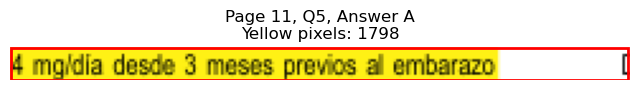

Page 11, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=275.2, y1=451.2
Page 11, Q5, B: Yellow pixels: 192
Page 11, Q5, B: Total non-white pixels: 1143
Page 11, Q5, B: Yellow percentage: 16.8%


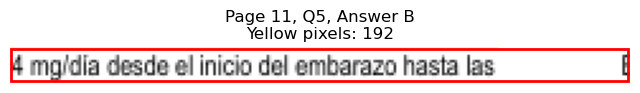

Page 11, Q5 - C: Detected box: x0=227.2, y0=463.7, x1=258.8, y1=476.4
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 204
Page 11, Q5, C: Yellow percentage: 0.0%


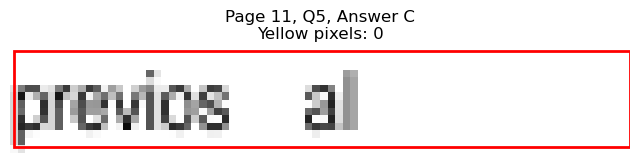

Page 11, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=526.9, y1=426.0
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 900
Page 11, Q5, D: Yellow percentage: 0.0%


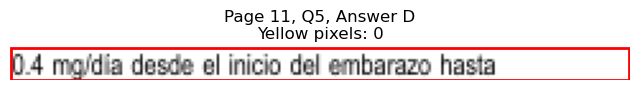

Page 11, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=484.7, y1=451.2
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 686
Page 11, Q5, E: Yellow percentage: 0.0%


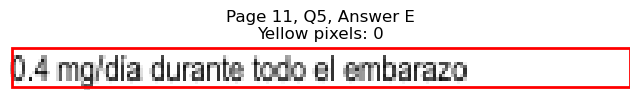


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=139.7, y1=552.1
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 276
Page 11, Q6, A: Yellow percentage: 0.0%


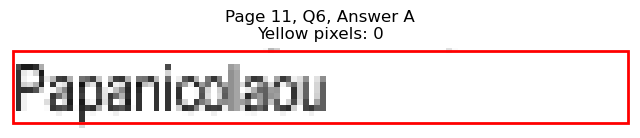

Page 11, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=198.3, y1=564.8
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 567
Page 11, Q6, B: Yellow percentage: 0.0%


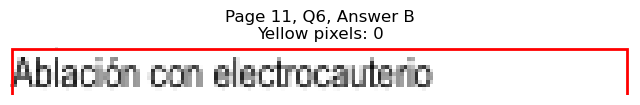

Page 11, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=161.7, y1=577.4
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 408
Page 11, Q6, C: Yellow percentage: 0.0%


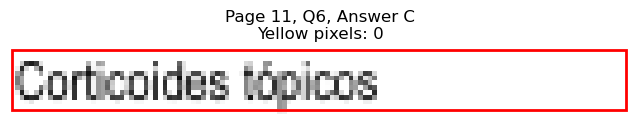

Page 11, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=401.3, y1=552.1
Page 11, Q6, D: Yellow pixels: 1287
Page 11, Q6, D: Total non-white pixels: 1652
Page 11, Q6, D: Yellow percentage: 77.9%


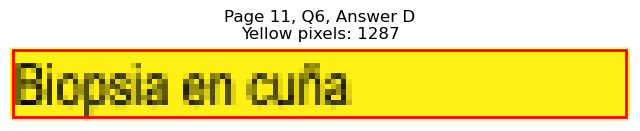

Page 11, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=428.5, y1=564.8
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 629
Page 11, Q6, E: Yellow percentage: 0.0%


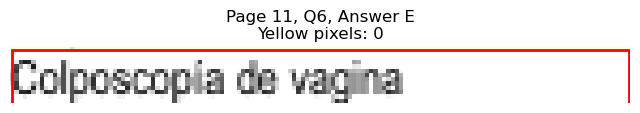


Page 11, Q6 - Selected Answer: D (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=627.9, x1=95.1, y1=640.6
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 67
Page 11, Q7, A: Yellow percentage: 0.0%


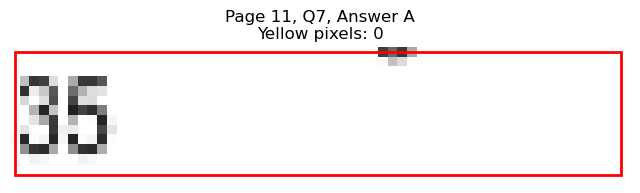

Page 11, Q7 - B: Detected box: x0=82.5, y0=640.5, x1=95.1, y1=653.2
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 58
Page 11, Q7, B: Yellow percentage: 0.0%


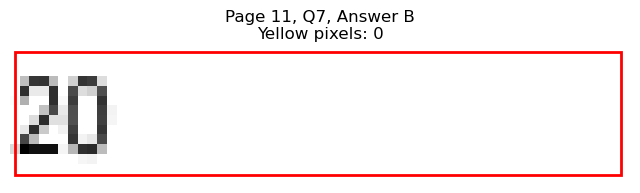

Page 11, Q7 - C: Detected box: x0=82.9, y0=653.1, x1=95.5, y1=665.8
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 55
Page 11, Q7, C: Yellow percentage: 0.0%


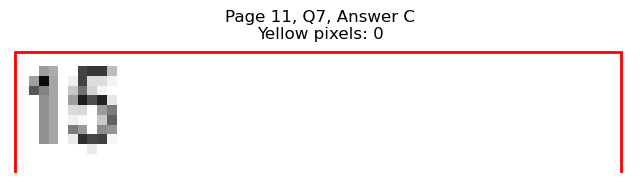

Page 11, Q7 - D: Detected box: x0=334.6, y0=627.9, x1=347.2, y1=640.6
Page 11, Q7, D: Yellow pixels: 64
Page 11, Q7, D: Total non-white pixels: 115
Page 11, Q7, D: Yellow percentage: 55.7%


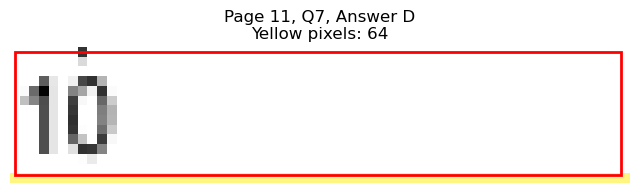

Page 11, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=346.7, y1=653.2
Page 11, Q7, E: Yellow pixels: 779
Page 11, Q7, E: Total non-white pixels: 882
Page 11, Q7, E: Yellow percentage: 88.3%


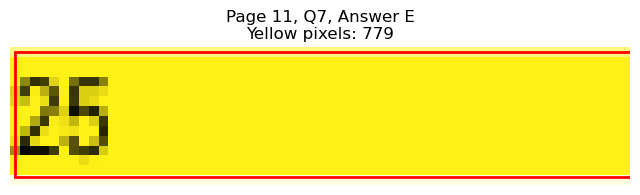


Page 11, Q7 - Selected Answer: E (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=275.2, y1=716.3
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 944
Page 11, Q8, A: Yellow percentage: 0.0%


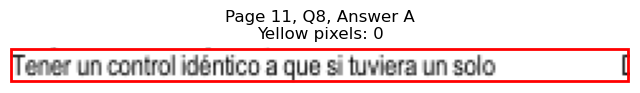

Page 11, Q8 - B: Detected box: x0=192.9, y0=728.9, x1=264.7, y1=741.5
Page 11, Q8, B: Yellow pixels: 737
Page 11, Q8, B: Total non-white pixels: 1162
Page 11, Q8, B: Yellow percentage: 63.4%


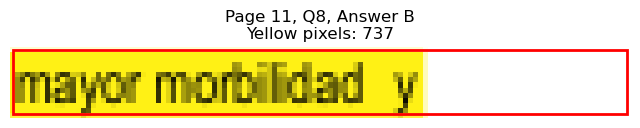

Page 11, Q8 - C: Detected box: x0=116.4, y0=754.0, x1=168.1, y1=766.7
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 552
Page 11, Q8, C: Yellow percentage: 0.0%


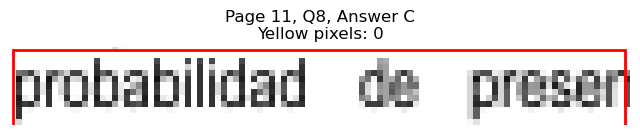

Page 11, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=522.7, y1=716.3
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 965
Page 11, Q8, D: Yellow percentage: 0.0%


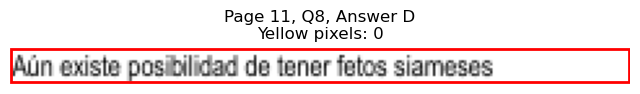

Page 11, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=473.6, y1=728.9
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 754
Page 11, Q8, E: Yellow percentage: 0.0%


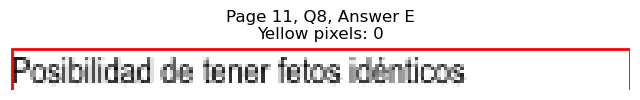


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=162.3, y1=123.0
Page 12, Q1, A: Yellow pixels: 1402
Page 12, Q1, A: Total non-white pixels: 1703
Page 12, Q1, A: Yellow percentage: 82.3%


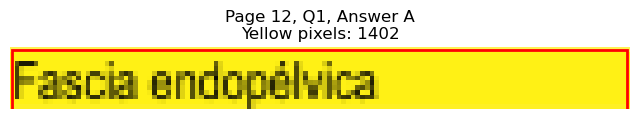

Page 12, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=192.3, y1=135.6
Page 12, Q1, B: Yellow pixels: 160
Page 12, Q1, B: Total non-white pixels: 694
Page 12, Q1, B: Yellow percentage: 23.1%


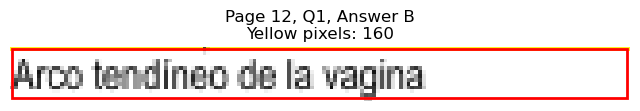

Page 12, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=168.7, y1=148.2
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 439
Page 12, Q1, C: Yellow percentage: 0.0%


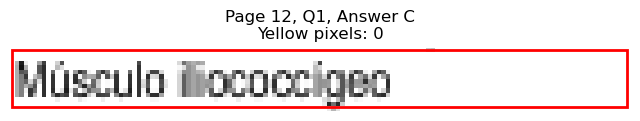

Page 12, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=404.8, y1=123.0
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 374
Page 12, Q1, D: Yellow percentage: 0.0%


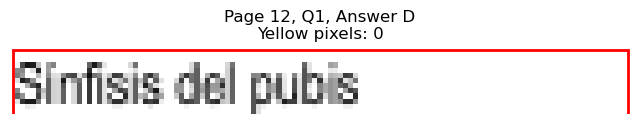

Page 12, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=463.5, y1=135.6
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 632
Page 12, Q1, E: Yellow percentage: 0.0%


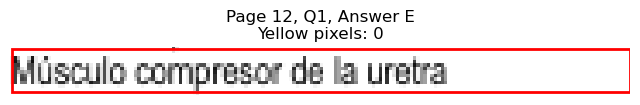


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=157.7, y1=198.7
Page 12, Q2, A: Yellow pixels: 1359
Page 12, Q2, A: Total non-white pixels: 1638
Page 12, Q2, A: Yellow percentage: 83.0%


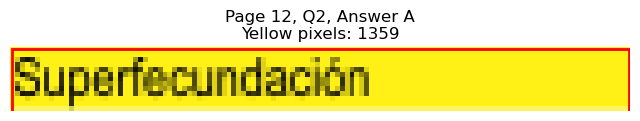

Page 12, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=170.2, y1=211.3
Page 12, Q2, B: Yellow pixels: 139
Page 12, Q2, B: Total non-white pixels: 604
Page 12, Q2, B: Yellow percentage: 23.0%


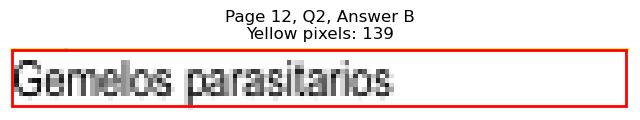

Page 12, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=154.1, y1=224.0
Page 12, Q2, C: Yellow pixels: 0
Page 12, Q2, C: Total non-white pixels: 332
Page 12, Q2, C: Yellow percentage: 0.0%


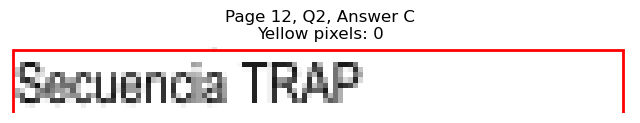

Page 12, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=386.8, y1=198.7
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 245
Page 12, Q2, D: Yellow percentage: 0.0%


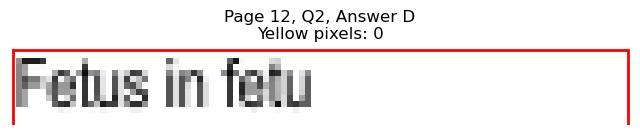

Page 12, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=392.3, y1=211.3
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 316
Page 12, Q2, E: Yellow percentage: 0.0%


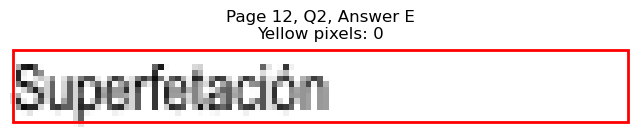


Page 12, Q2 - Selected Answer: A (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=125.5, y1=261.8
Page 12, Q3, A: Yellow pixels: 0
Page 12, Q3, A: Total non-white pixels: 332
Page 12, Q3, A: Yellow percentage: 0.0%


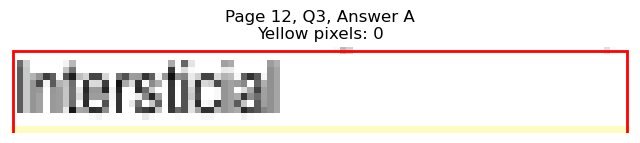

Page 12, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=117.5, y1=274.4
Page 12, Q3, B: Yellow pixels: 978
Page 12, Q3, B: Total non-white pixels: 1204
Page 12, Q3, B: Yellow percentage: 81.2%


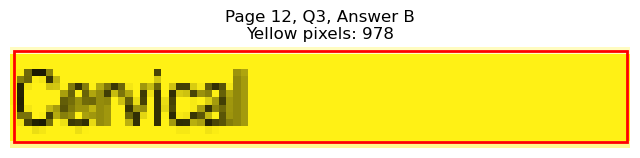

Page 12, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=117.5, y1=287.1
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 176
Page 12, Q3, C: Yellow percentage: 0.0%


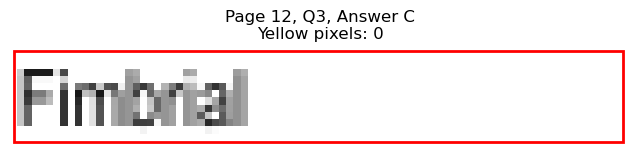

Page 12, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=365.7, y1=261.8
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 164
Page 12, Q3, D: Yellow percentage: 0.0%


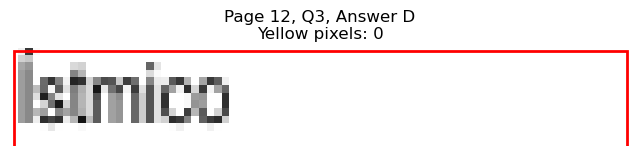

Page 12, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=367.7, y1=274.4
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 164
Page 12, Q3, E: Yellow percentage: 0.0%


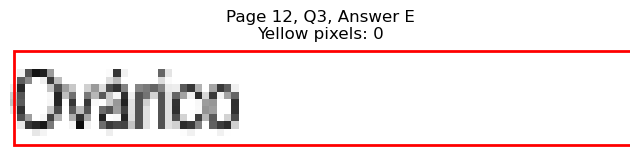


Page 12, Q3 - Selected Answer: B (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=231.4, y1=337.5
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 750
Page 12, Q4, A: Yellow percentage: 0.0%


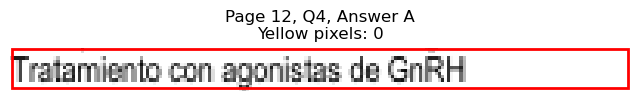

Page 12, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=190.2, y1=350.1
Page 12, Q4, B: Yellow pixels: 0
Page 12, Q4, B: Total non-white pixels: 564
Page 12, Q4, B: Yellow percentage: 0.0%


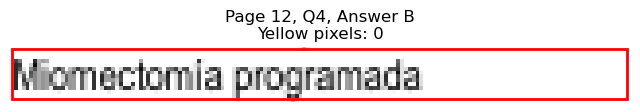

Page 12, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=246.5, y1=362.9
Page 12, Q4, C: Yellow pixels: 1896
Page 12, Q4, C: Total non-white pixels: 2509
Page 12, Q4, C: Yellow percentage: 75.6%


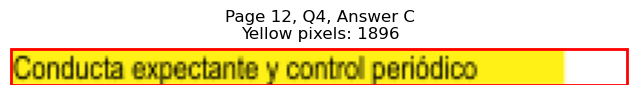

Page 12, Q4 - D: Detected box: x0=393.5, y0=324.9, x1=481.4, y1=337.5
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 621
Page 12, Q4, D: Yellow percentage: 0.0%


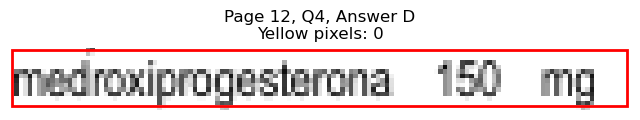

Page 12, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=426.9, y1=362.9
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 467
Page 12, Q4, E: Yellow percentage: 0.0%


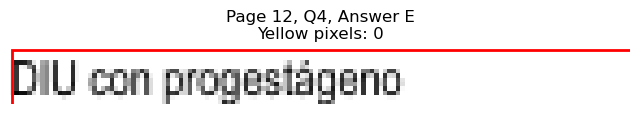


Page 12, Q4 - Selected Answer: C (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=400.6, x1=148.1, y1=413.3
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 334
Page 12, Q5, A: Yellow percentage: 0.0%


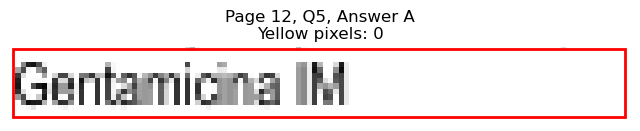

Page 12, Q5 - B: Detected box: x0=82.5, y0=413.3, x1=146.2, y1=426.0
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 426
Page 12, Q5, B: Yellow percentage: 0.0%


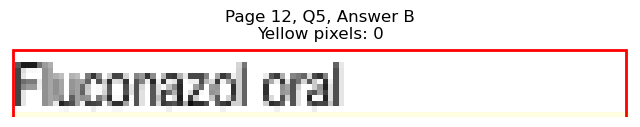

Page 12, Q5 - C: Detected box: x0=82.9, y0=425.9, x1=154.7, y1=438.6
Page 12, Q5, C: Yellow pixels: 1291
Page 12, Q5, C: Total non-white pixels: 1722
Page 12, Q5, C: Yellow percentage: 75.0%


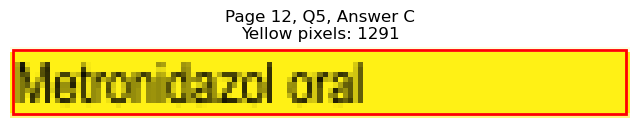

Page 12, Q5 - D: Detected box: x0=334.6, y0=400.6, x1=408.8, y1=413.3
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 383
Page 12, Q5, D: Yellow percentage: 0.0%


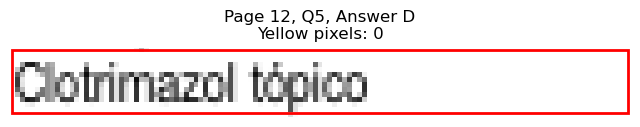

Page 12, Q5 - E: Detected box: x0=334.1, y0=413.3, x1=398.3, y1=426.0
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 311
Page 12, Q5, E: Yellow percentage: 0.0%


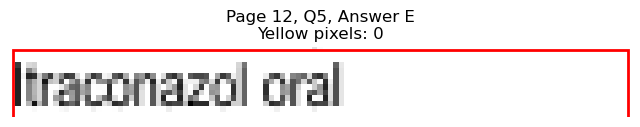


Page 12, Q5 - Selected Answer: C (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=213.9, y1=501.7
Page 12, Q6, A: Yellow pixels: 1854
Page 12, Q6, A: Total non-white pixels: 2366
Page 12, Q6, A: Yellow percentage: 78.4%


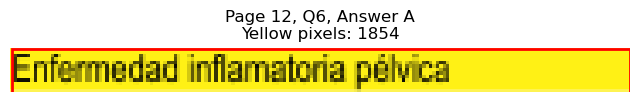

Page 12, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=145.7, y1=514.3
Page 12, Q6, B: Yellow pixels: 114
Page 12, Q6, B: Total non-white pixels: 434
Page 12, Q6, B: Yellow percentage: 26.3%


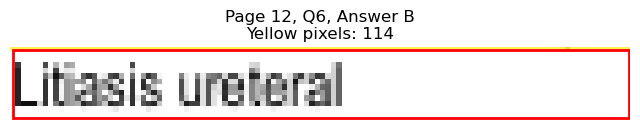

Page 12, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=156.7, y1=526.9
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 395
Page 12, Q6, C: Yellow percentage: 0.0%


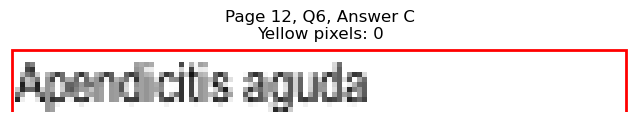

Page 12, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=405.9, y1=501.7
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 341
Page 12, Q6, D: Yellow percentage: 0.0%


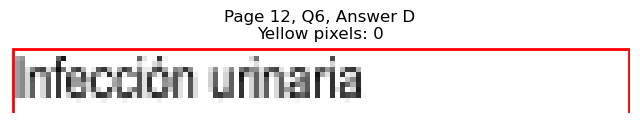

Page 12, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=412.4, y1=514.3
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 425
Page 12, Q6, E: Yellow percentage: 0.0%


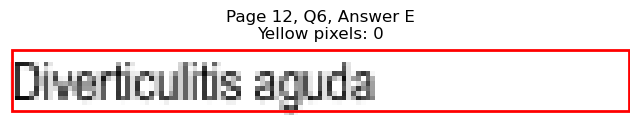


Page 12, Q6 - Selected Answer: A (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=564.8, x1=137.2, y1=577.4
Page 12, Q7, A: Yellow pixels: 0
Page 12, Q7, A: Total non-white pixels: 292
Page 12, Q7, A: Yellow percentage: 0.0%


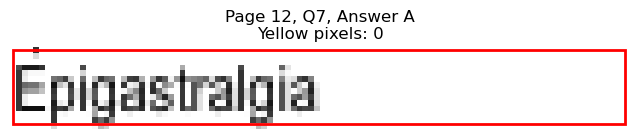

Page 12, Q7 - B: Detected box: x0=82.5, y0=577.4, x1=132.1, y1=590.0
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 265
Page 12, Q7, B: Yellow percentage: 0.0%


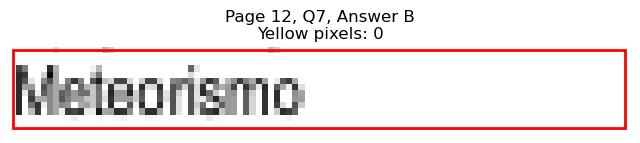

Page 12, Q7 - C: Detected box: x0=82.9, y0=590.0, x1=204.3, y1=602.6
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 609
Page 12, Q7, C: Yellow percentage: 0.0%


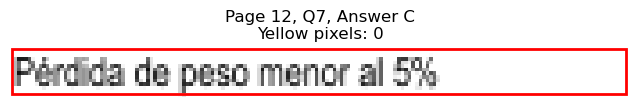

Page 12, Q7 - D: Detected box: x0=334.6, y0=564.8, x1=443.5, y1=577.4
Page 12, Q7, D: Yellow pixels: 160
Page 12, Q7, D: Total non-white pixels: 736
Page 12, Q7, D: Yellow percentage: 21.7%


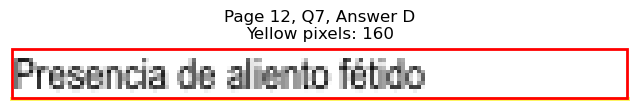

Page 12, Q7 - E: Detected box: x0=334.1, y0=577.4, x1=459.1, y1=590.0
Page 12, Q7, E: Yellow pixels: 1788
Page 12, Q7, E: Total non-white pixels: 2288
Page 12, Q7, E: Yellow percentage: 78.1%


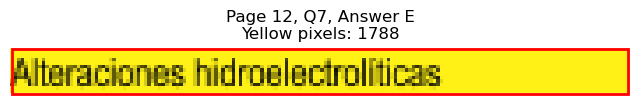


Page 12, Q7 - Selected Answer: E (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=158.7, y1=665.8
Page 12, Q8, A: Yellow pixels: 1330
Page 12, Q8, A: Total non-white pixels: 1651
Page 12, Q8, A: Yellow percentage: 80.6%


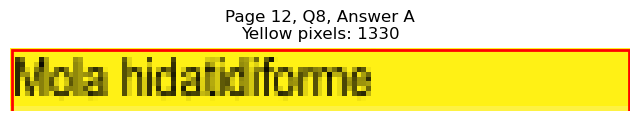

Page 12, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=139.6, y1=678.4
Page 12, Q8, B: Yellow pixels: 108
Page 12, Q8, B: Total non-white pixels: 402
Page 12, Q8, B: Yellow percentage: 26.9%


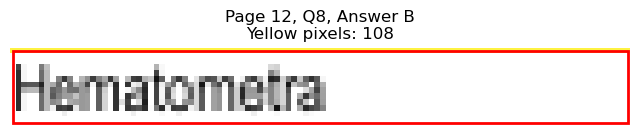

Page 12, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=142.6, y1=691.0
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 275
Page 12, Q8, C: Yellow percentage: 0.0%


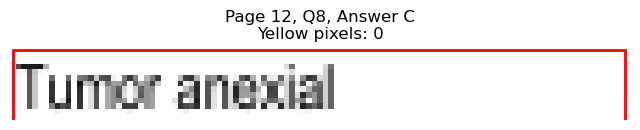

Page 12, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=412.9, y1=665.8
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 419
Page 12, Q8, D: Yellow percentage: 0.0%


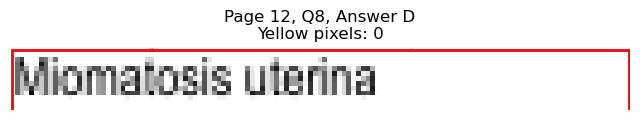

Page 12, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=412.9, y1=678.4
Page 12, Q8, E: Yellow pixels: 0
Page 12, Q8, E: Total non-white pixels: 395
Page 12, Q8, E: Yellow percentage: 0.0%


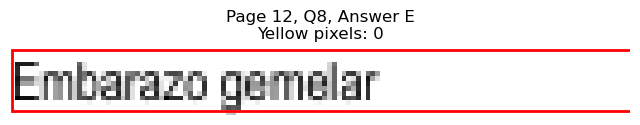


Page 12, Q8 - Selected Answer: A (based on yellow pixel count)





Page 13: Found 3 questions
Page 13, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=253.1, y1=123.0
Page 13, Q1, A: Yellow pixels: 0
Page 13, Q1, A: Total non-white pixels: 839
Page 13, Q1, A: Yellow percentage: 0.0%


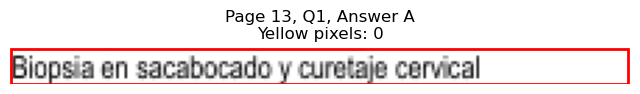

Page 13, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=140.7, y1=135.6
Page 13, Q1, B: Yellow pixels: 0
Page 13, Q1, B: Total non-white pixels: 521
Page 13, Q1, B: Yellow percentage: 0.0%


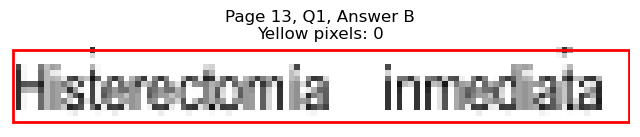

Page 13, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=275.3, y1=160.9
Page 13, Q1, C: Yellow pixels: 0
Page 13, Q1, C: Total non-white pixels: 914
Page 13, Q1, C: Yellow percentage: 0.0%


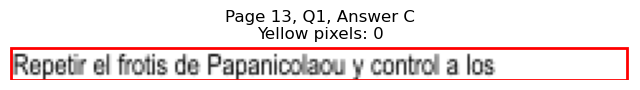

Page 13, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=435.4, y1=123.0
Page 13, Q1, D: Yellow pixels: 1584
Page 13, Q1, D: Total non-white pixels: 1976
Page 13, Q1, D: Yellow percentage: 80.2%


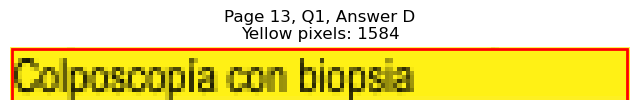

Page 13, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=465.1, y1=135.6
Page 13, Q1, E: Yellow pixels: 177
Page 13, Q1, E: Total non-white pixels: 853
Page 13, Q1, E: Yellow percentage: 20.8%


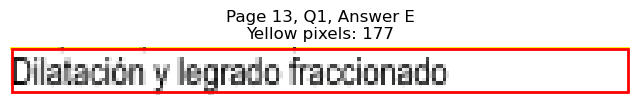


Page 13, Q1 - Selected Answer: D (based on yellow pixel count)




Page 13, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=151.7, y1=224.0
Page 13, Q2, A: Yellow pixels: 0
Page 13, Q2, A: Total non-white pixels: 363
Page 13, Q2, A: Yellow percentage: 0.0%


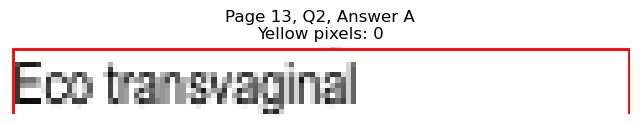

Page 13, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=184.2, y1=236.6
Page 13, Q2, B: Yellow pixels: 0
Page 13, Q2, B: Total non-white pixels: 526
Page 13, Q2, B: Yellow percentage: 0.0%


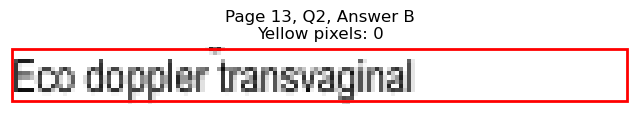

Page 13, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=197.8, y1=249.2
Page 13, Q2, C: Yellow pixels: 0
Page 13, Q2, C: Total non-white pixels: 582
Page 13, Q2, C: Yellow percentage: 0.0%


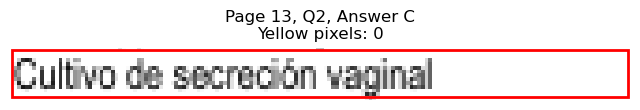

Page 13, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=392.3, y1=224.0
Page 13, Q2, D: Yellow pixels: 0
Page 13, Q2, D: Total non-white pixels: 410
Page 13, Q2, D: Yellow percentage: 0.0%


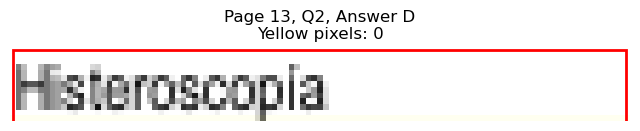

Page 13, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=390.8, y1=236.6
Page 13, Q2, E: Yellow pixels: 1175
Page 13, Q2, E: Total non-white pixels: 1498
Page 13, Q2, E: Yellow percentage: 78.4%


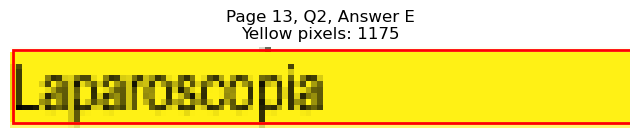


Page 13, Q2 - Selected Answer: E (based on yellow pixel count)




Page 13, Q3 - A: Detected box: x0=82.5, y0=287.1, x1=152.7, y1=299.7
Page 13, Q3, A: Yellow pixels: 0
Page 13, Q3, A: Total non-white pixels: 336
Page 13, Q3, A: Yellow percentage: 0.0%


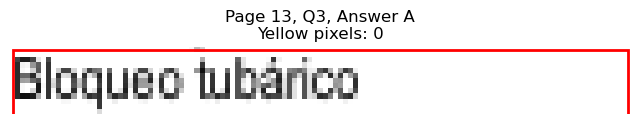

Page 13, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=100.5, y1=312.3
Page 13, Q3, B: Yellow pixels: 0
Page 13, Q3, B: Total non-white pixels: 90
Page 13, Q3, B: Yellow percentage: 0.0%


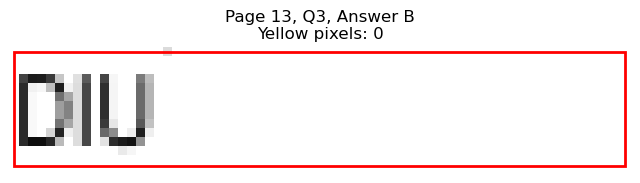

Page 13, Q3 - C: Detected box: x0=82.9, y0=312.3, x1=135.6, y1=324.9
Page 13, Q3, C: Yellow pixels: 0
Page 13, Q3, C: Total non-white pixels: 249
Page 13, Q3, C: Yellow percentage: 0.0%


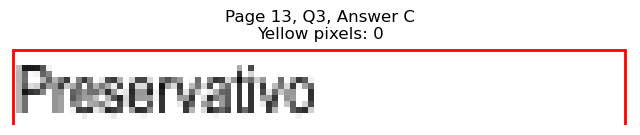

Page 13, Q3 - D: Detected box: x0=334.6, y0=287.1, x1=378.8, y1=299.7
Page 13, Q3, D: Yellow pixels: 2
Page 13, Q3, D: Total non-white pixels: 326
Page 13, Q3, D: Yellow percentage: 0.6%


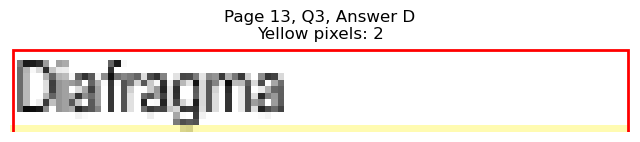

Page 13, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=384.3, y1=312.3
Page 13, Q3, E: Yellow pixels: 1029
Page 13, Q3, E: Total non-white pixels: 1414
Page 13, Q3, E: Yellow percentage: 72.8%


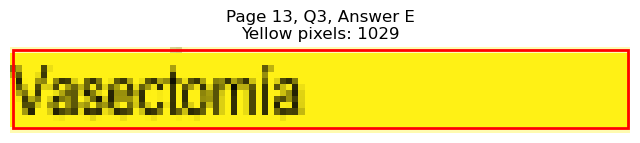


Page 13, Q3 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el factor de riesgo más importante pa...
1   Segundigesta de 28 semanas, con grupo y factor...
2   Gestante de 20 semanas, G4 P1021, antecedente ...
3   Una gestante tiene 34 semanas por FUR acude a ...
4   Gestante de 36 semanas, con VIH desde antes de...
..                                                ...
95  Gestante de 20 años con 10 semanas de embarazo...
96  Mujer de 40 años ha tenido 4 partos eutócicos,...
97  Mujer de 40 años, refiere menstruaciones regul...
98  De los siguientes exámenes o procedimientos, ¿...
99  Si usted fuera el encargado de determinar que ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                              Menarquia temprana   
1   Índice de pulsatilidad de la arteria cerebral   
2                          Insuficiencia cervical   
3                                 Parto prematuro   
4                                            1200   
..                                            ...   
95                                  Epigastralgia   
96                             Mola hidatidiforme   
97      Biopsia en sacabocado y curetaje cervical   
98                               Eco transvaginal   
99                               Bloqueo tubárico   

                                             option_B  \
0                                 Menopausia temprana   
1   Velocidad máxima sistólica de la arteria cerebral   
2                                   Aborto inevitable   
3                      Contracciones de Braxton-Hicks   
4                                                1500   
..                                                ...   
95                                         Meteorismo   
96                                        Hematometra   
97           Histerectomía inmediata y extirpación de   
98                           Eco doppler transvaginal   
99                                                DIU   

                                             option_C  \
0                                 Portadora de BRCA 1   
1            Velocidad máxima sistólica de la arteria   
2                                     Aborto en curso   
3                               Irritabilidad uterina   
4                                                1000   
..                                                ...   
95                        Pérdida de peso menor al 5%   
96                                      Tumor anexial   
97  Repetir el frotis de Papanicolaou y control a los   
98                       Cultivo de secreción vaginal   
99                                       Preservativo   

                                          option_D  \
0                                         Obesidad   
1   Índice de pulsatilidad de la arteria umbilical   
2                      Trabajo de parto pretérmino   
3                                  Embarazo normal   
4                                              500   
..                                             ...   
95                     Presencia de aliento fétido   
96                              Miomatosis uterina   
97                         Colposcopía con biopsia   
98                                   Histeroscopía   
99                                       Diafragma   

                                         option_E  
0                     Irregularidades menstruales  
1   Índice de resistencia de la arteria umbilical  
2                               Aborto espontáneo  
3                     Amenaza de parto pretérmino  
4                                             200  
..                                            ...  
95               Alteraciones hidroelectrolíticas  
96                               Embarazo gemelar  
97               Dilatación y legrado fraccionado  
98                                   Laparoscopia  
99                                     Vasectomía  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál es el factor de riesgo más importante pa...   
1   Segundigesta de 28 semanas, con grupo y factor...   
2   Gestante de 20 semanas, G4 P1021, antecedente ...   
3   Una gestante tiene 34 semanas por FUR acude a ...   
4   Gestante de 36 semanas, con VIH desde antes de...   
..                                                ...   
95  Gestante de 20 años con 10 semanas de embarazo...   
96  Mujer de 40 años ha tenido 4 partos eutócicos,...   
97  Mujer de 40 años, refiere menstruaciones regul...   
98  De los siguientes exámenes o procedimientos, ¿...   
99  Si usted fuera el encargado de determinar que ...   

                                         option_A  \
0                              Menarquia temprana   
1   Índice de pulsatilidad de la arteria cerebral   
2                          Insuficiencia cervical   
3                                 Parto prematuro   
4                                            1200   
..                                            ...   
95                                  Epigastralgia   
96                             Mola hidatidiforme   
97      Biopsia en sacabocado y curetaje cervical   
98                               Eco transvaginal   
99                               Bloqueo tubárico   

                                             option_B  \
0                                 Menopausia temprana   
1   Velocidad máxima sistólica de la arteria cerebral   
2                                   Aborto inevitable   
3                      Contracciones de Braxton-Hicks   
4                                                1500   
..                                                ...   
95                                         Meteorismo   
96                                        Hematometra   
97           Histerectomía inmediata y extirpación de   
98                           Eco doppler transvaginal   
99                                                DIU   

                                             option_C  \
0                                 Portadora de BRCA 1   
1            Velocidad máxima sistólica de la arteria   
2                                     Aborto en curso   
3                               Irritabilidad uterina   
4                                                1000   
..                                                ...   
95                        Pérdida de peso menor al 5%   
96                                      Tumor anexial   
97  Repetir el frotis de Papanicolaou y control a los   
98                       Cultivo de secreción vaginal   
99                                       Preservativo   

                                          option_D  \
0                                         Obesidad   
1   Índice de pulsatilidad de la arteria umbilical   
2                      Trabajo de parto pretérmino   
3                                  Embarazo normal   
4                                              500   
..                                             ...   
95                     Presencia de aliento fétido   
96                              Miomatosis uterina   
97                         Colposcopía con biopsia   
98                                   Histeroscopía   
99                                       Diafragma   

                                         option_E correct_answer  
0                     Irregularidades menstruales              D  
1   Índice de resistencia de la arteria umbilical              B  
2                               Aborto espontáneo              A  
3                     Amenaza de parto pretérmino              E  
4                                             200              C  
..                                            ...            ...  
95               Alteraciones hidroelectrolíticas              E  
96                               Embarazo gemelar              A  
97               Dilatación y legrado fraccionado              D  
98                               

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/GINECOLOGIA Y OBSTETRICIA.csv
